In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats
import matplotlib.pyplot as plt

### Auxilliary functions

In [ ]:
def fit_and_test_models(X, y, plot=False):
    """
    Fit both linear and sinusoidal models and test their significance.
    
    Parameters:
    X : array-like, shape (n_samples,)
        The input time points
    y : array-like, shape (n_samples,)
        The target values
    plot : bool, optional
        If True, plot the results. Default is False.
        
    Returns:
    dict: Dictionary containing test results
    """
    # Reshape X for sklearn
    X_linear = X.reshape(-1, 1)
    
    # Fit linear model
    linear_model = LinearRegression()
    linear_model.fit(X_linear, y)
    y_pred_linear = linear_model.predict(X_linear)
    
    # Calculate R² and p-value for linear model
    r2_linear = r2_score(y, y_pred_linear)
    slope = linear_model.coef_[0]
    
    # Calculate p-value for linear model
    n = len(X)
    slope_stderr = np.sqrt(np.sum((y - y_pred_linear) ** 2) / (n-2)) / np.sqrt(np.sum((X - np.mean(X)) ** 2))
    t_stat = slope / slope_stderr
    p_value_linear = 2 * (1 - stats.t.cdf(abs(t_stat), n-2))
    
    # Create features for sinusoidal model
    X_sin = np.column_stack([
        np.ones_like(X),
        np.sin(180*X/(2*np.pi)),
        np.cos(180*X/(2*np.pi)),
    ])
    
    # Fit sinusoidal model
    sin_model = LinearRegression(fit_intercept=False)
    sin_model.fit(X_sin, y)
    y_pred_sin = sin_model.predict(X_sin)
    
    # Calculate R² and F-statistic for sinusoidal model
    r2_sin = r2_score(y, y_pred_sin)
    f_stat = (r2_sin / 2) / ((1 - r2_sin) / (n - 3))
    p_value_sin = 1 - stats.f.cdf(f_stat, 2, n-3)
    
    if plot:
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Plot linear fit
        ax1.scatter(X, y, color='blue', alpha=0.5, label='Data')
        ax1.plot(X, y_pred_linear, color='red', label=f'Linear fit (R²={r2_linear:.3f})')
        ax1.set_xlabel('X')
        ax1.set_ylabel('y')
        ax1.set_title('Linear Regression')
        ax1.legend()
        
        # Plot sinusoidal fit
        ax2.scatter(X, y, color='blue', alpha=0.5, label='Data')
        sort_idx = np.argsort(X)
        ax2.plot(X[sort_idx], y_pred_sin[sort_idx], color='red', 
                label=f'Sinusoidal fit (p-value={p_value_sin:.3f})')
        ax2.set_xlabel('X')
        ax2.set_ylabel('y')
        ax2.set_title('Sinusoidal Regression')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

    return {
        'linear_r2': r2_linear,
        'linear_p_value': p_value_linear,
        'slope': slope,
        'slope_direction': 'positive' if slope > 0 else 'negative',
        'sin_r2': r2_sin,
        'sin_p_value': p_value_sin
    }

In [ ]:
def analyse_area(dataset, area, covariate, plot):
    """
    Analyze the relationship between a covariate and neural activity for a specific brain area.

    Parameters:
    dataset : pandas.DataFrame
        The dataset containing neural activity data. Must include columns 'area', 'unit_id', 
        the specified covariate, and 'spikes_per_second'.
    area : str
        The brain area to filter the dataset by.
    covariate : str
        The covariate to analyze (e.g., 'temporal_frequency', 'orientation', etc.).
    plot : bool
        If True, generate plots for the fitted models.

    Returns:
    pandas.DataFrame
        A DataFrame where each row corresponds to a unit in the specified area, and columns 
        contain the results of the model fitting and statistical tests (e.g., R², p-values, slope).
    """
    filtered_dataset = dataset[dataset['area'] == area][['unit_id', covariate, 'spikes_per_second']]
    results = {}
    for unit in filtered_dataset['unit_id'].unique():
        unit_data = filtered_dataset[filtered_dataset['unit_id'] == unit]
        results[unit] = fit_and_test_models(unit_data[covariate].values, unit_data['spikes_per_second'].values, plot)
    return pd.DataFrame(results).T

In [15]:
def summarise_area(dataset, area, covariate, alpha=0.05, plot=False):
    df = analyse_area(dataset, area, covariate, plot)
    n_units = len(df)
    n_linear_significant = len(df[df['linear_p_value'] < alpha])
    n_positive = len(df[(df['slope_direction'] == 'positive') & (df['linear_p_value'] < alpha)])
    n_negative = n_linear_significant - n_positive
    n_sin_significant = len(df[df['sin_p_value'] < alpha])
    return {
        'n_units': n_units,
        'n_linear_significant': n_linear_significant,
        'n_positive': n_positive,
        'n_negative': n_negative,
        'n_sin_significant': n_sin_significant
    }

## Testing

In [9]:
session = 757216464

In [10]:
drifting_dataset = pd.read_parquet(f'../ourdata/drifting_dataset_session_{session}.parquet')
static_dataset = pd.read_parquet(f'../ourdata/static_dataset_session_{session}.parquet')

We restrict our attention to those visual areas which have a high number of neurons with high variance:

In [176]:
high_variance_visual_areas = ['VISal', 'VISp', 'VISrl', 'VISam', 'VISl']

In [16]:
def area_summary_df(area, plot=False):
    temporal_frequency = summarise_area(drifting_dataset, area, 'temporal_frequency', plot=plot)
    orientation_drifting = summarise_area(drifting_dataset, area, 'orientation', plot=plot)
    spatial_frequency = summarise_area(static_dataset, area, 'spatial_frequency', plot=plot)
    orientation_static = summarise_area(static_dataset, area, 'orientation', plot=plot)
    return pd.DataFrame({
        'temporal_frequency': temporal_frequency,
        'orientation_drifting': orientation_drifting,
        'spatial_frequency': spatial_frequency,
        'orientation_static': orientation_static
    }).T

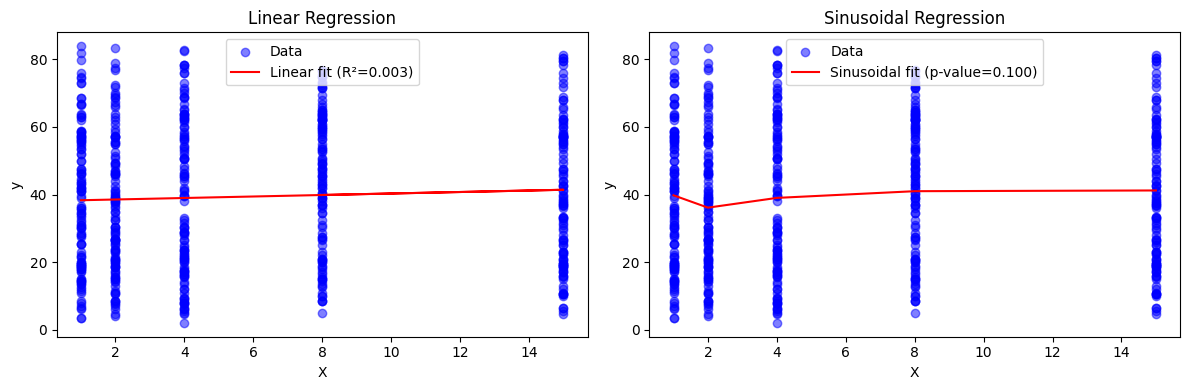

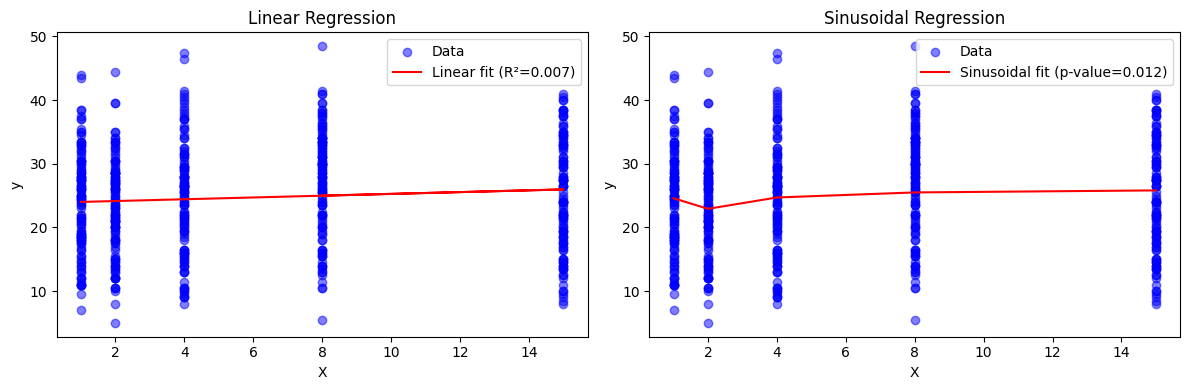

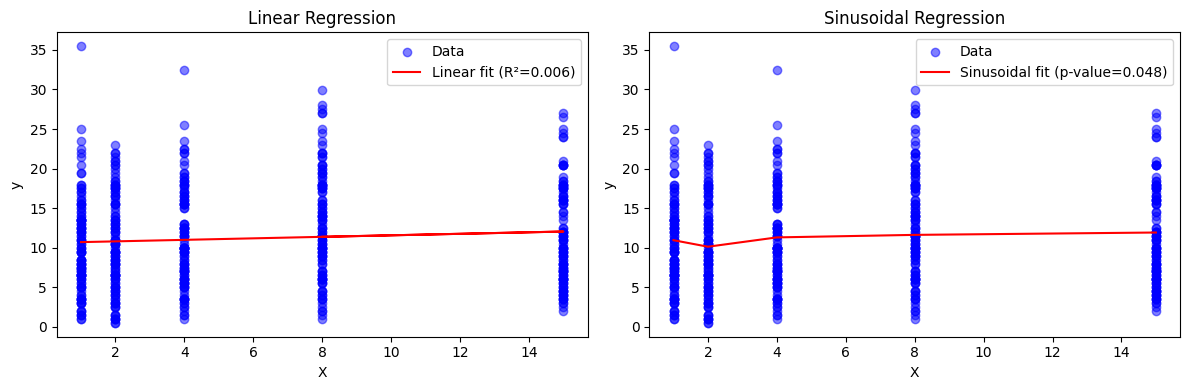

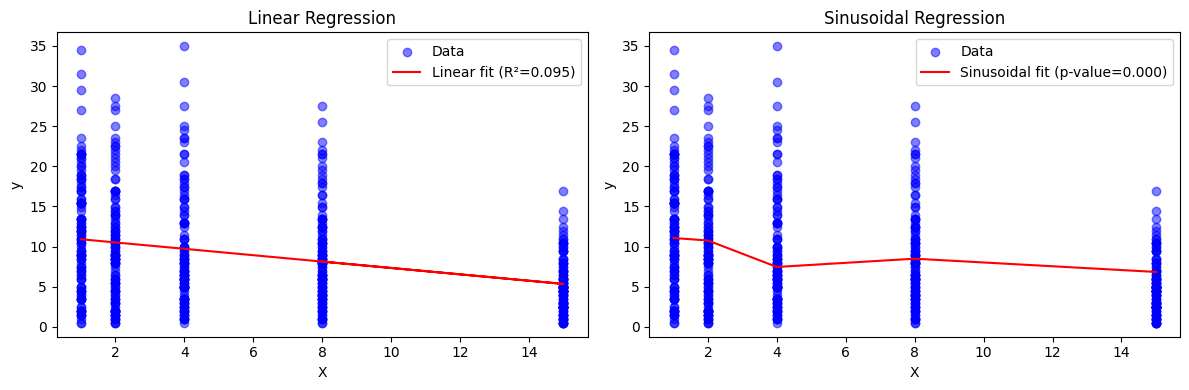

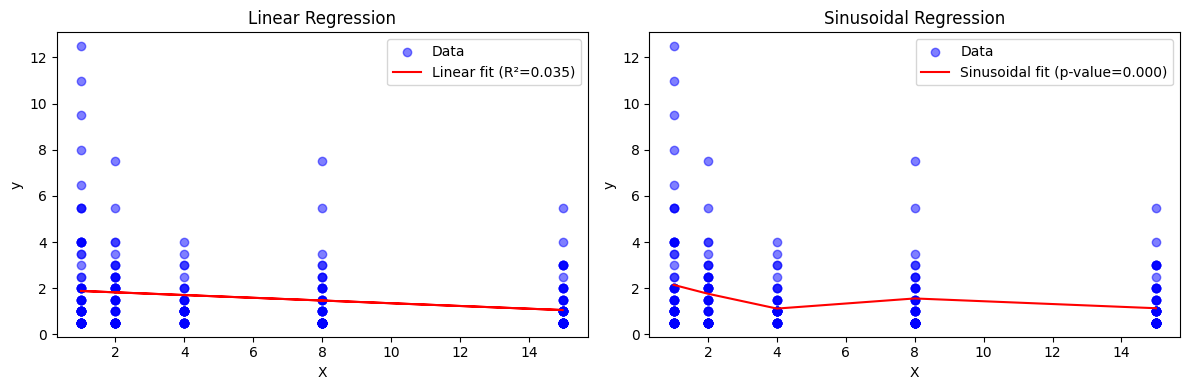

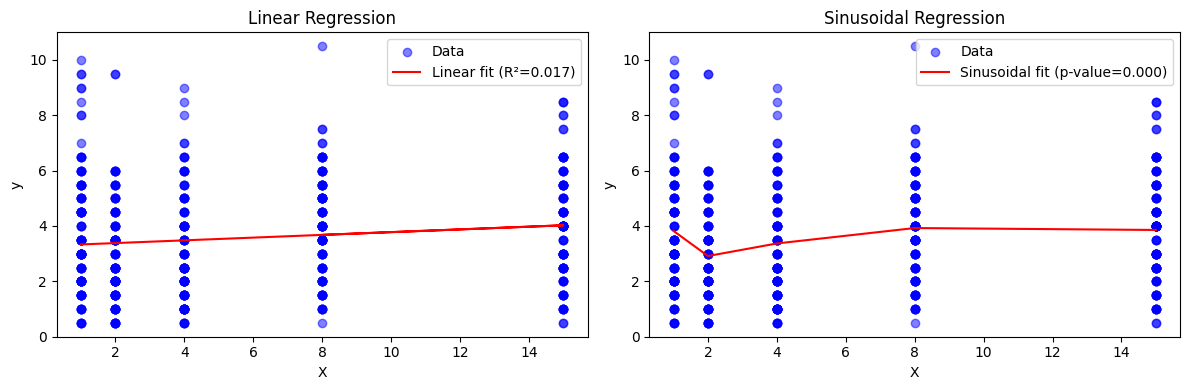

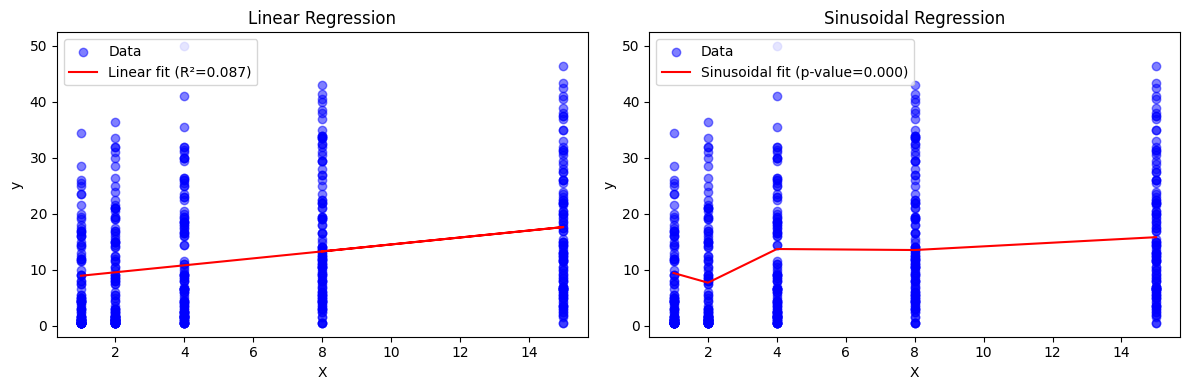

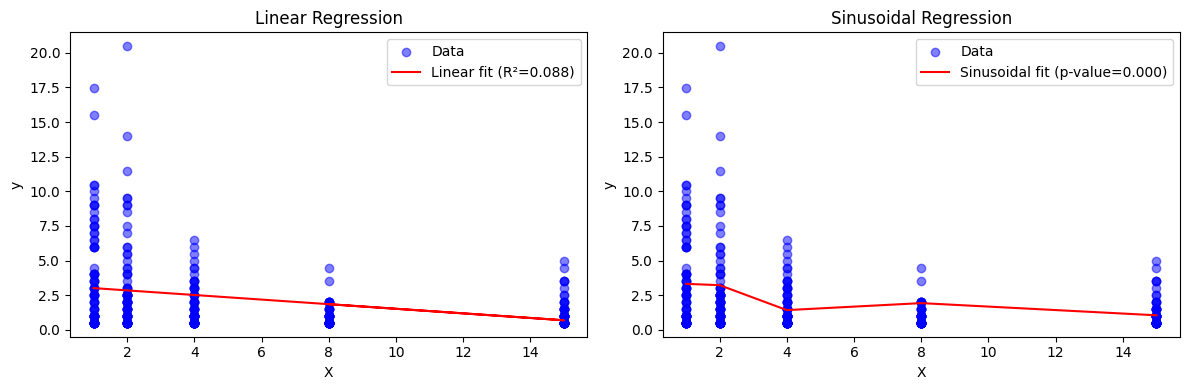

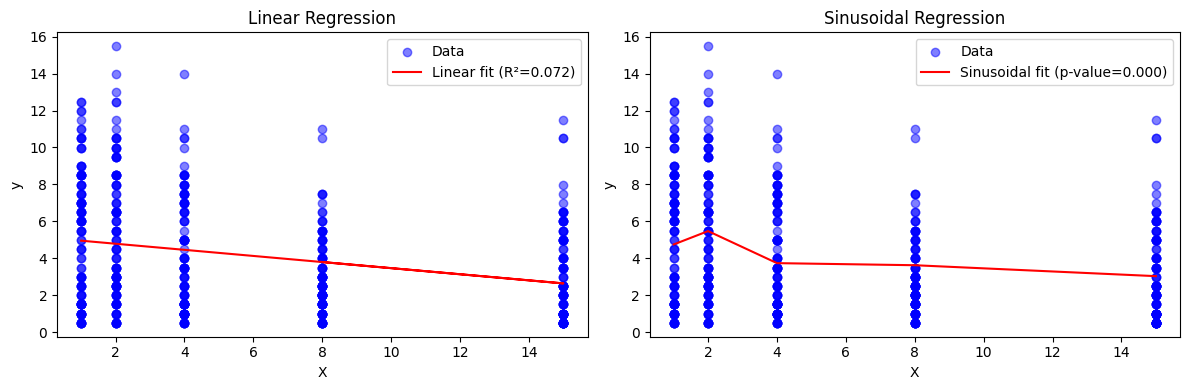

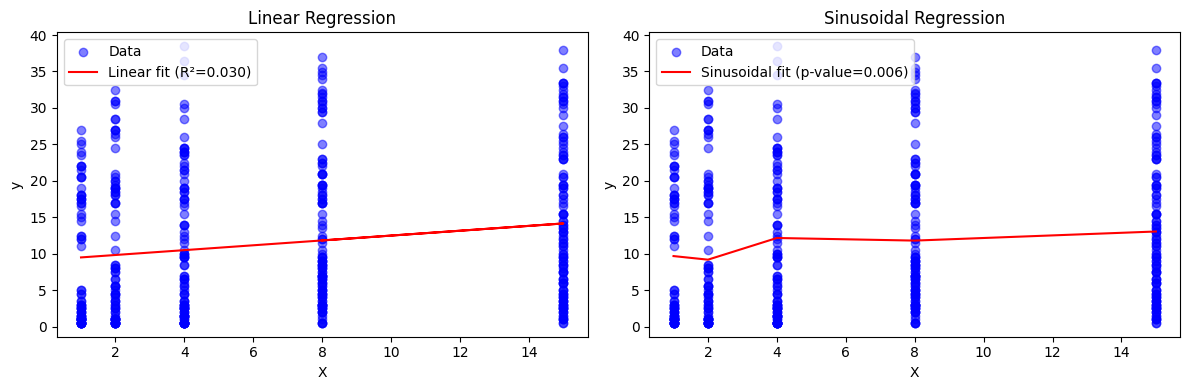

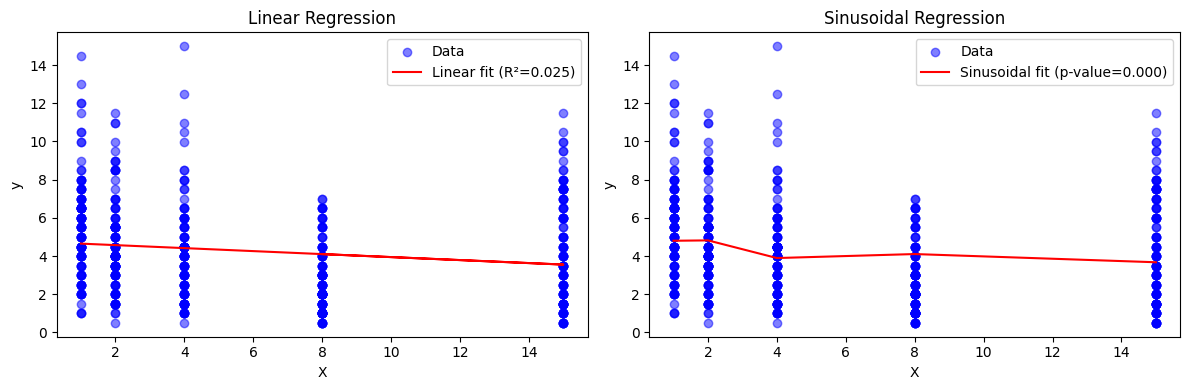

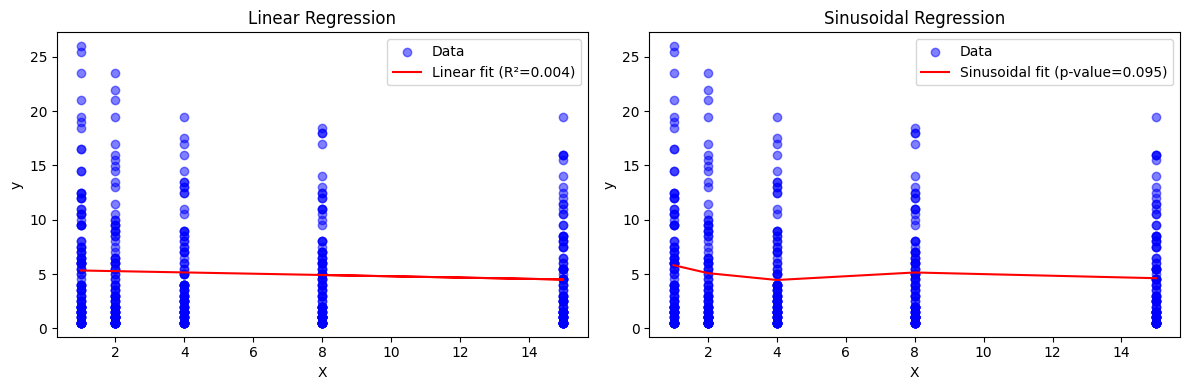

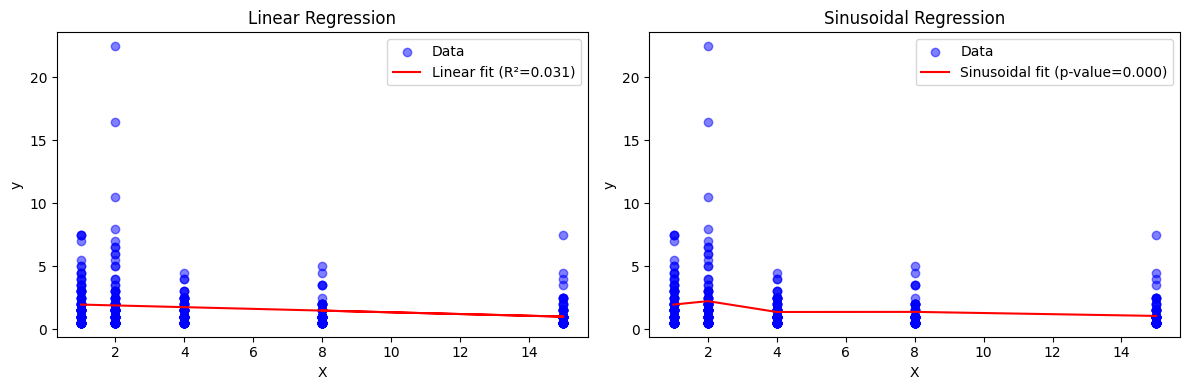

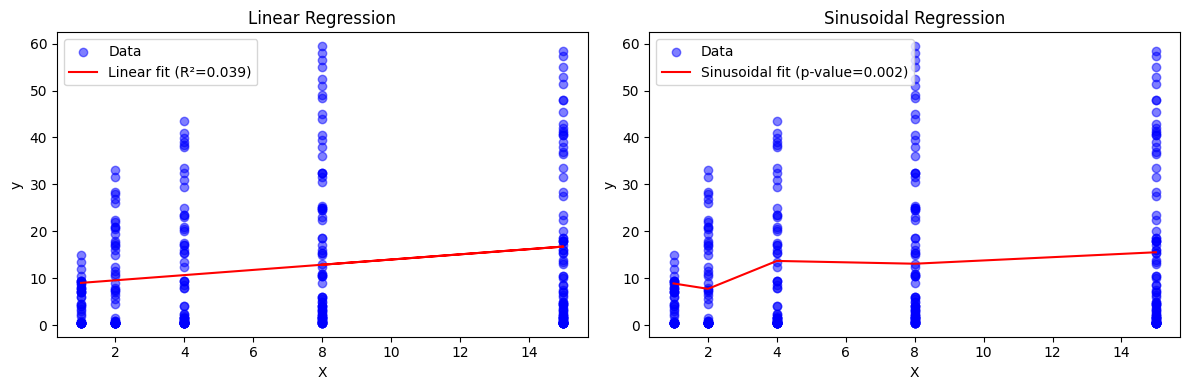

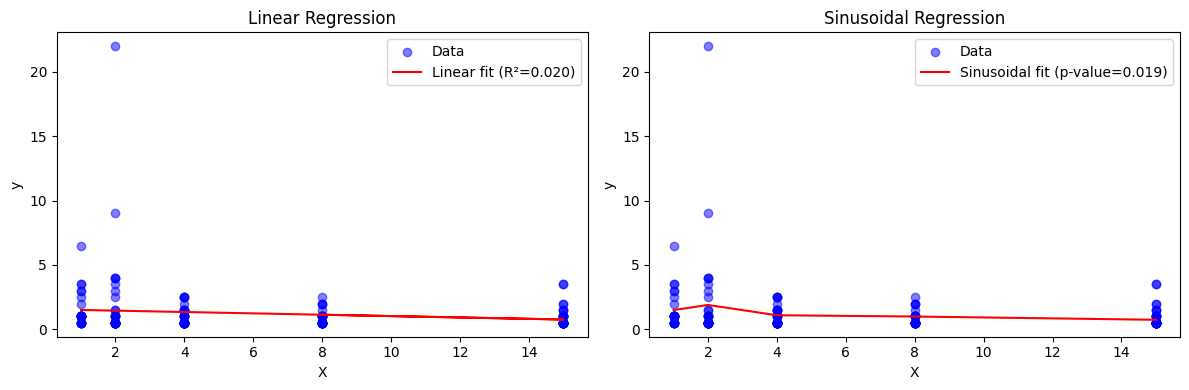

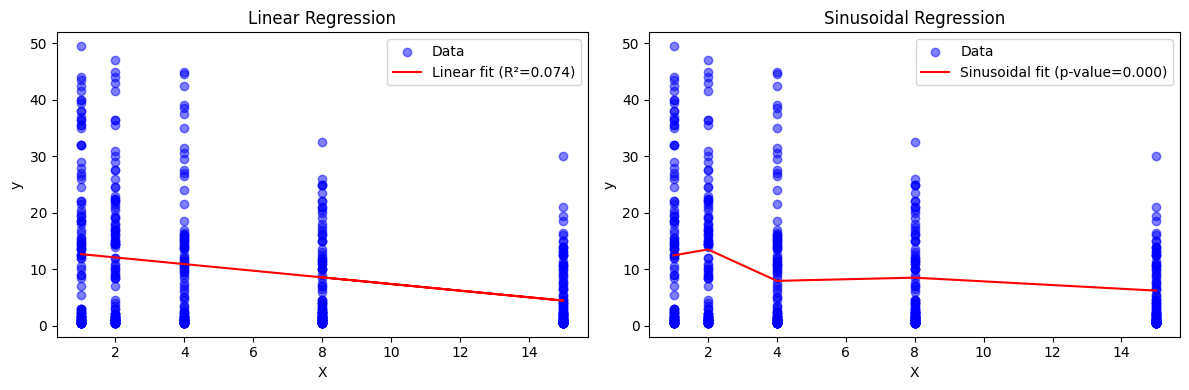

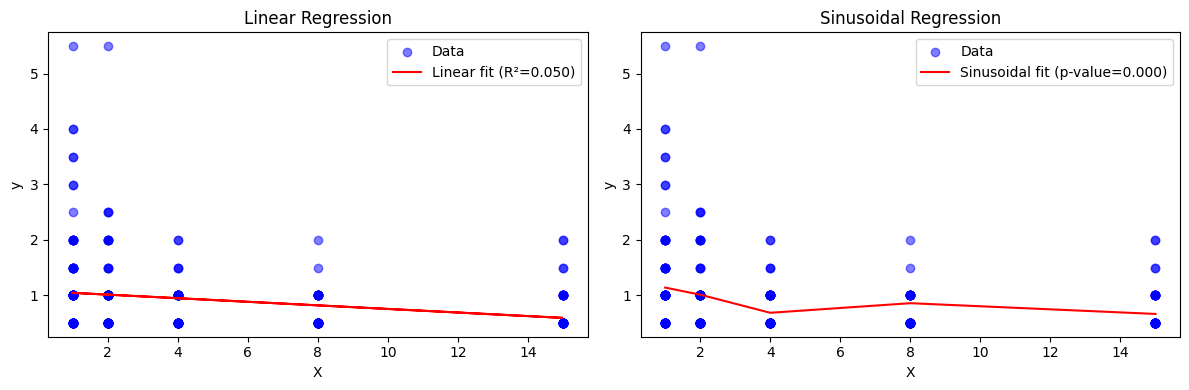

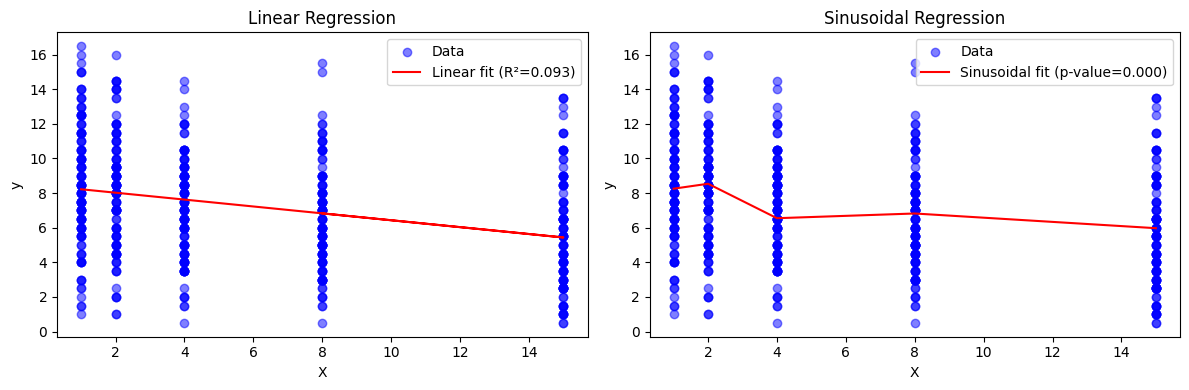

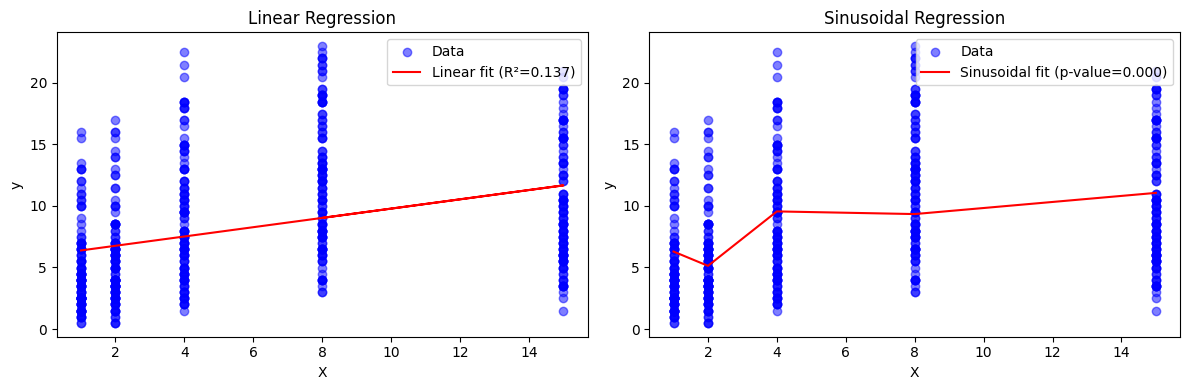

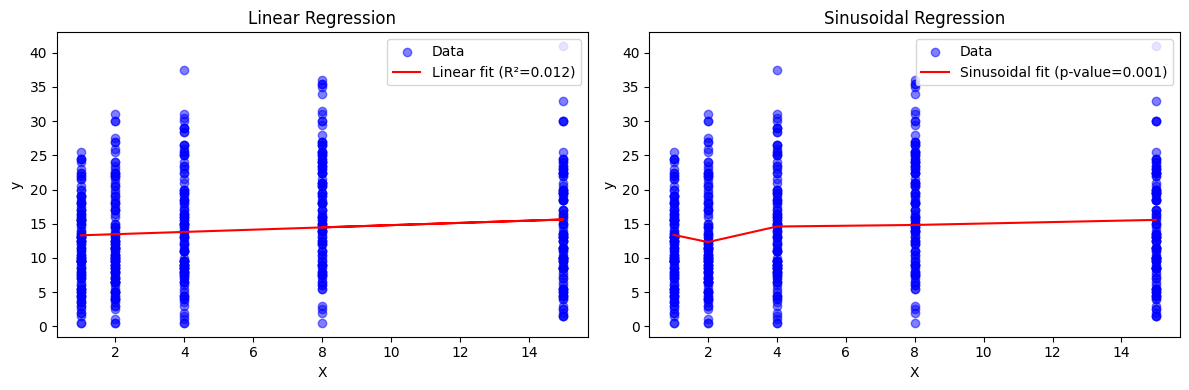

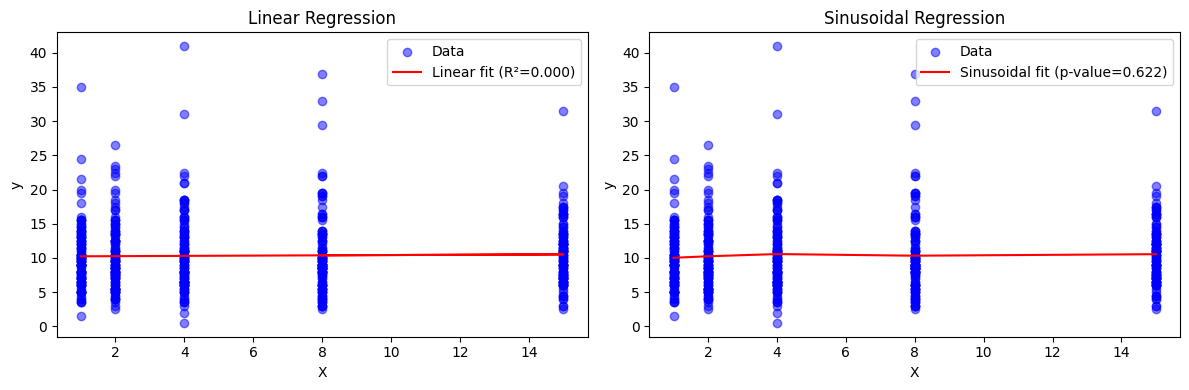

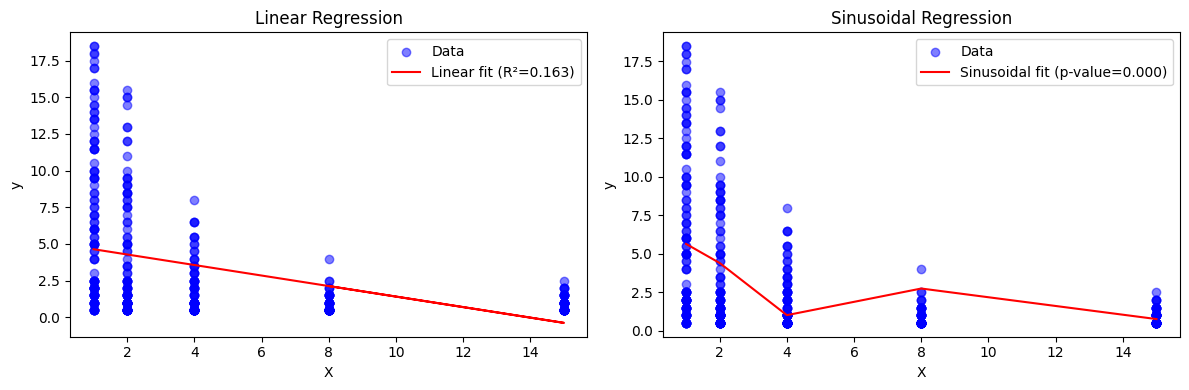

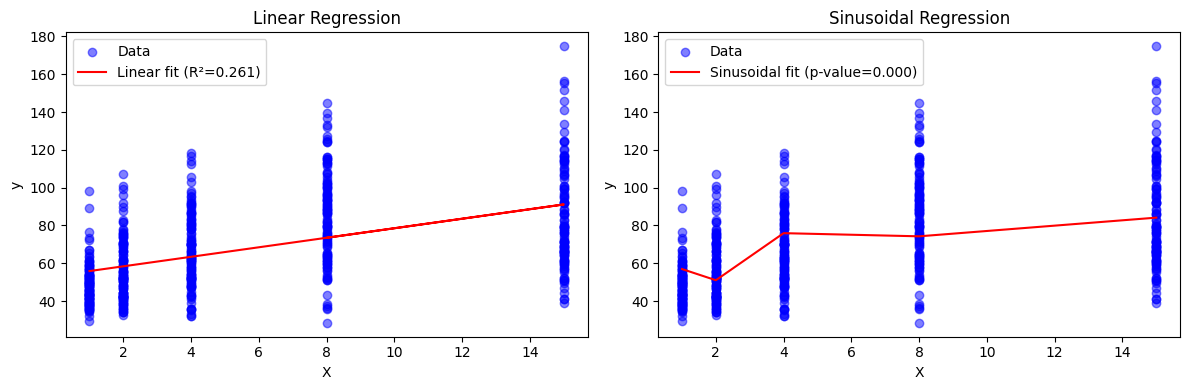

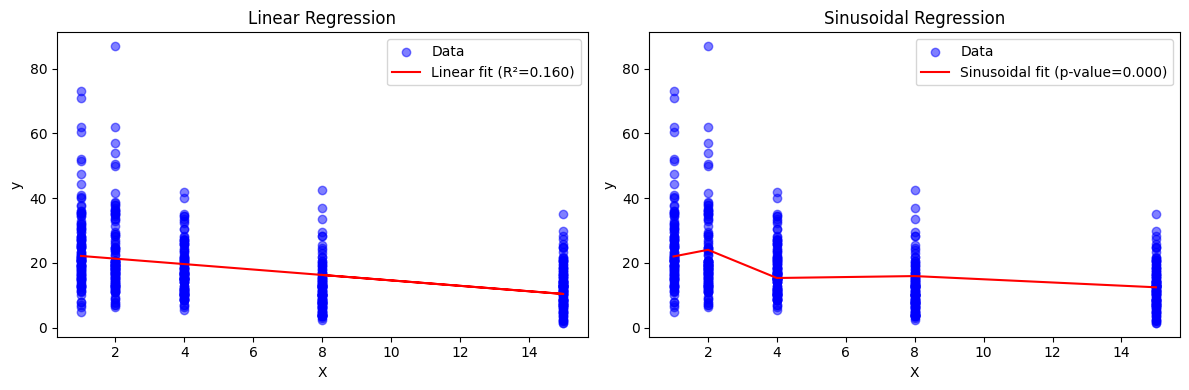

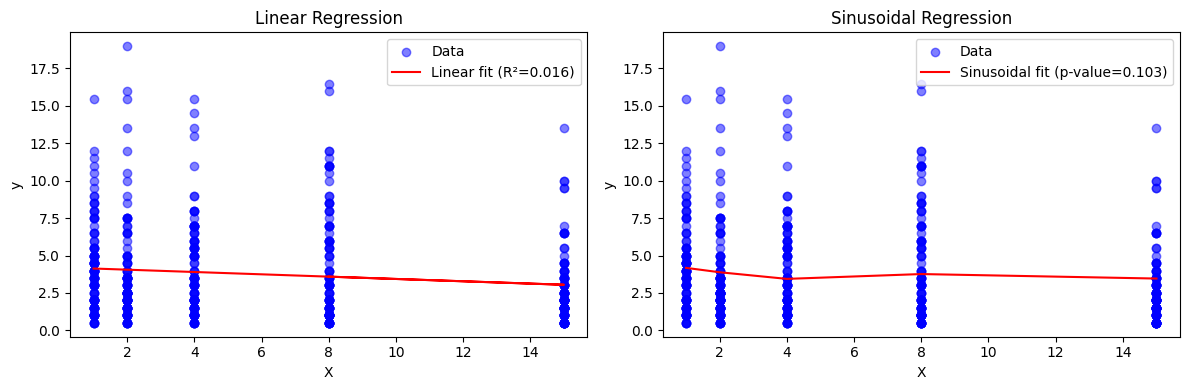

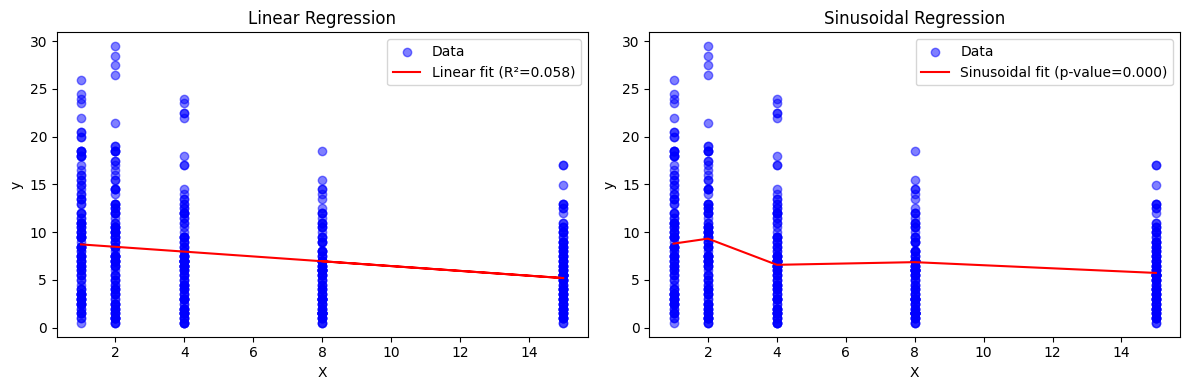

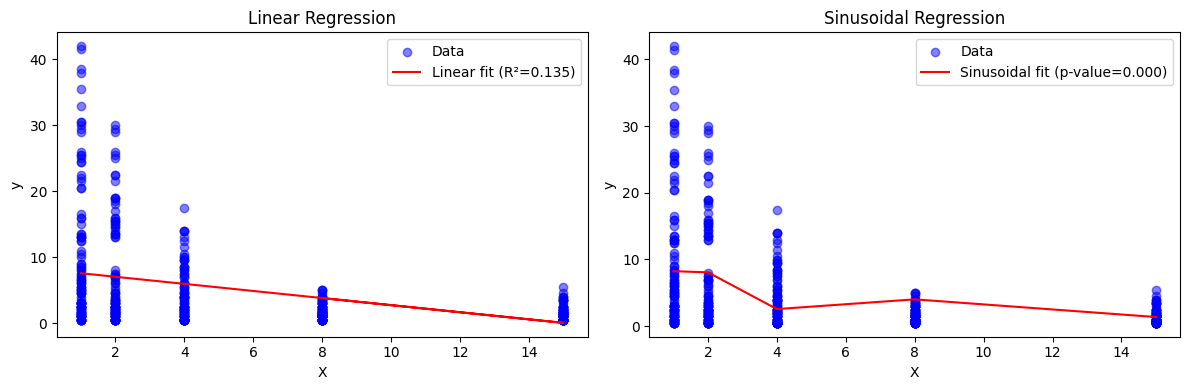

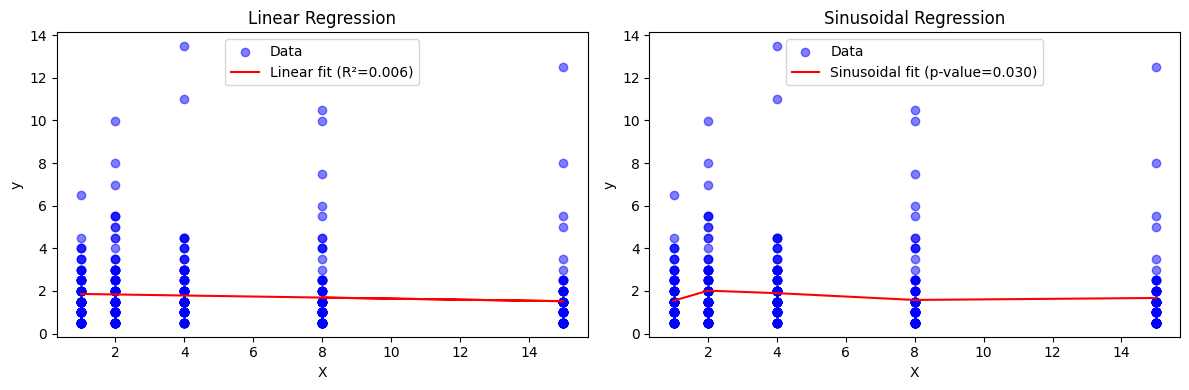

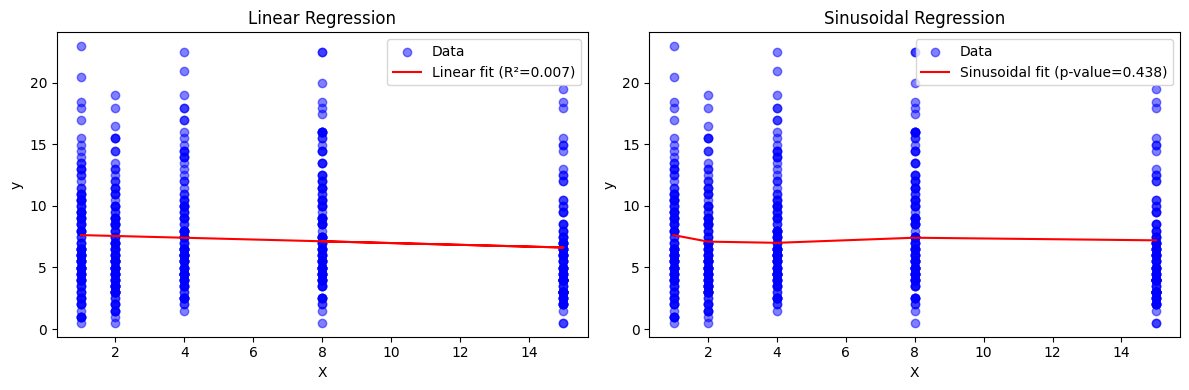

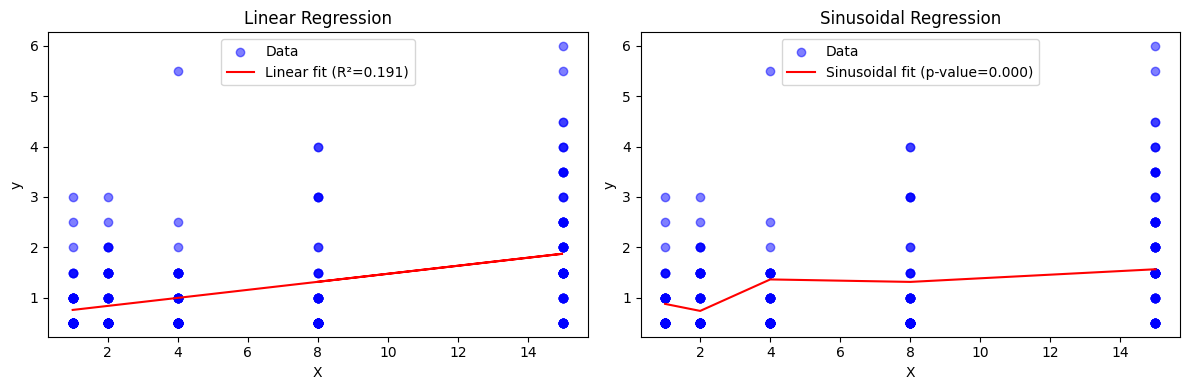

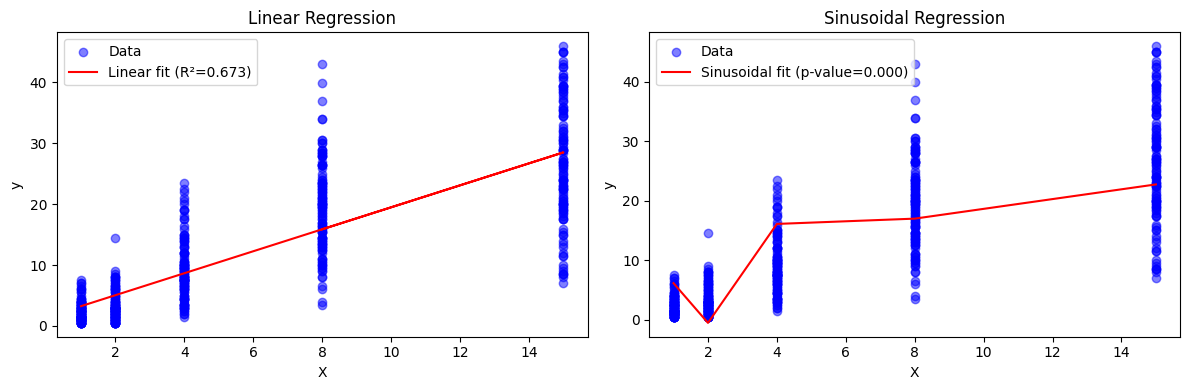

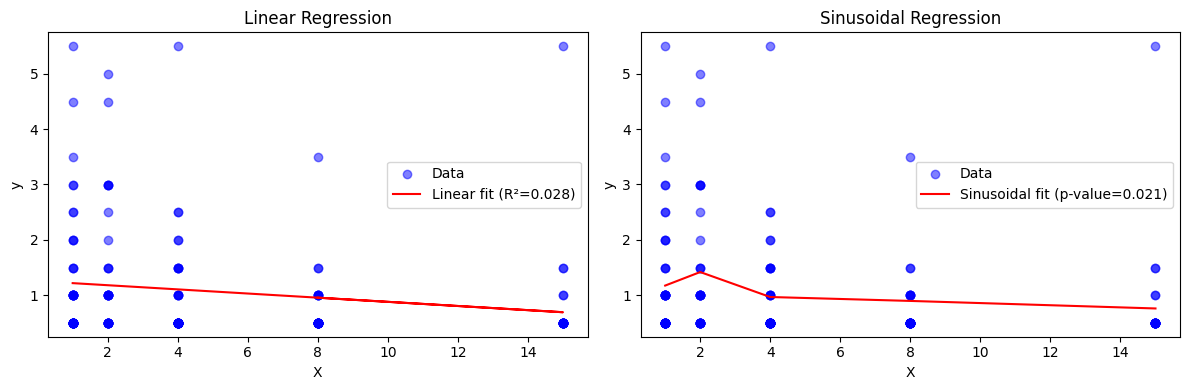

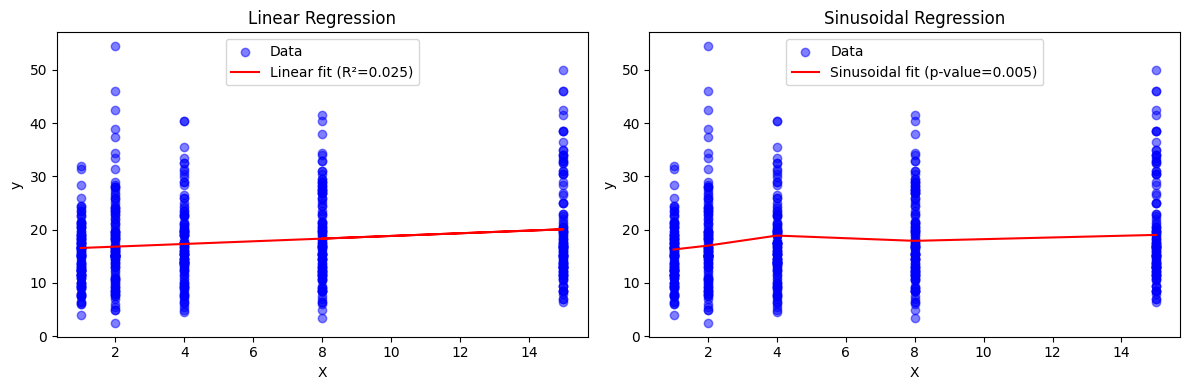

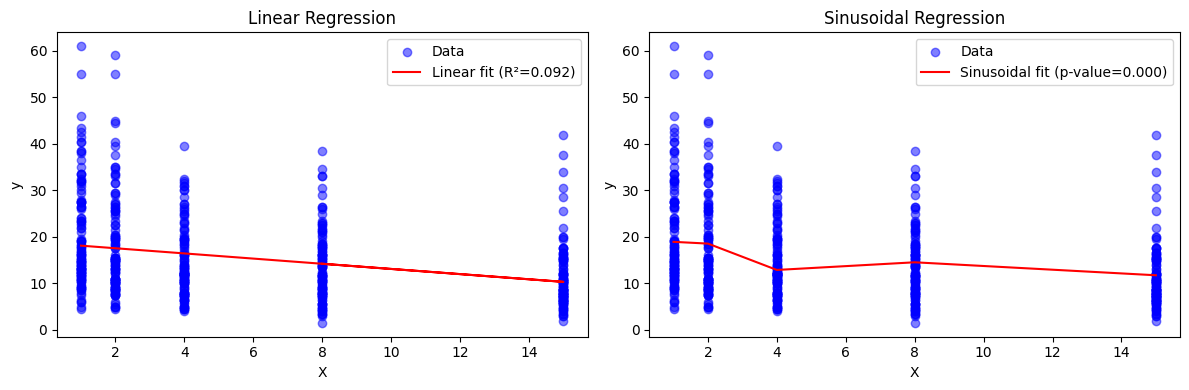

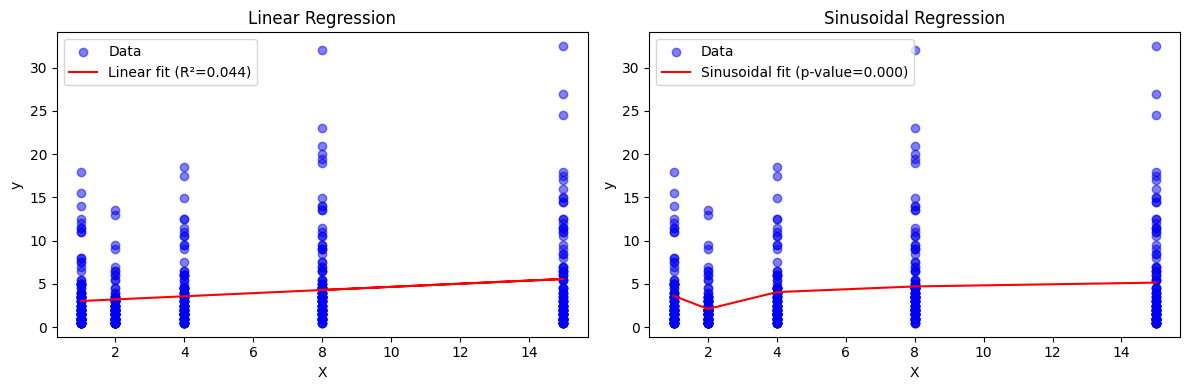

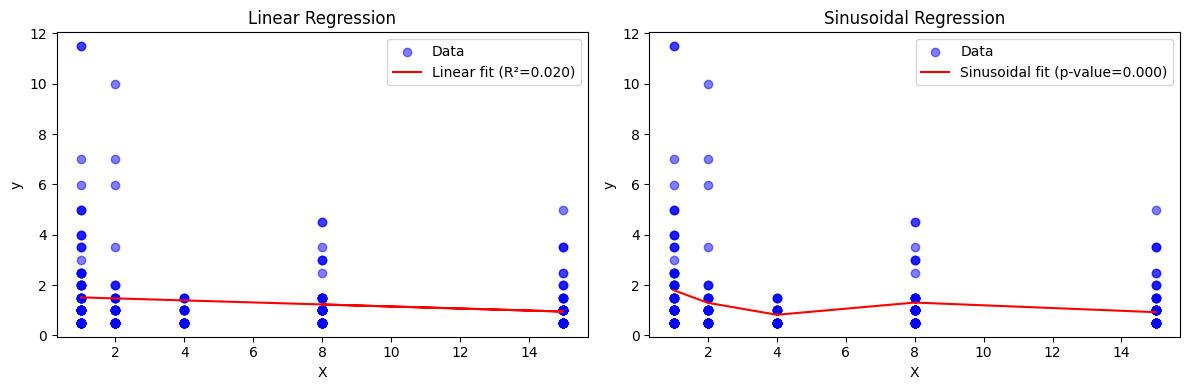

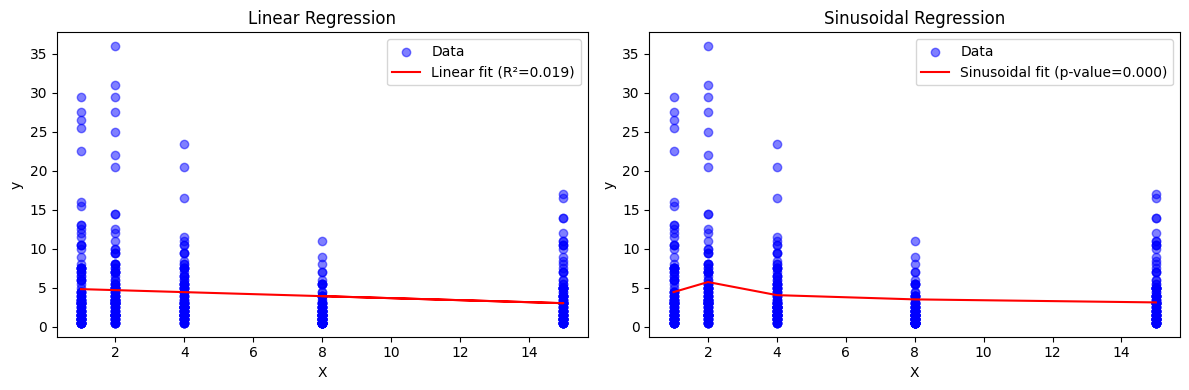

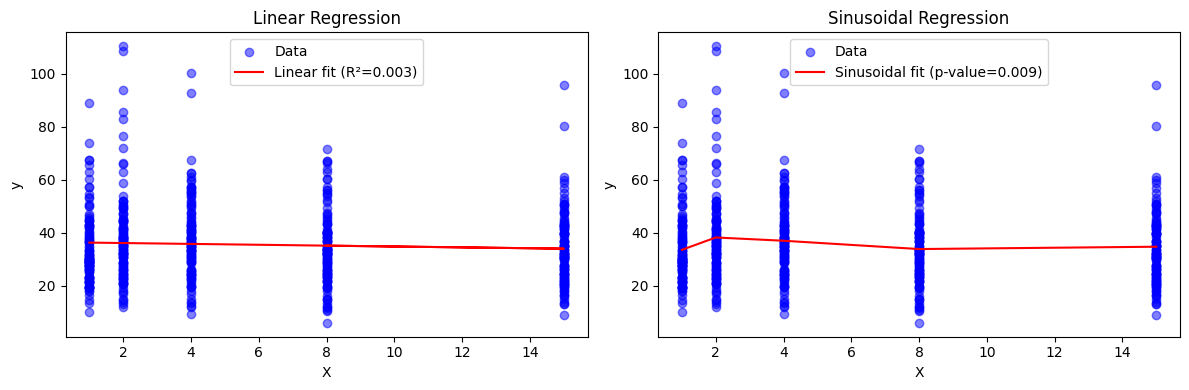

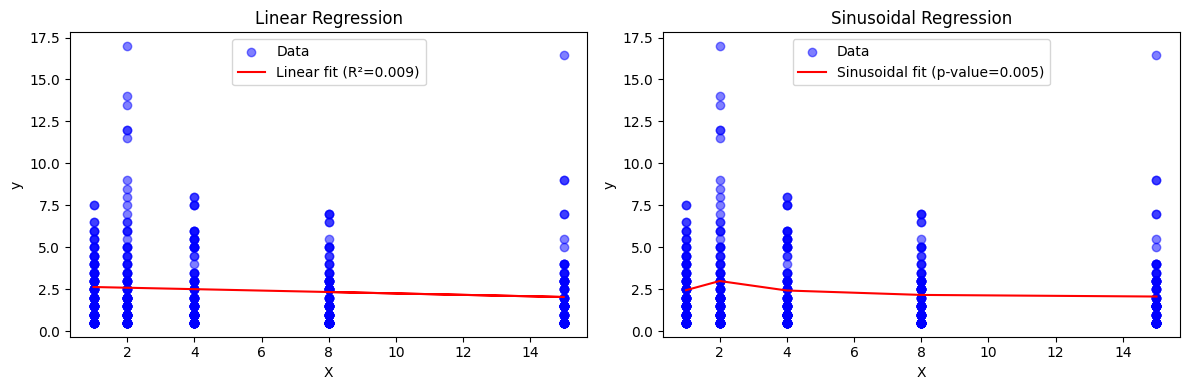

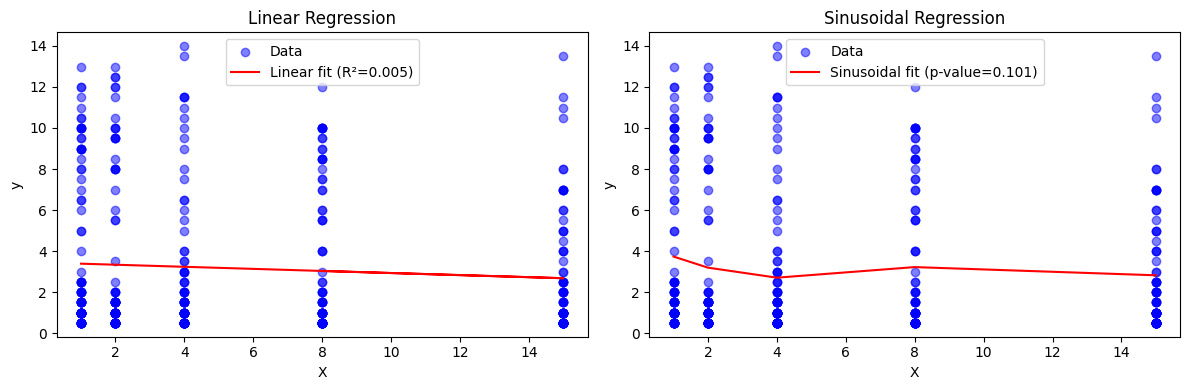

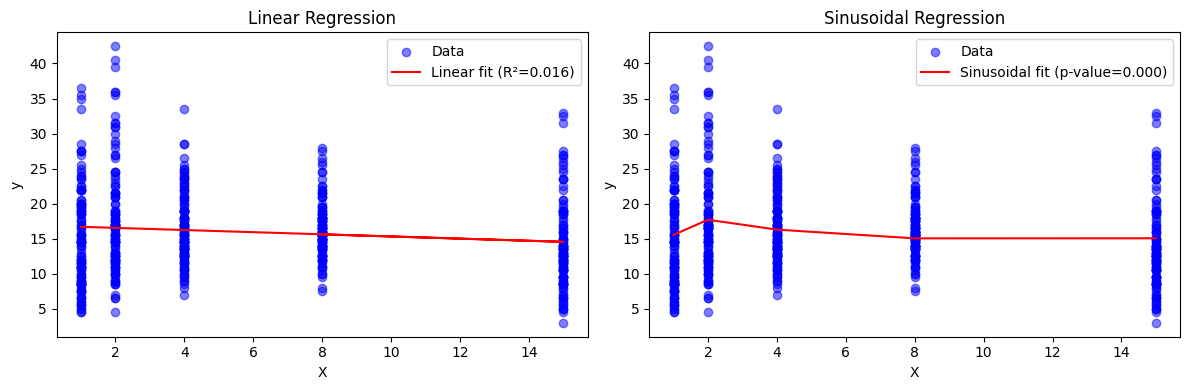

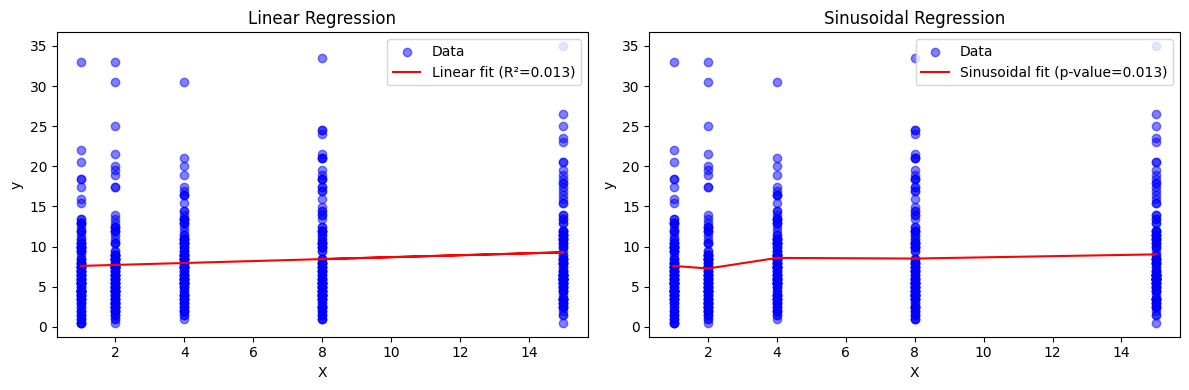

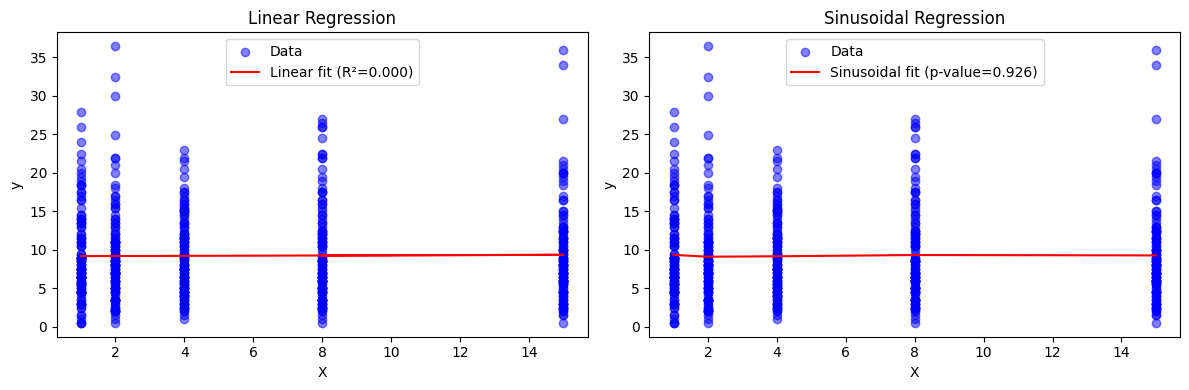

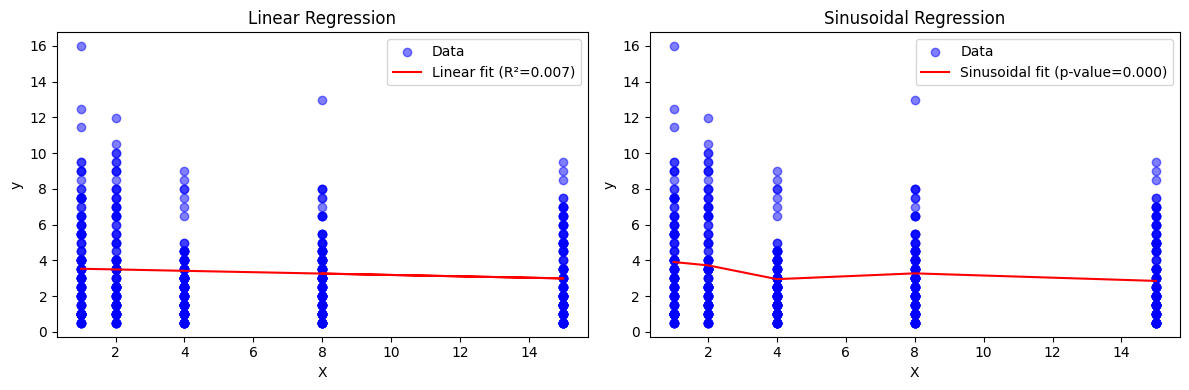

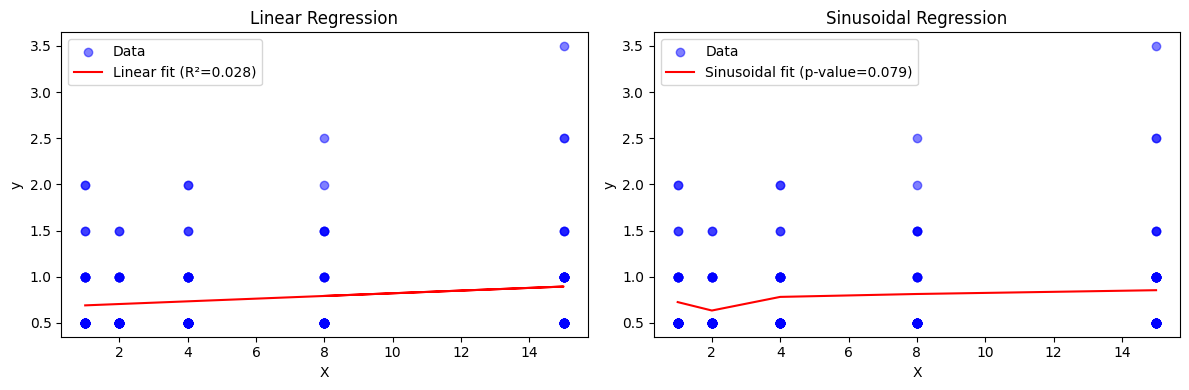

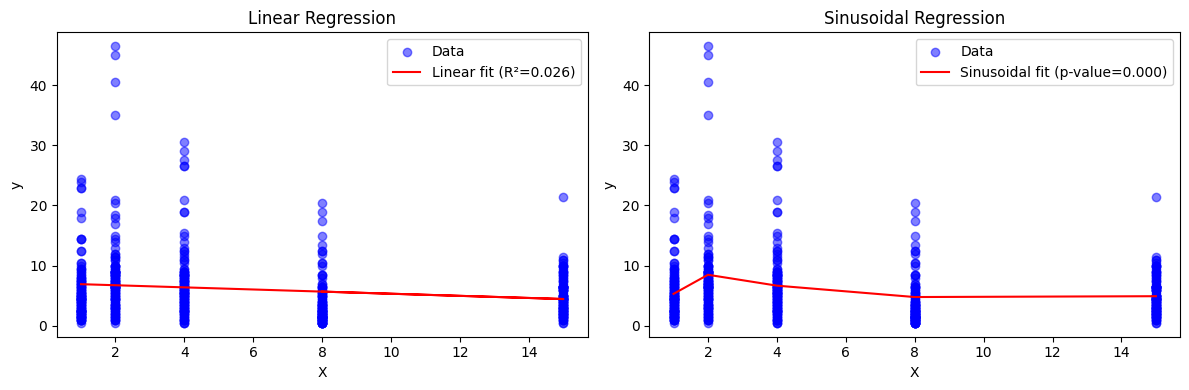

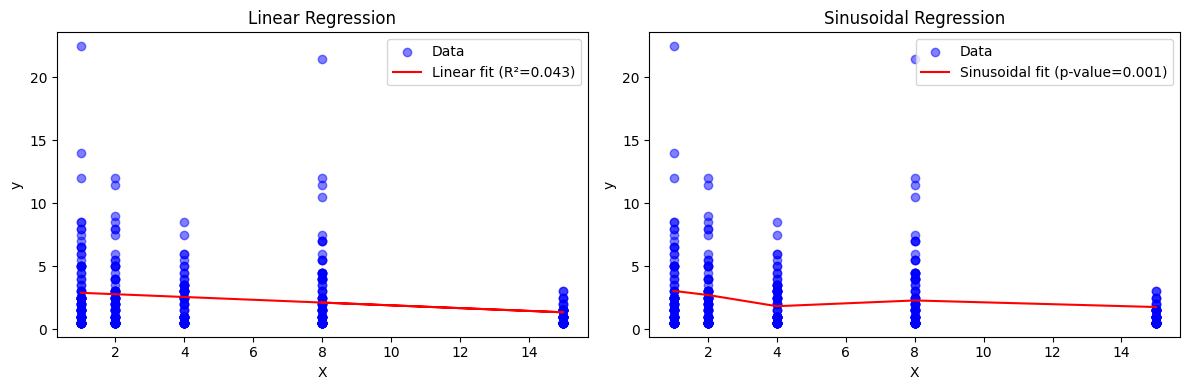

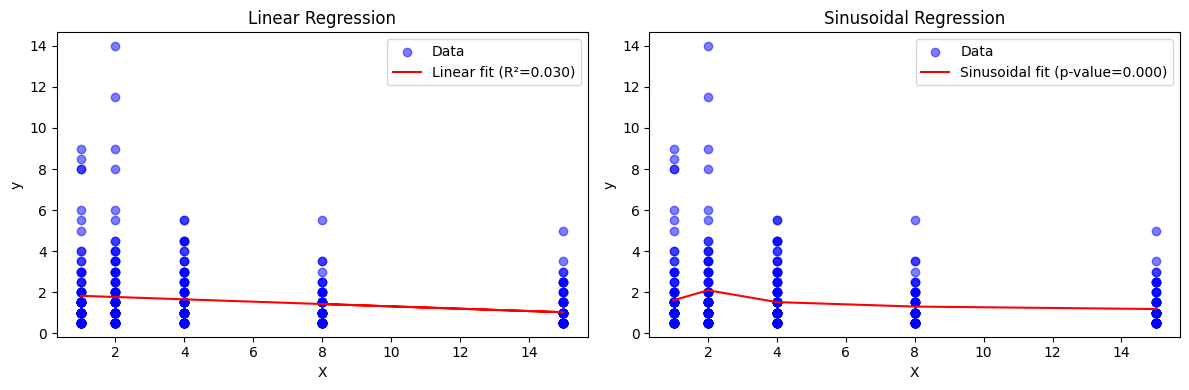

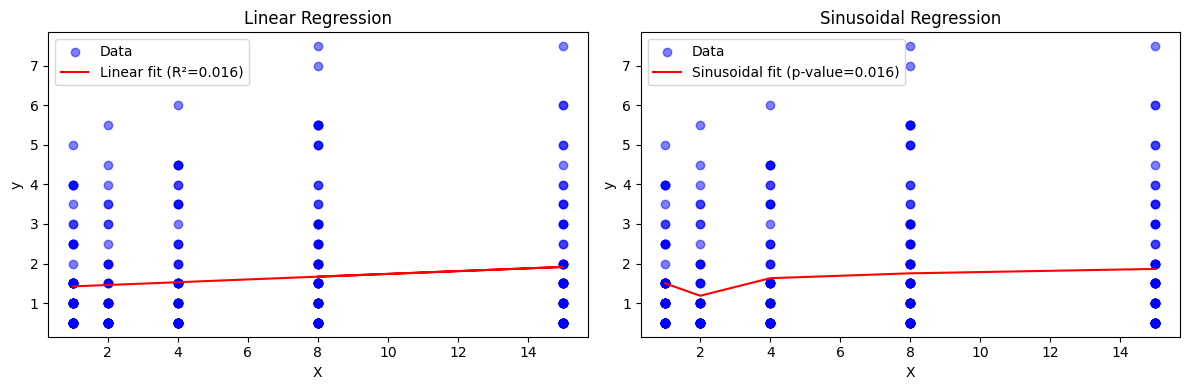

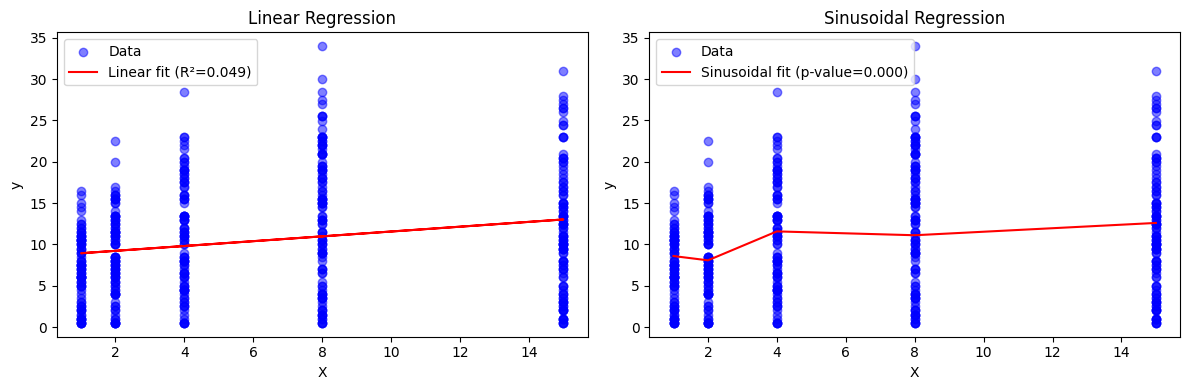

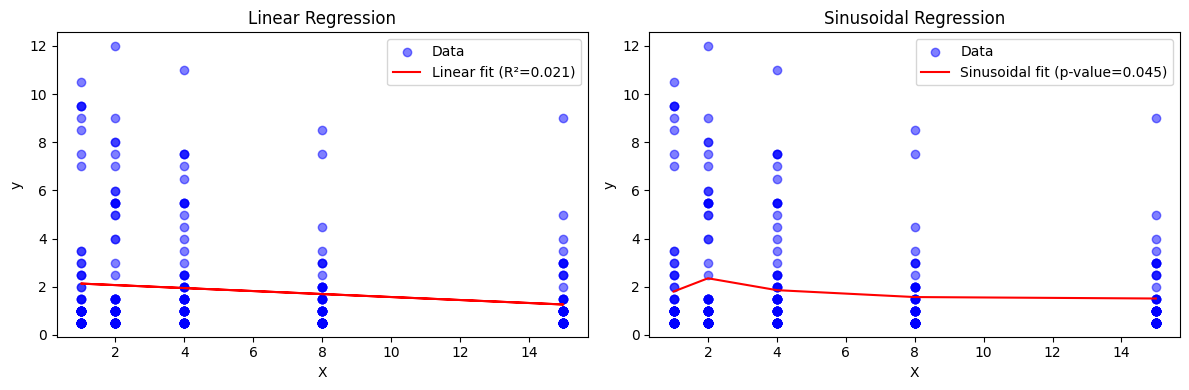

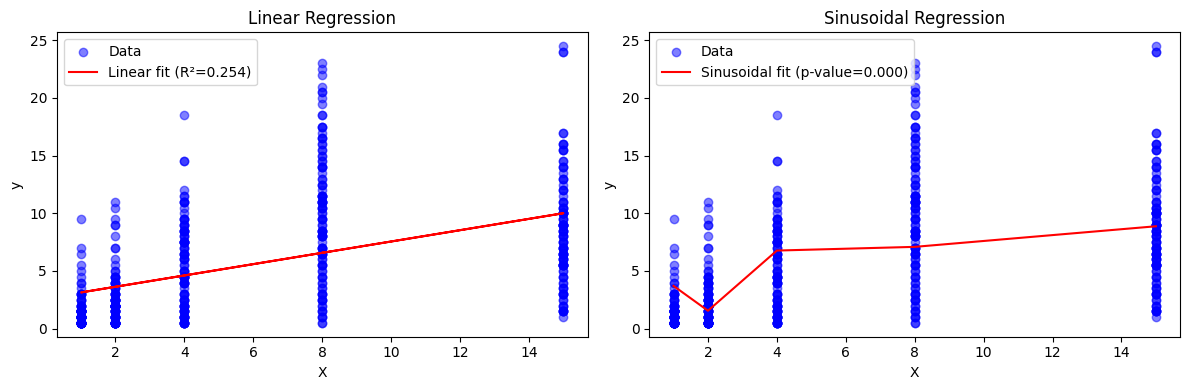

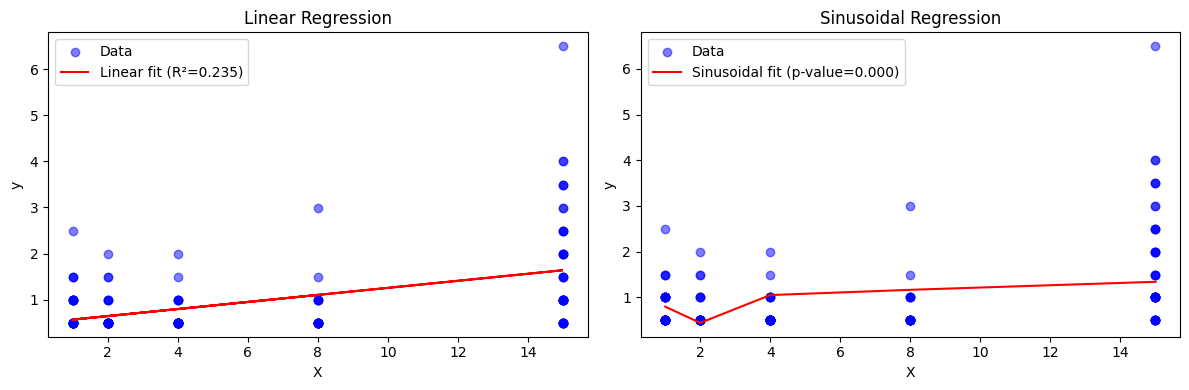

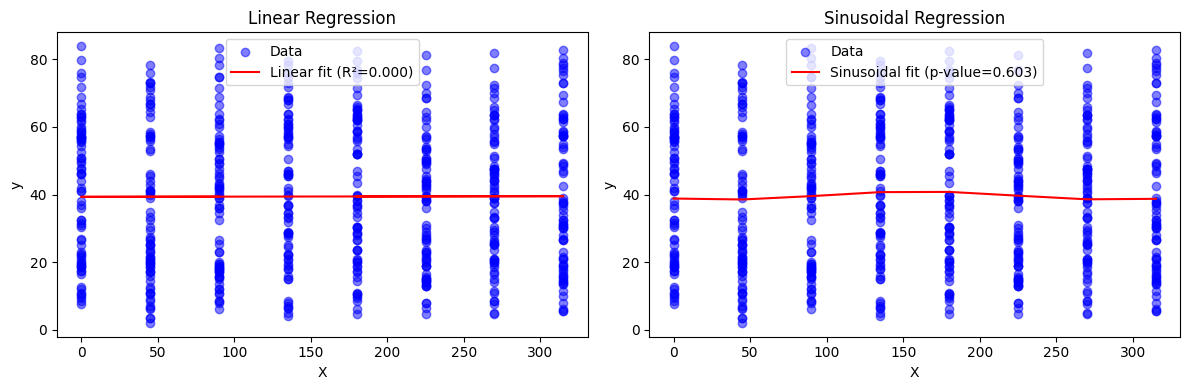

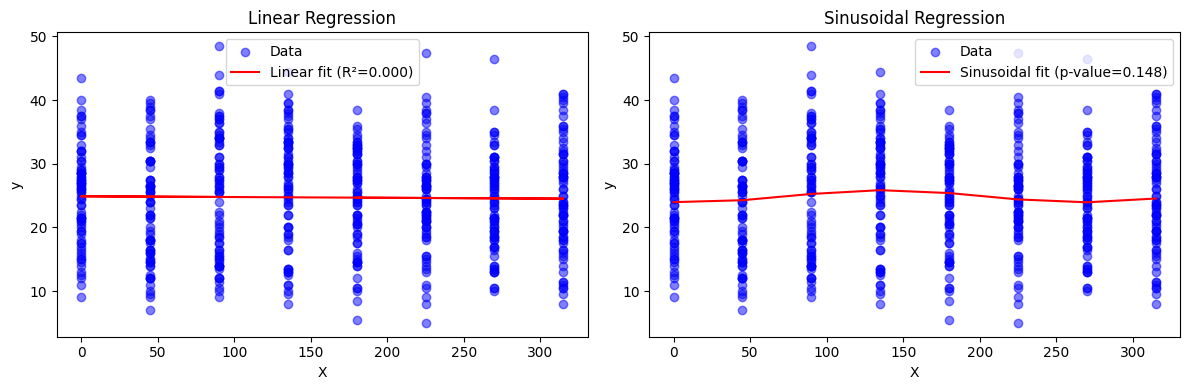

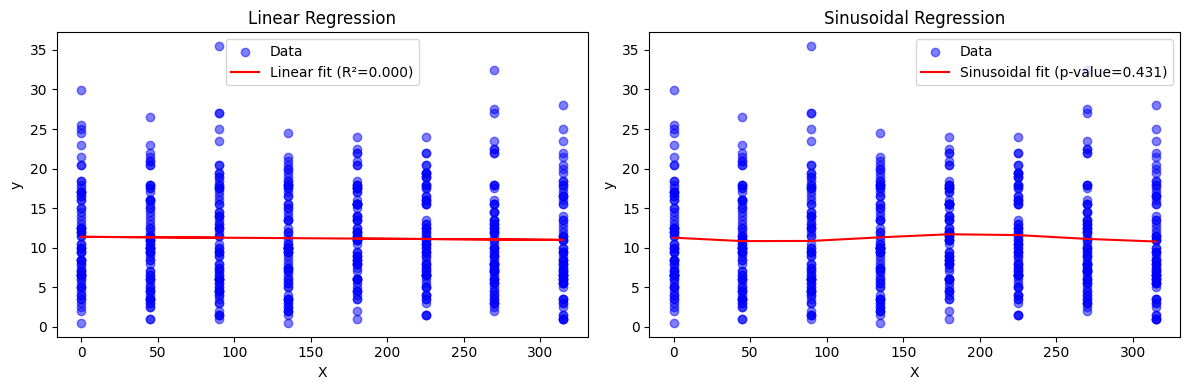

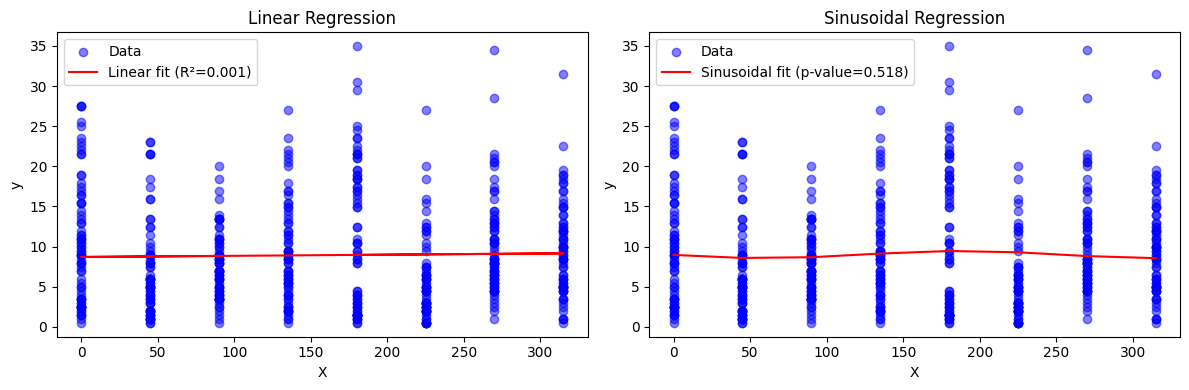

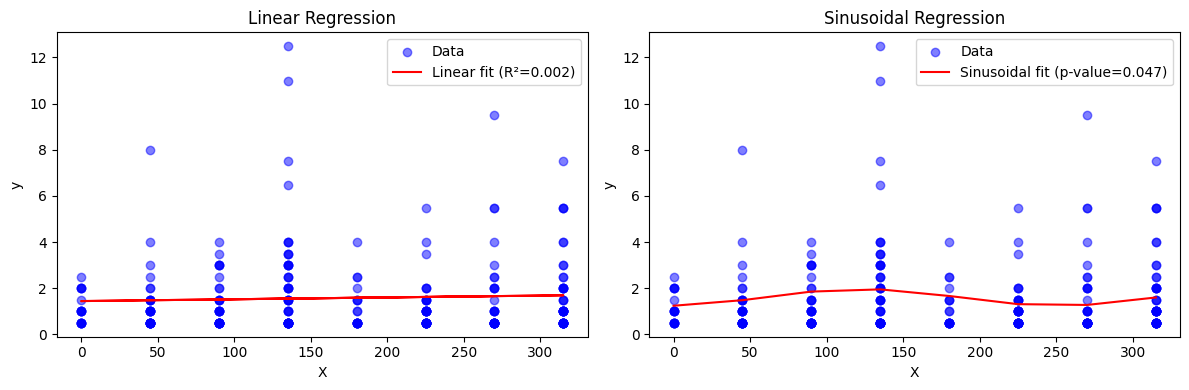

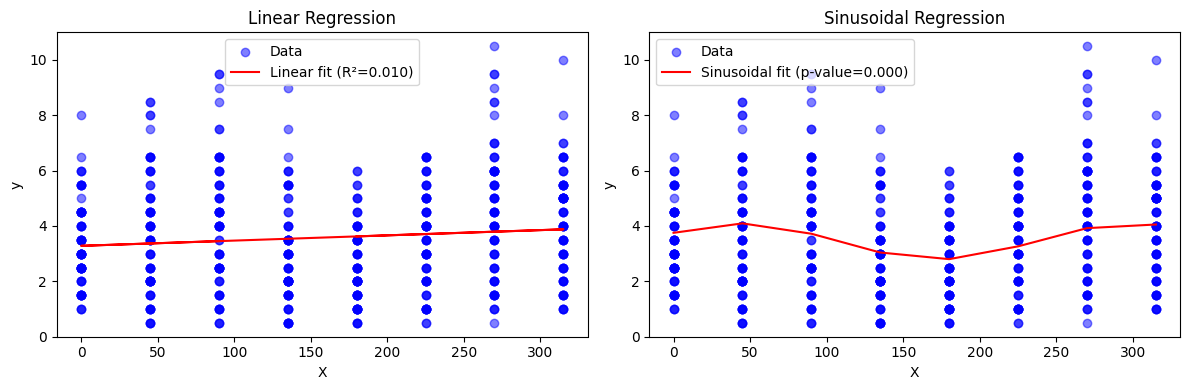

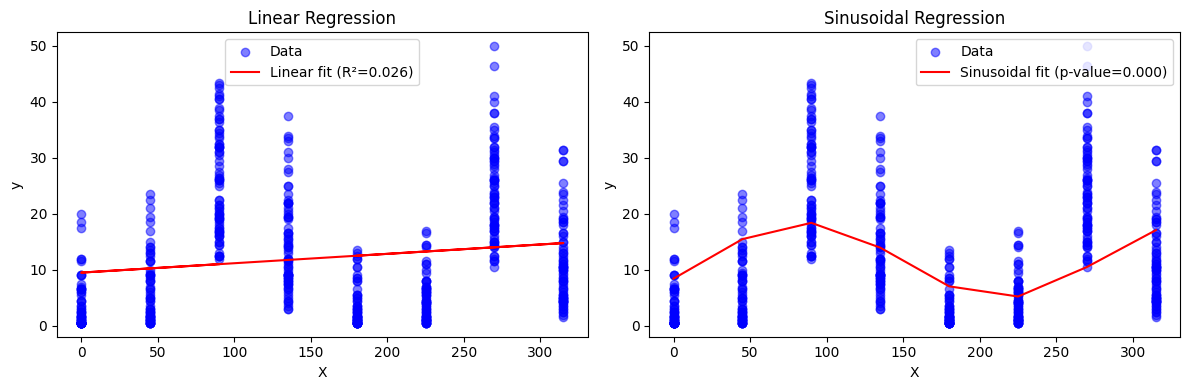

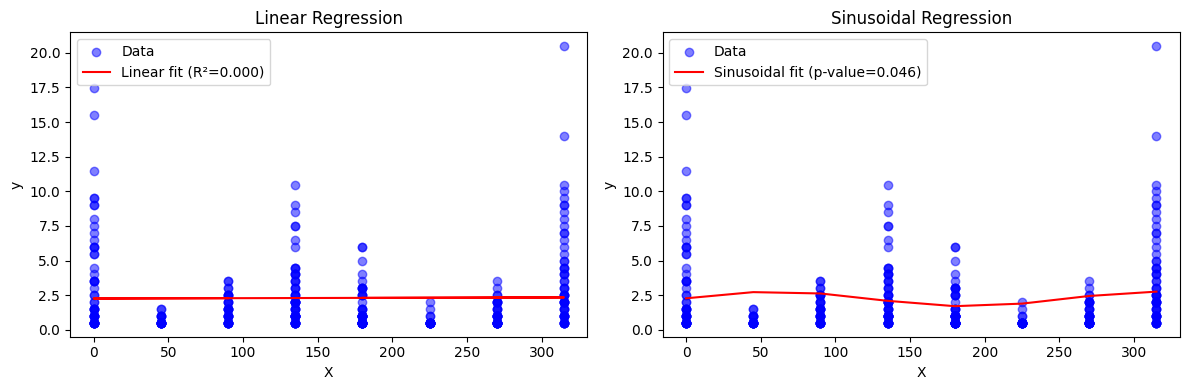

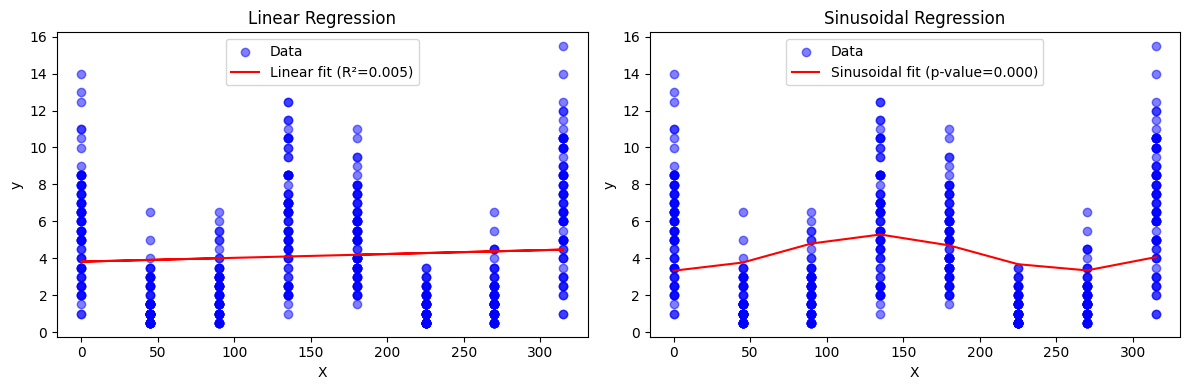

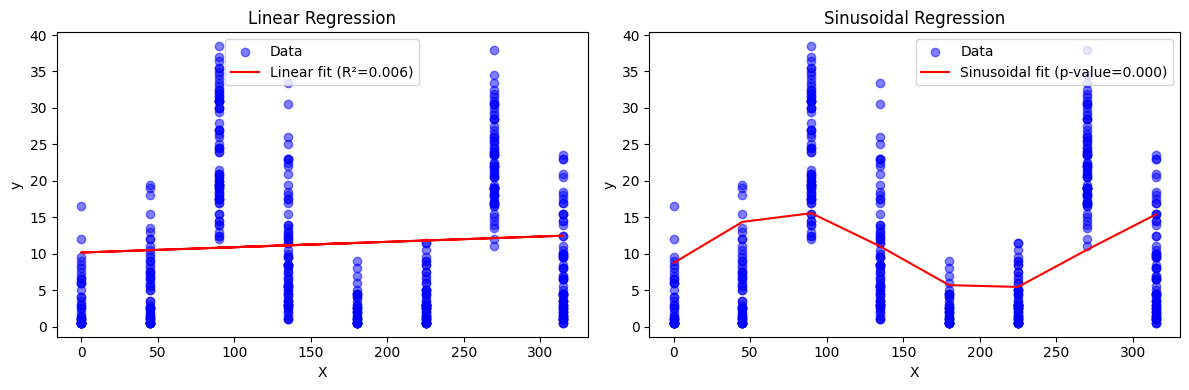

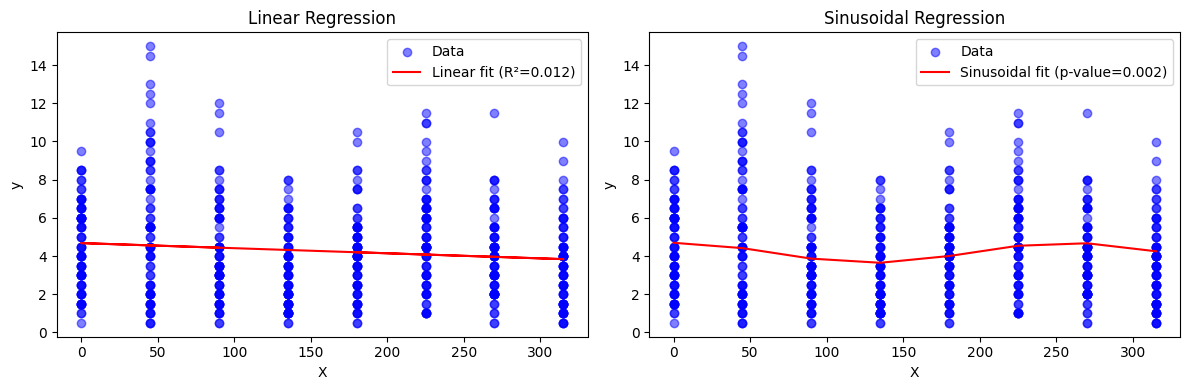

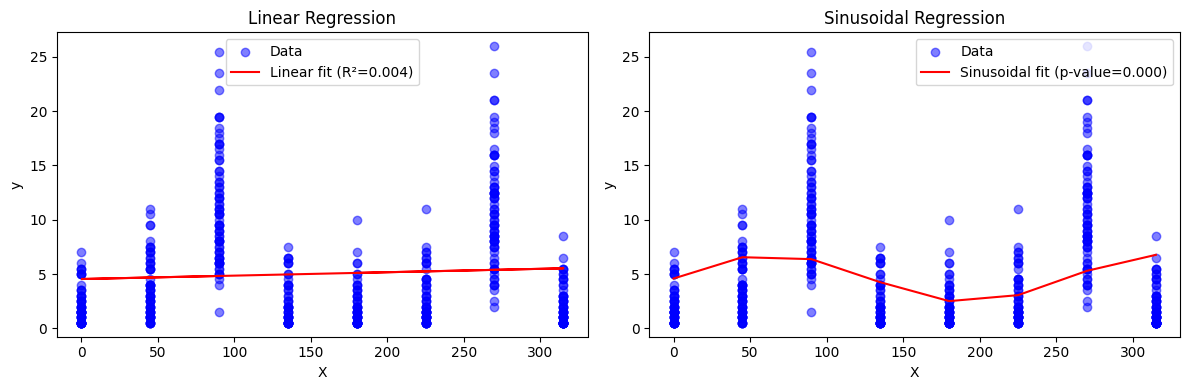

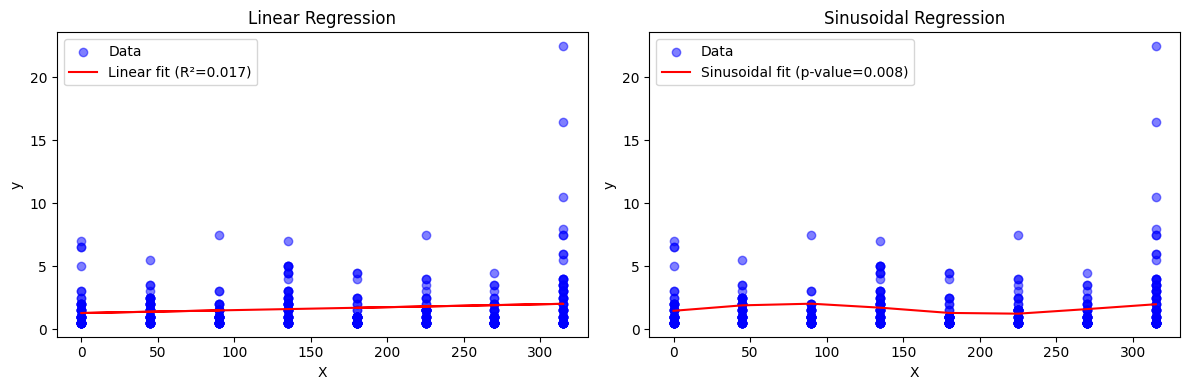

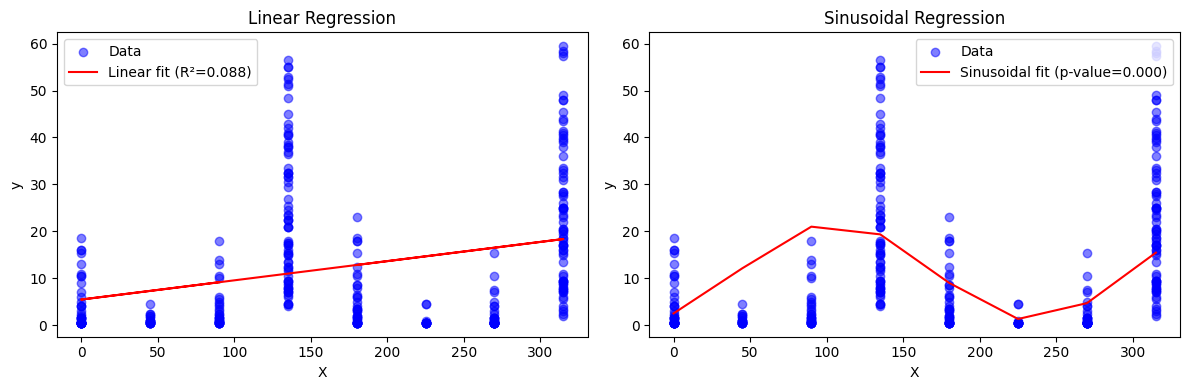

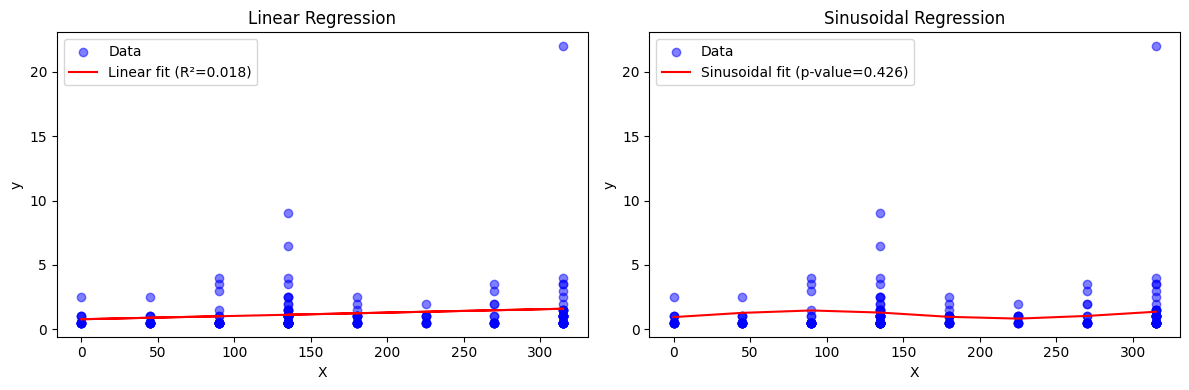

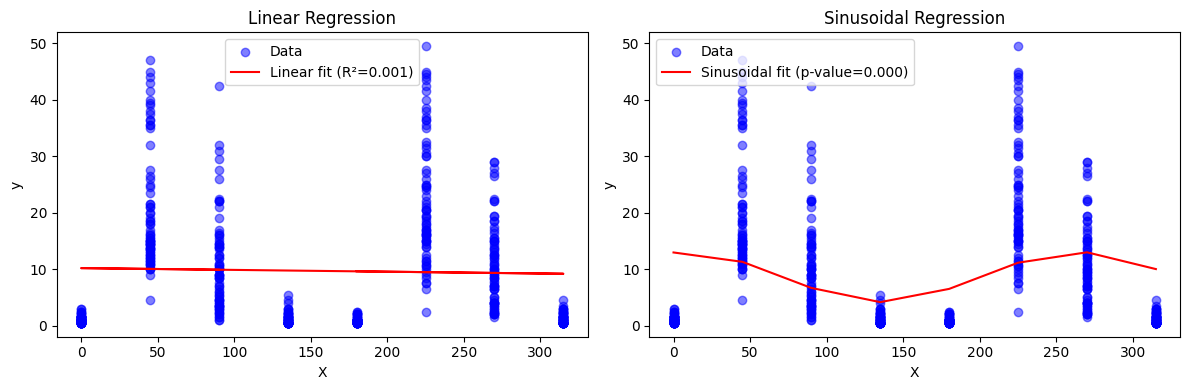

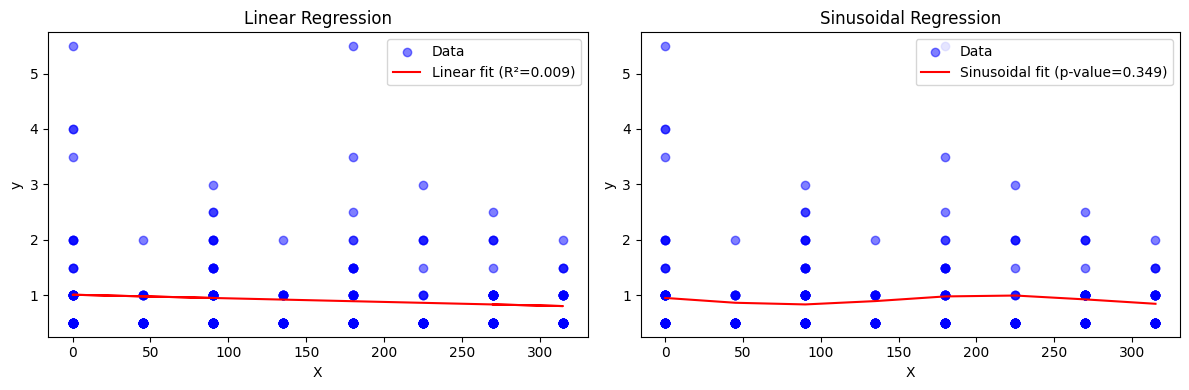

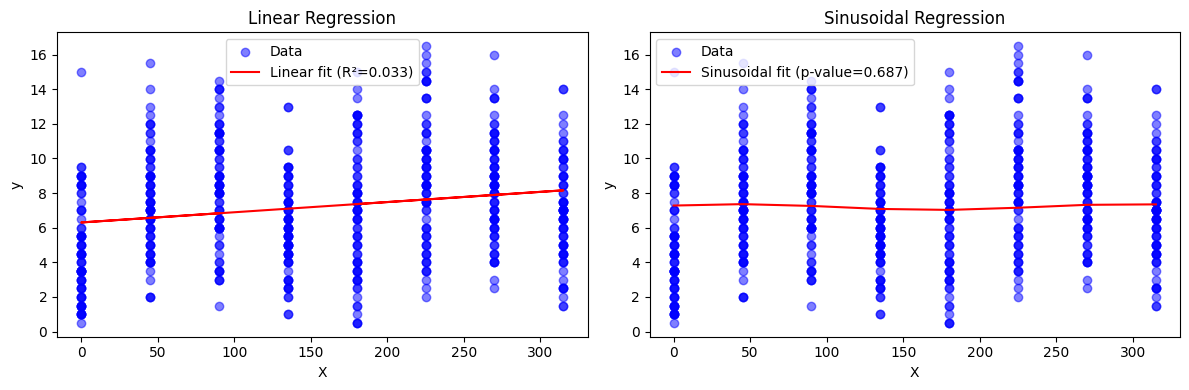

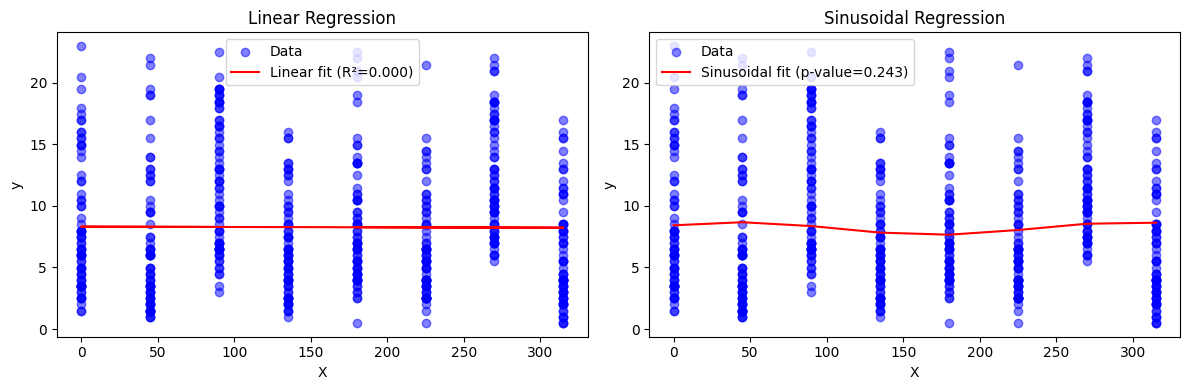

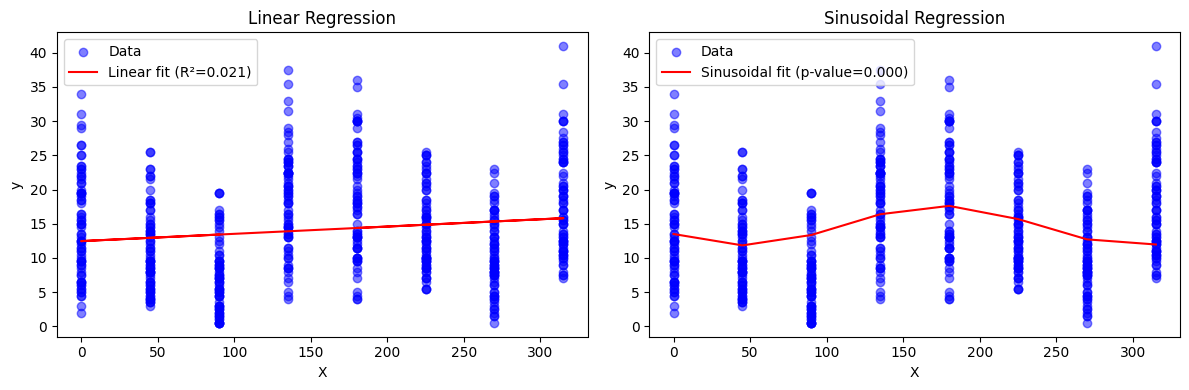

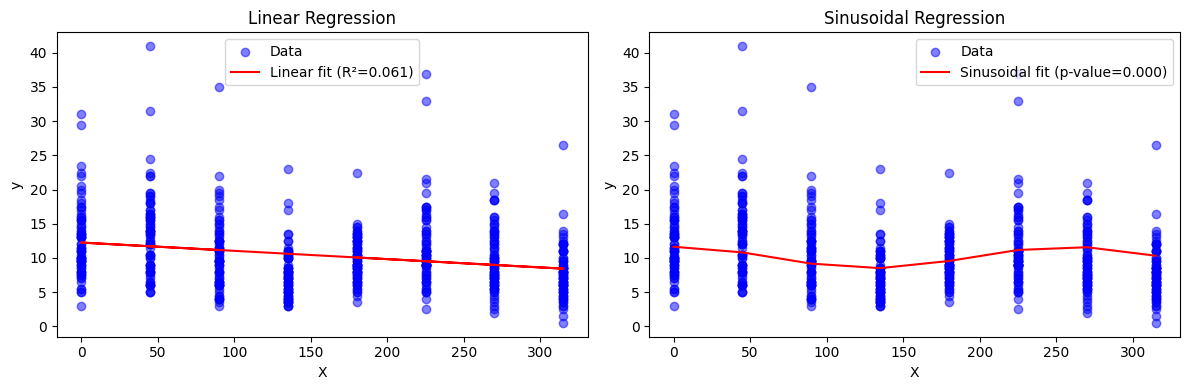

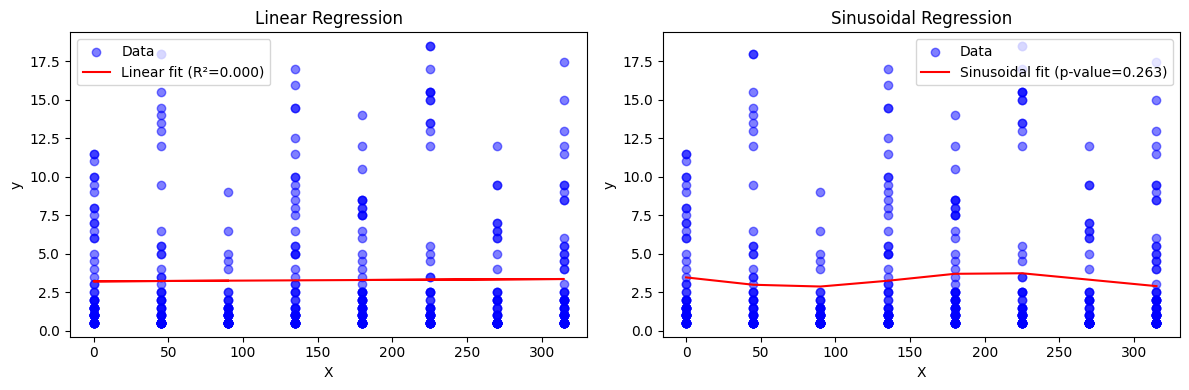

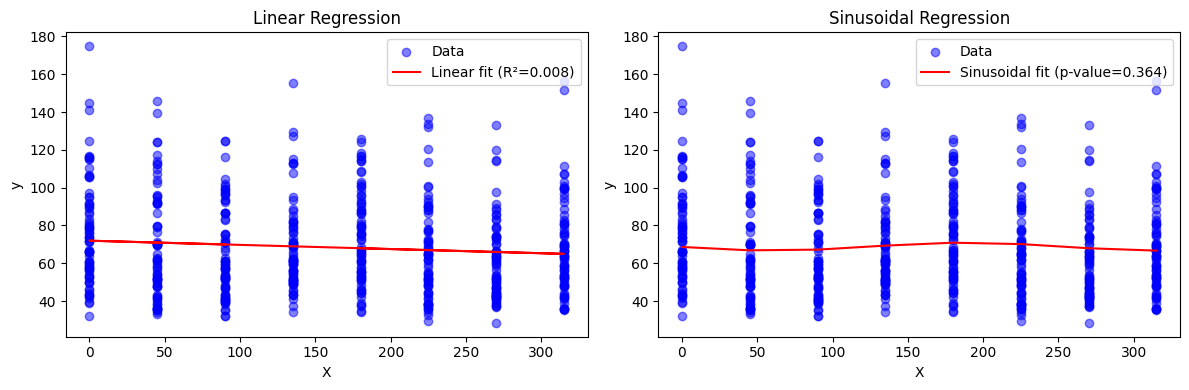

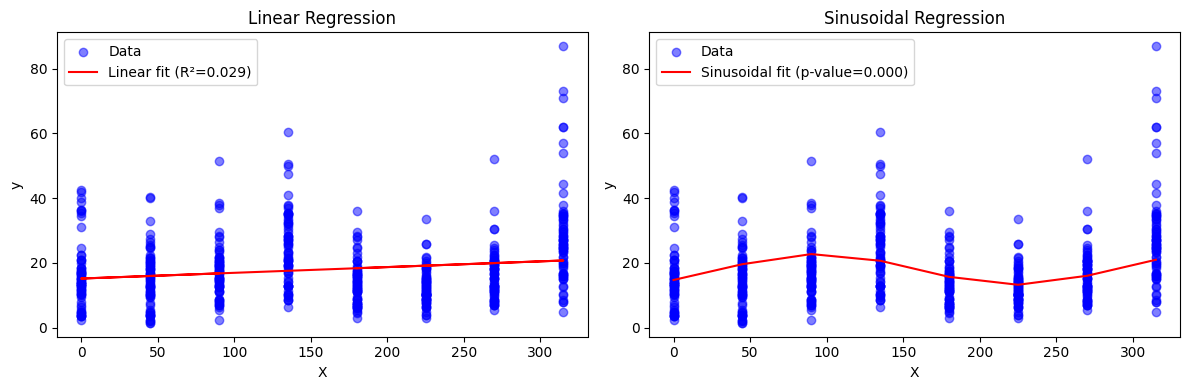

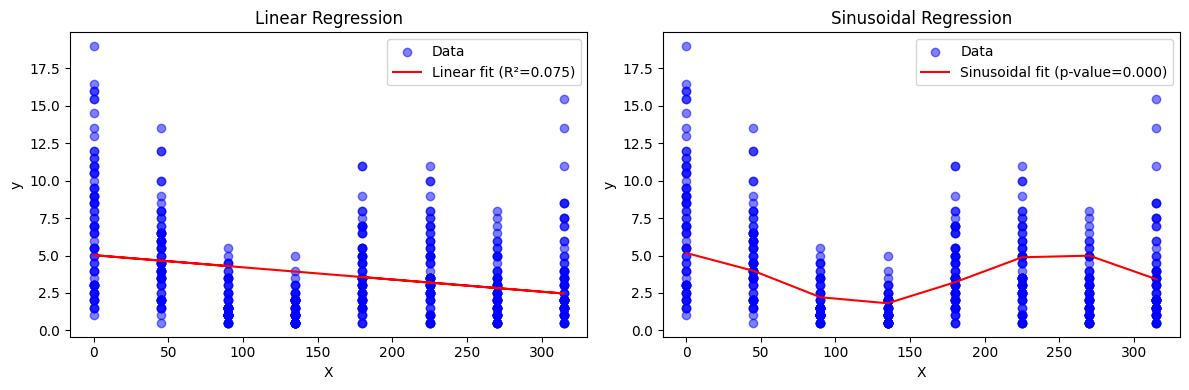

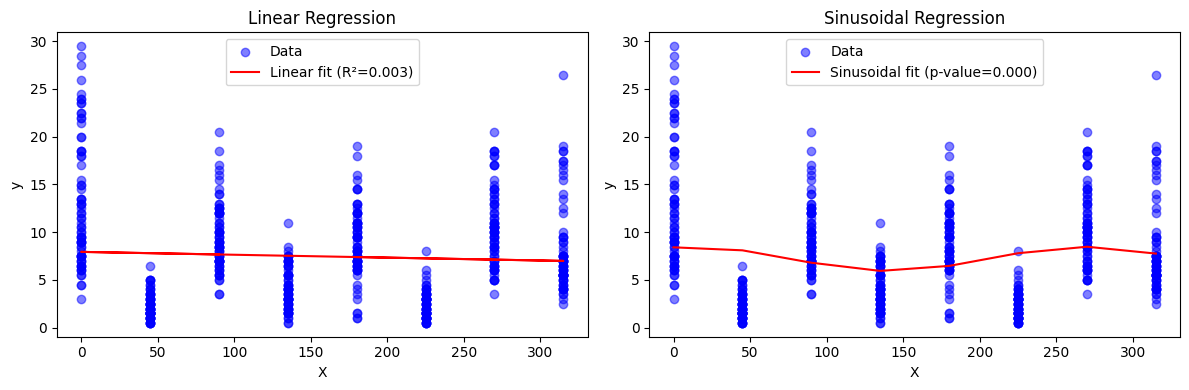

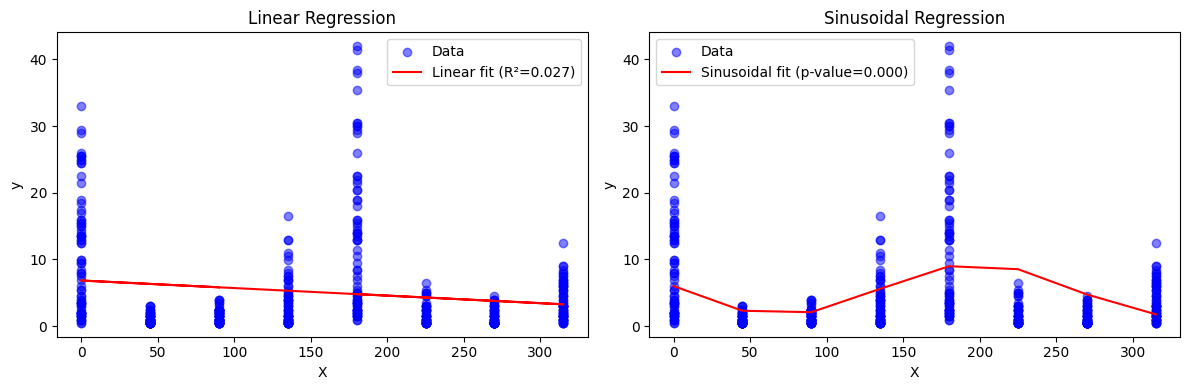

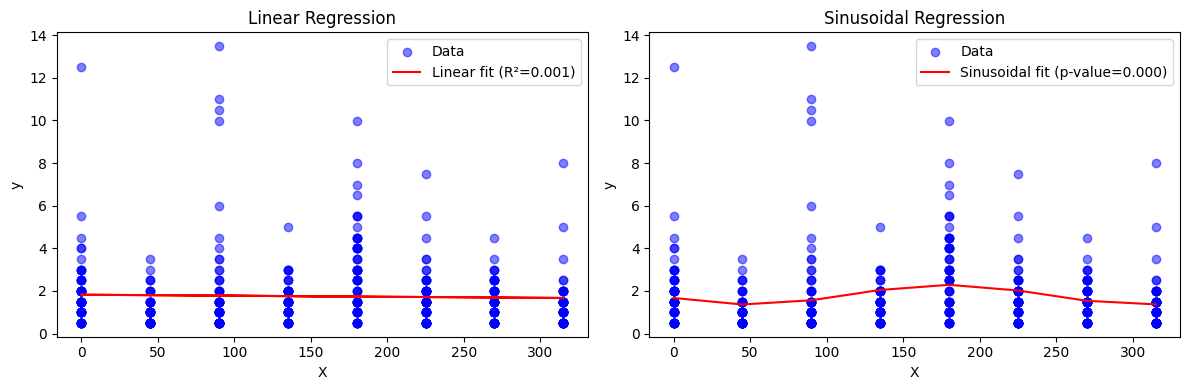

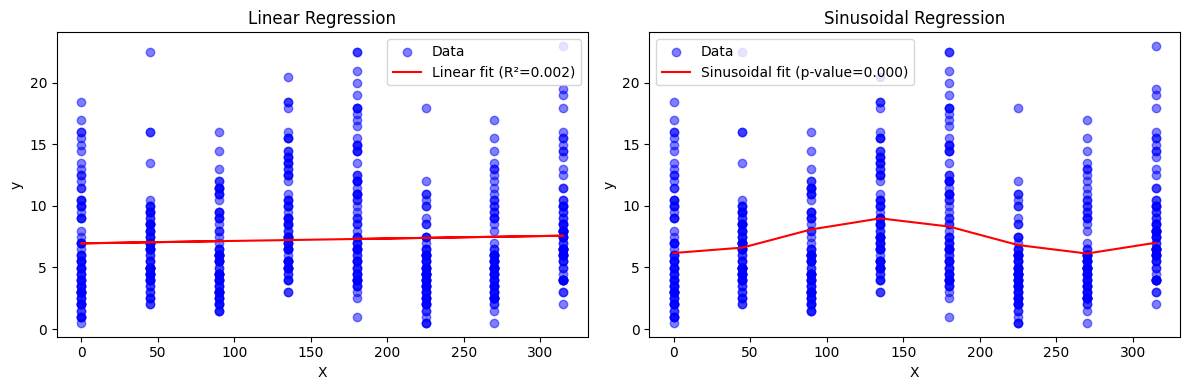

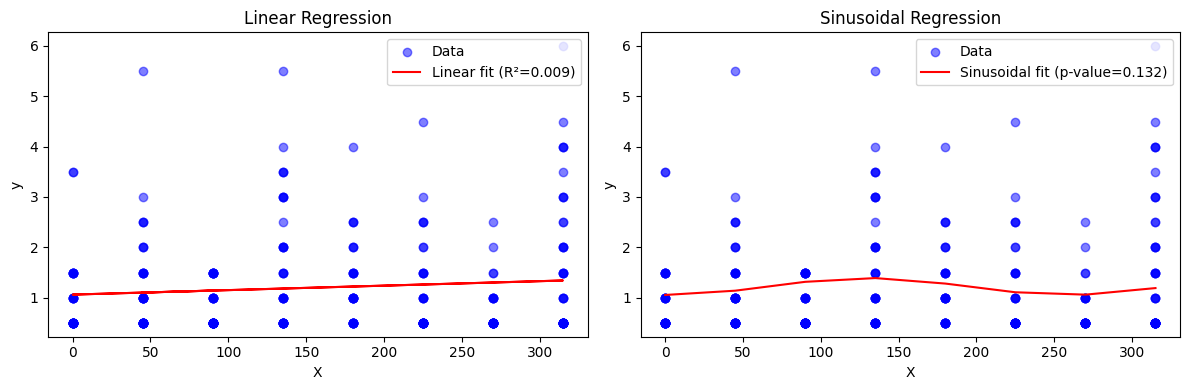

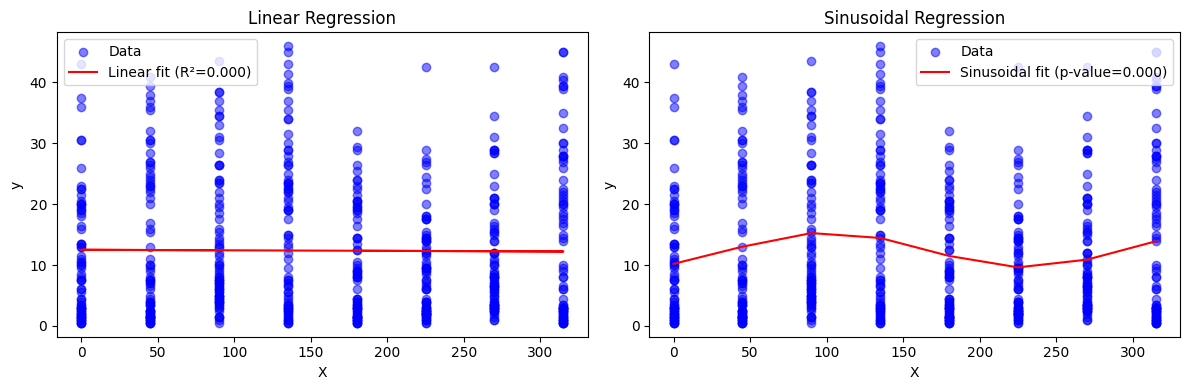

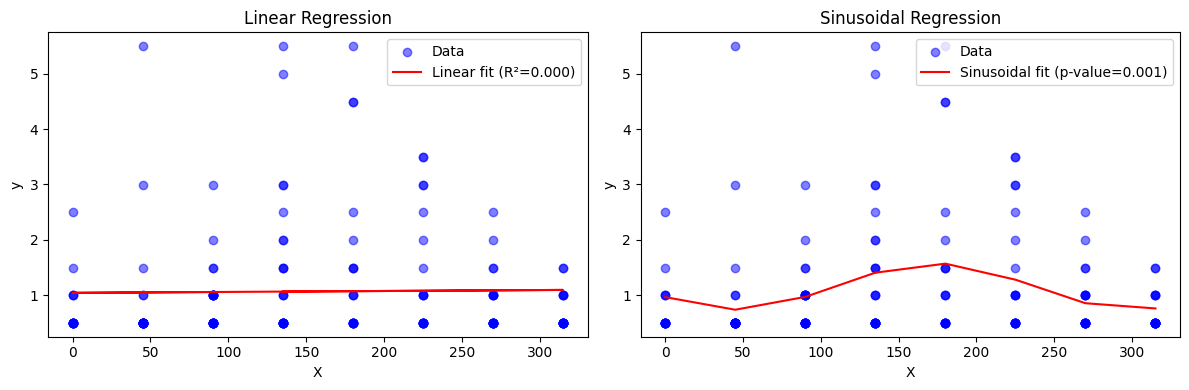

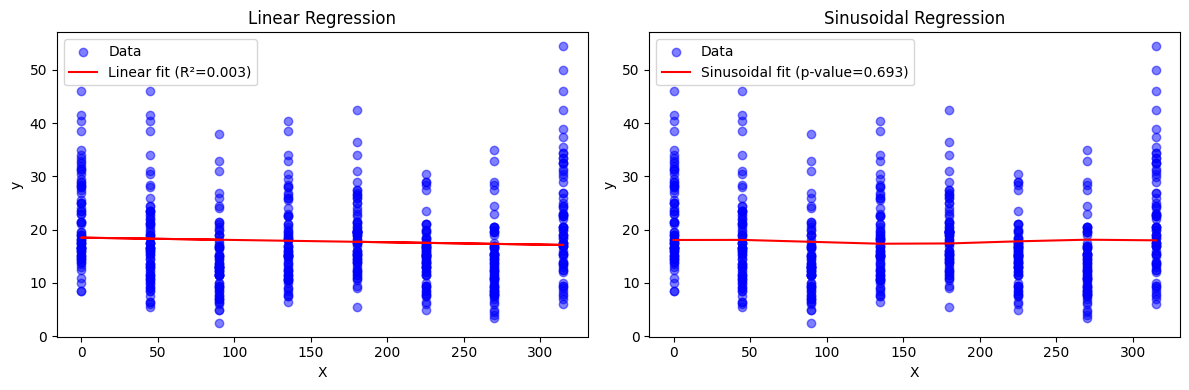

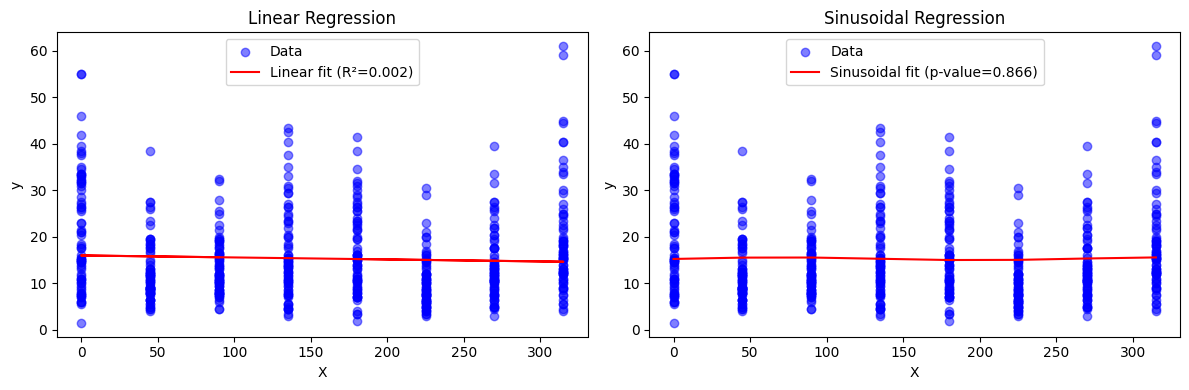

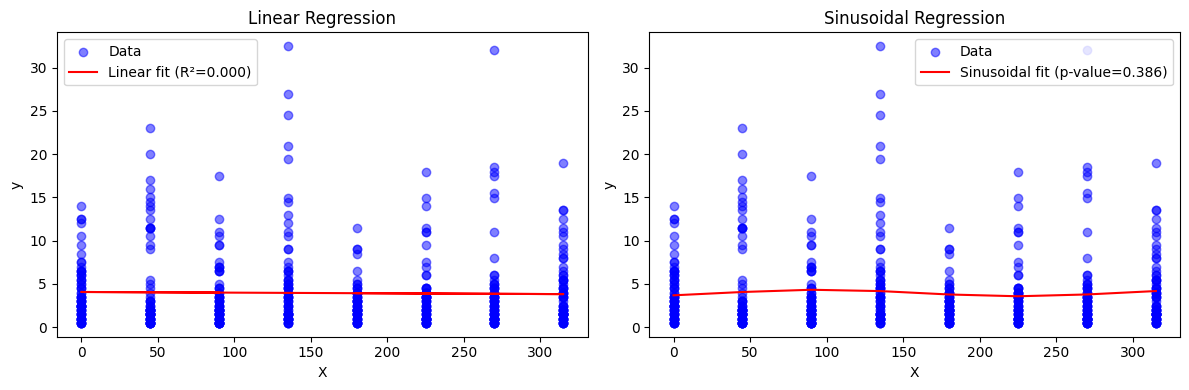

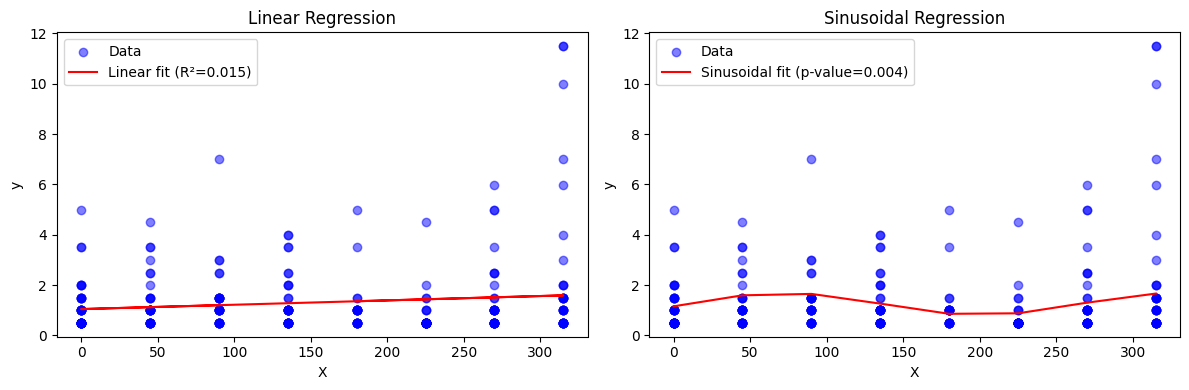

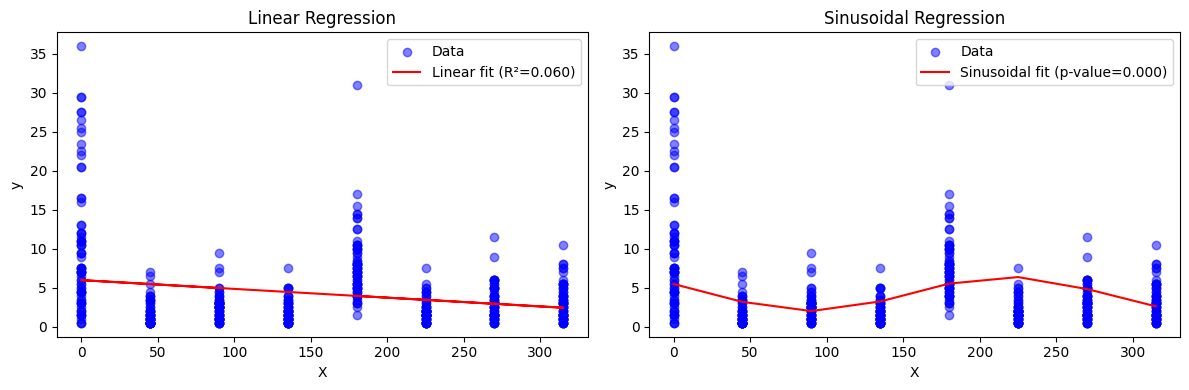

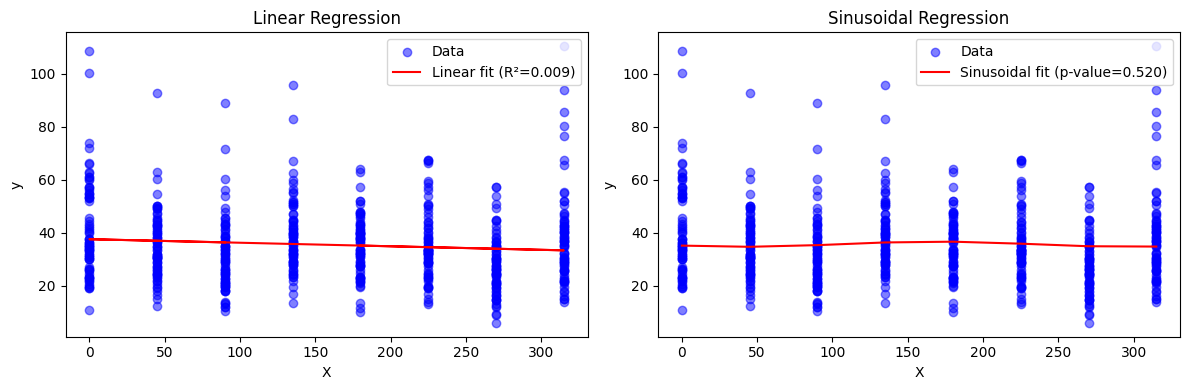

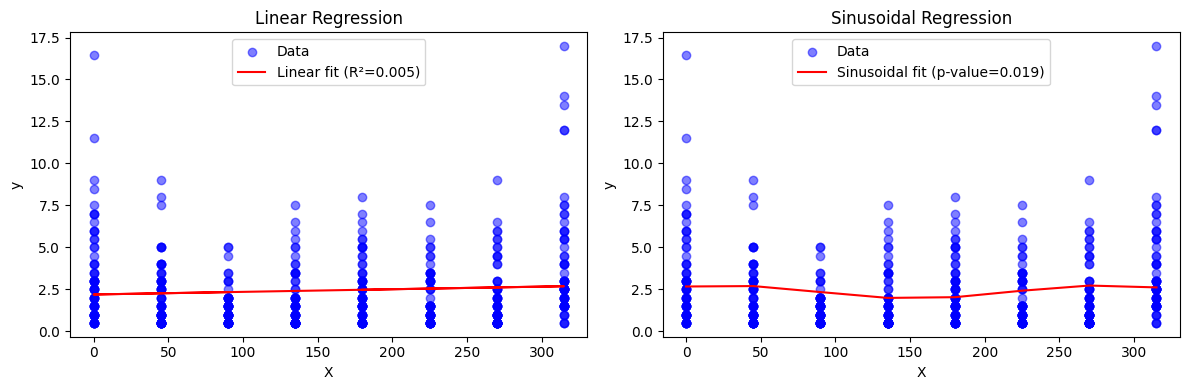

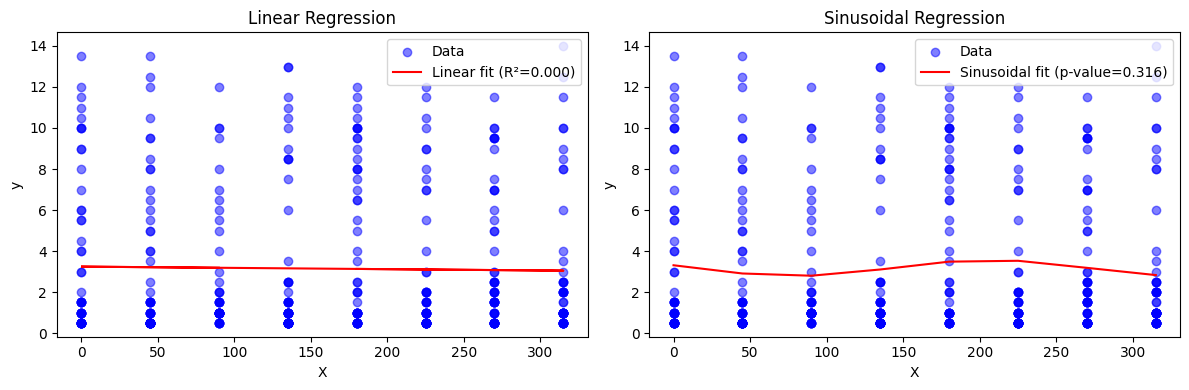

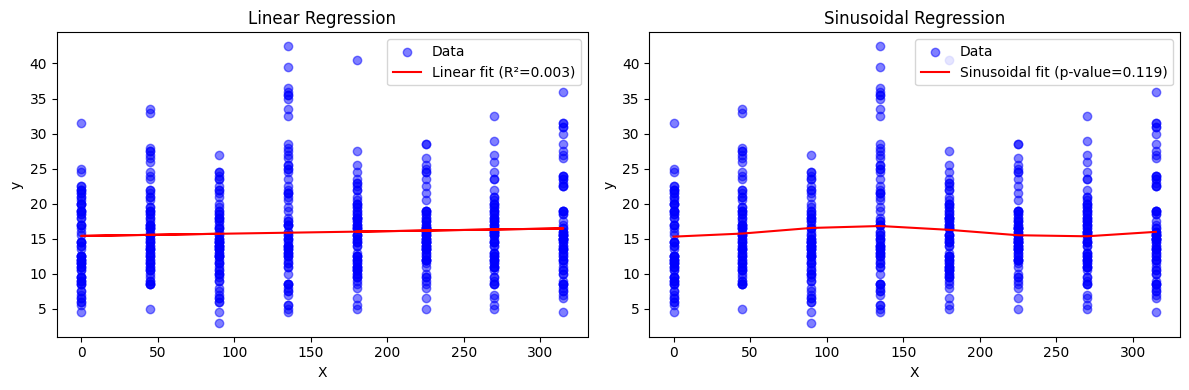

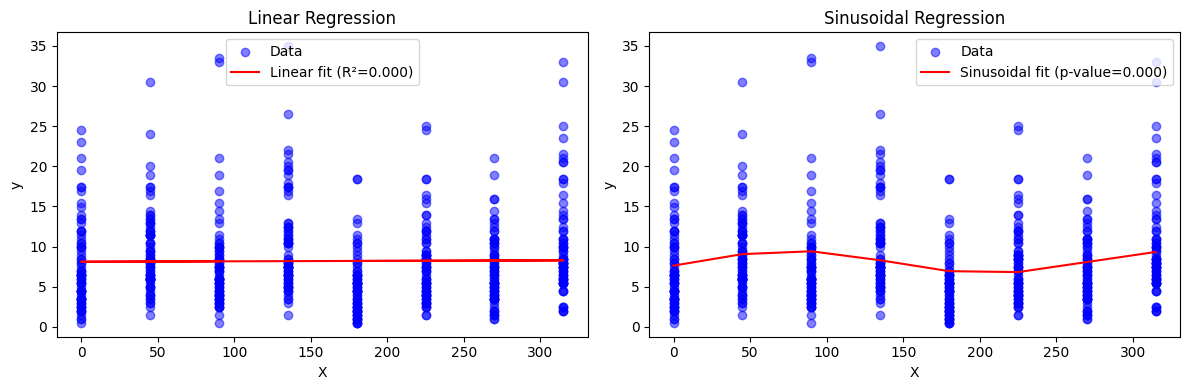

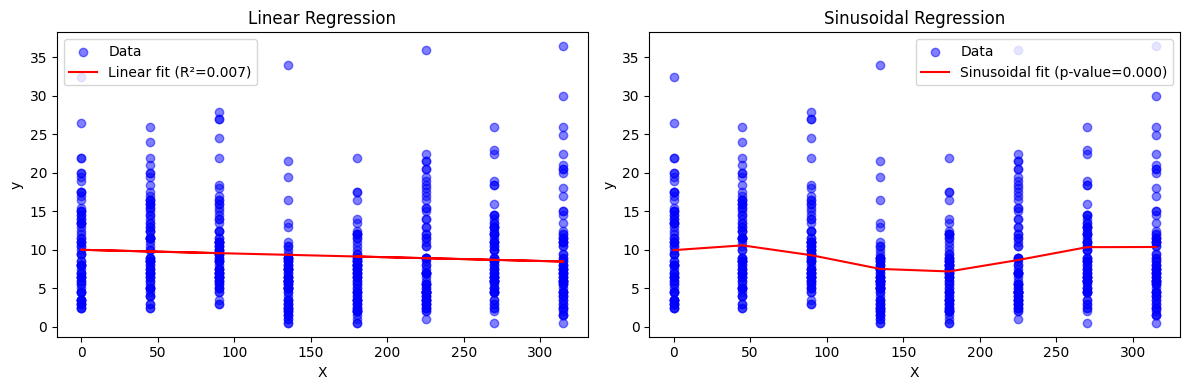

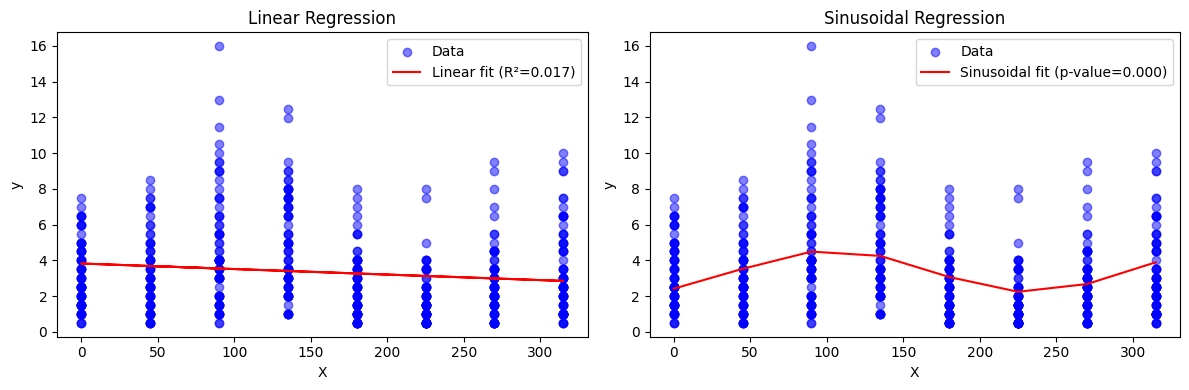

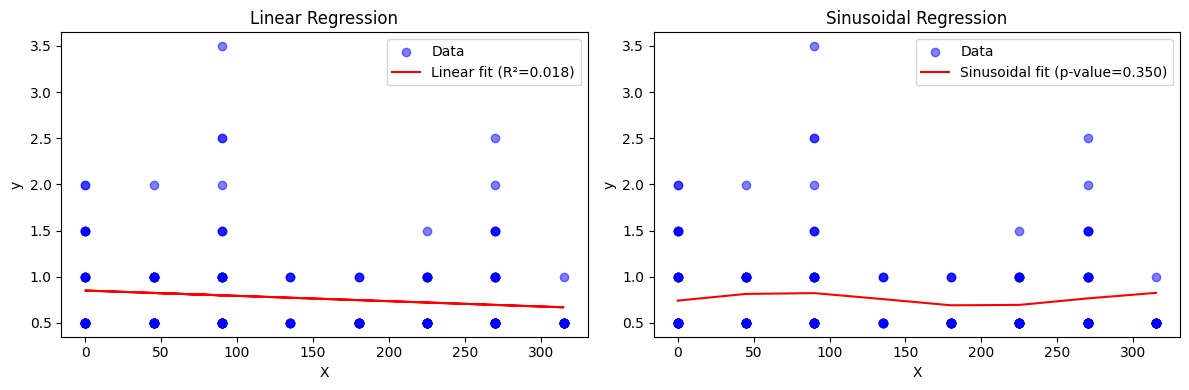

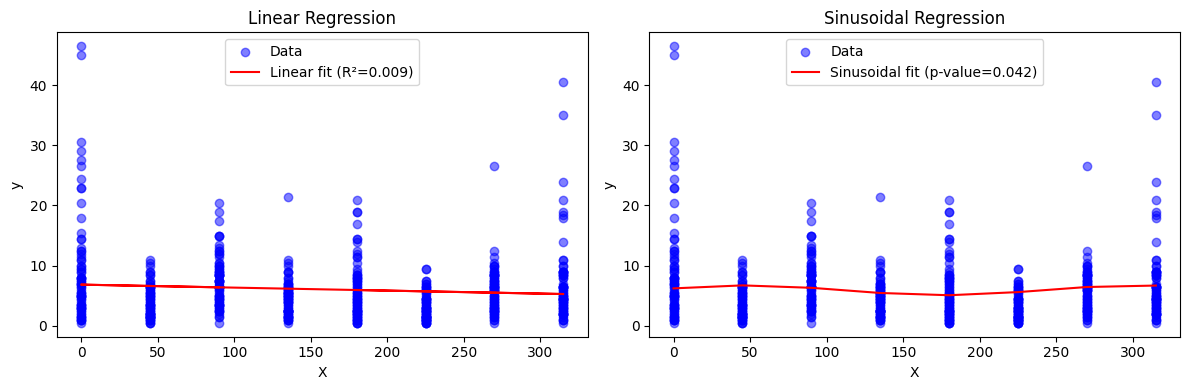

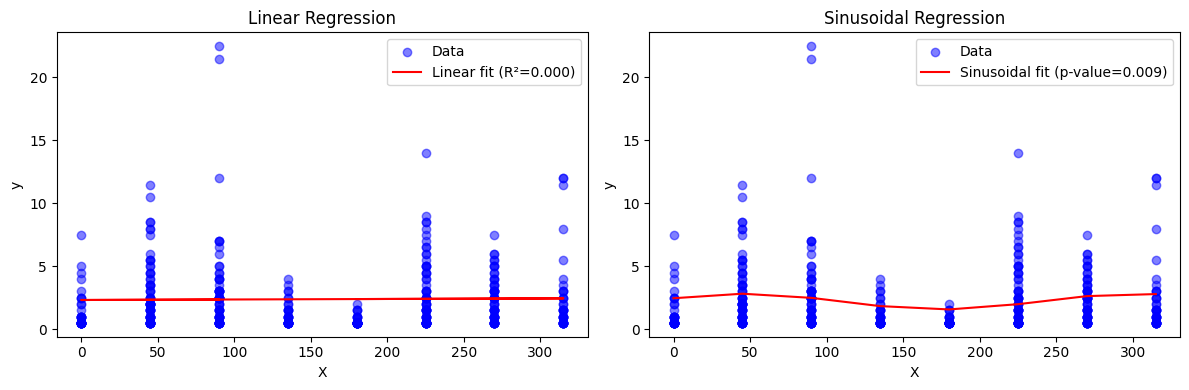

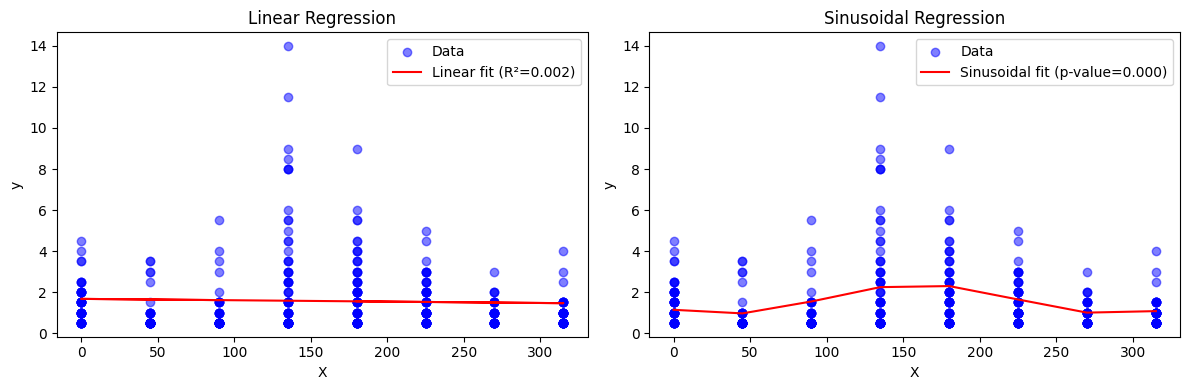

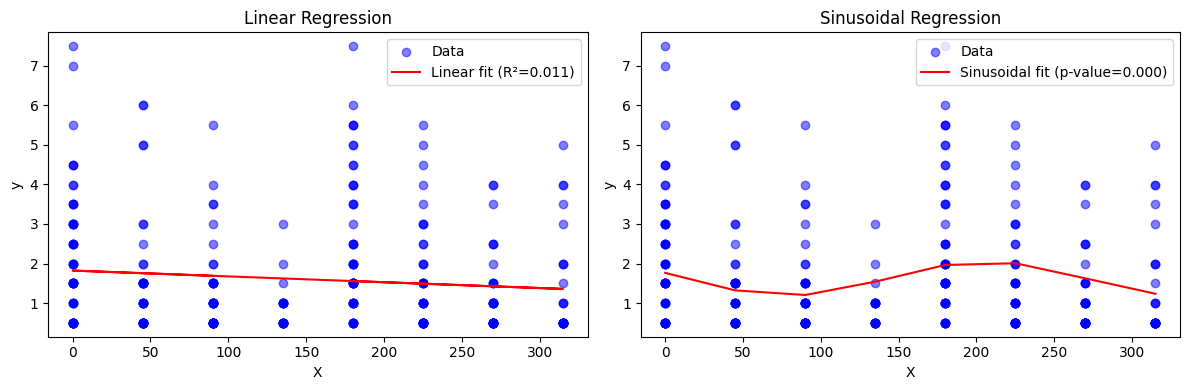

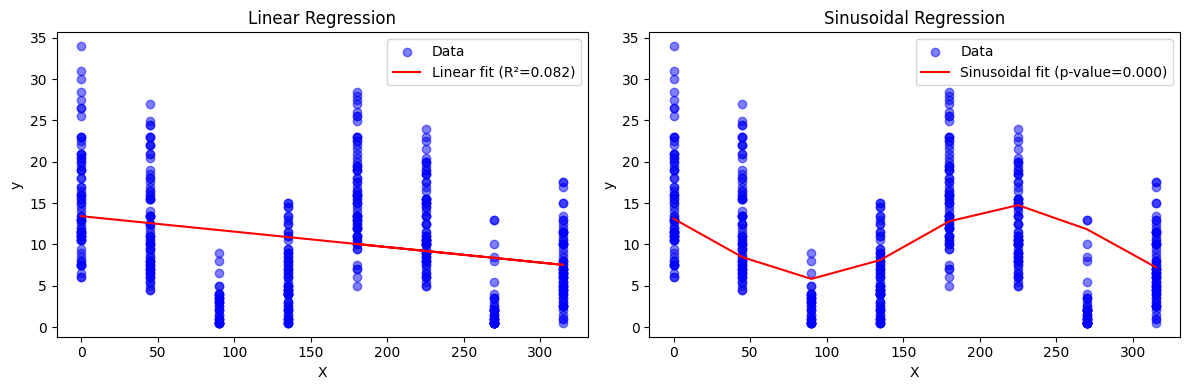

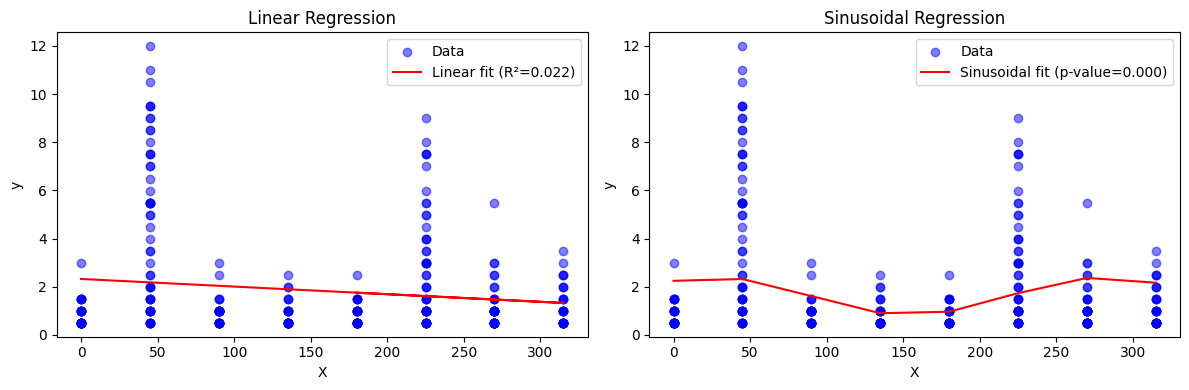

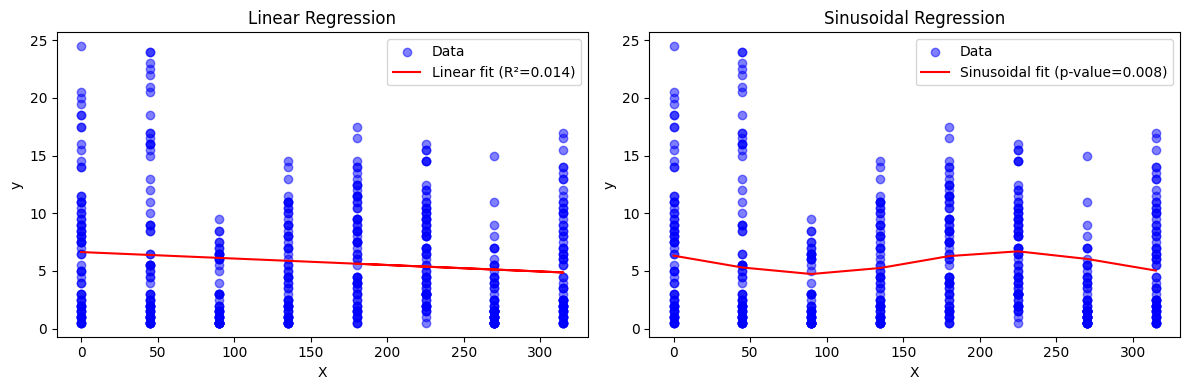

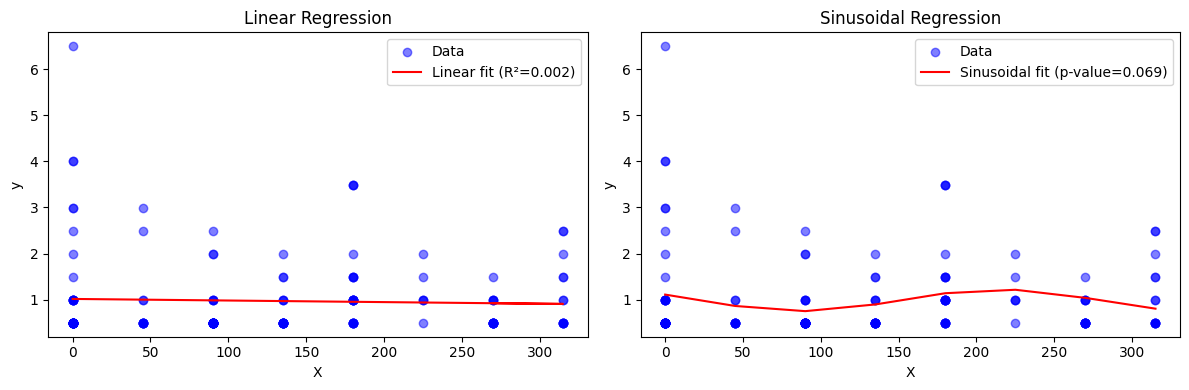

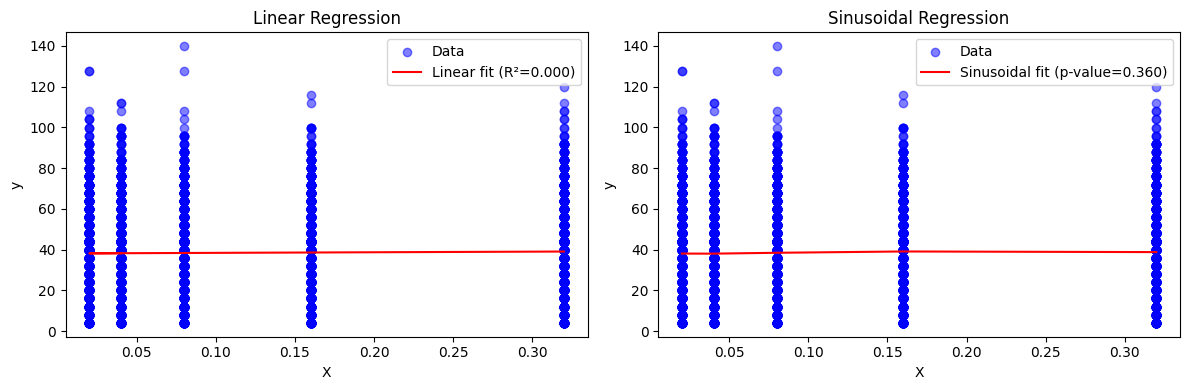

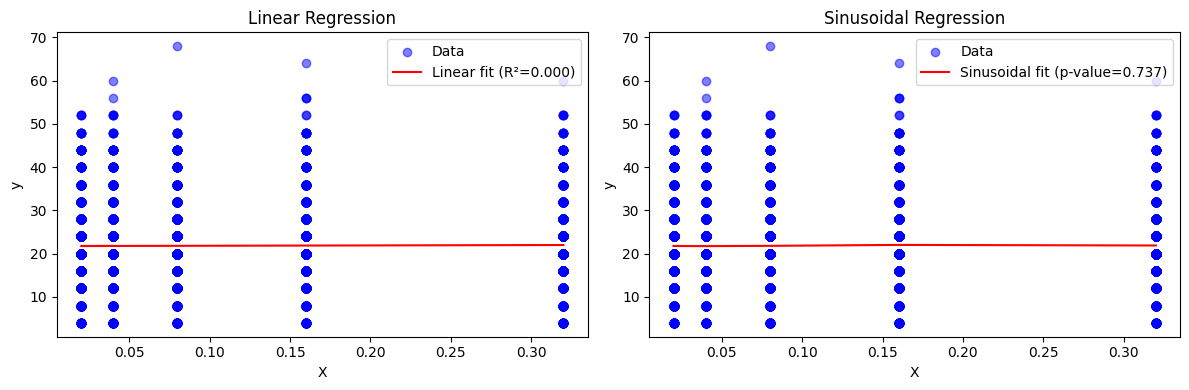

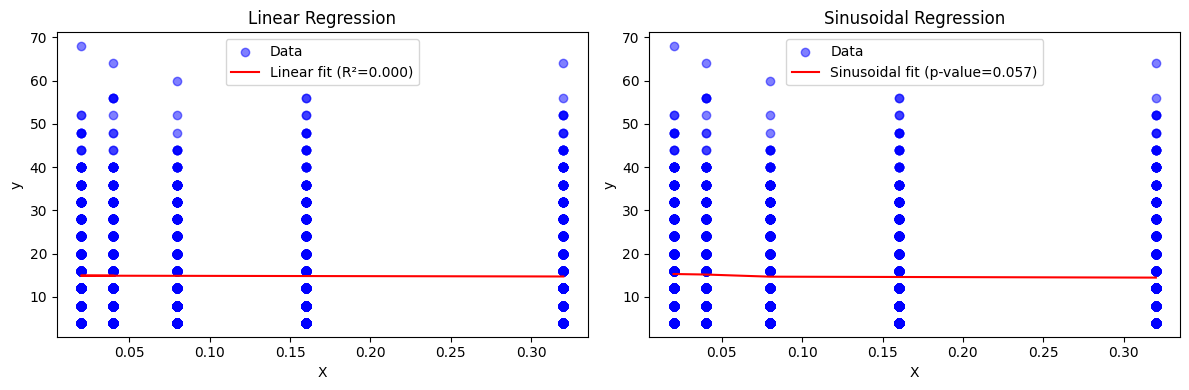

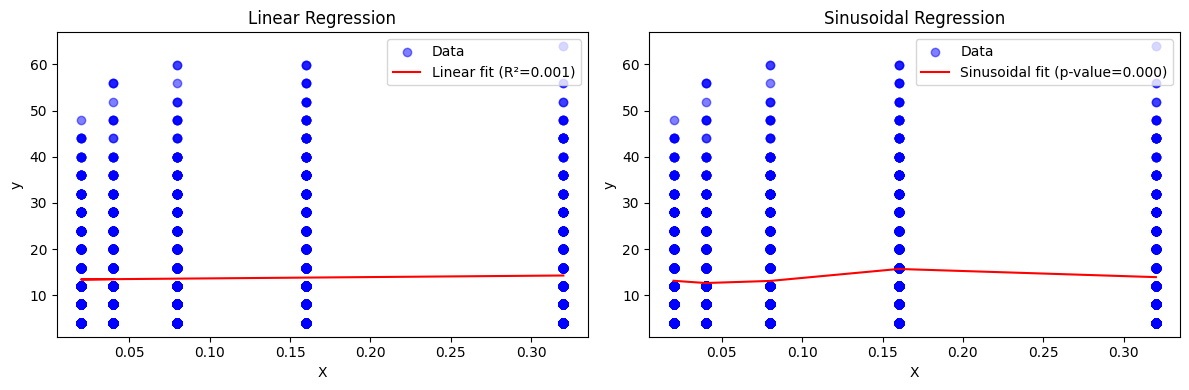

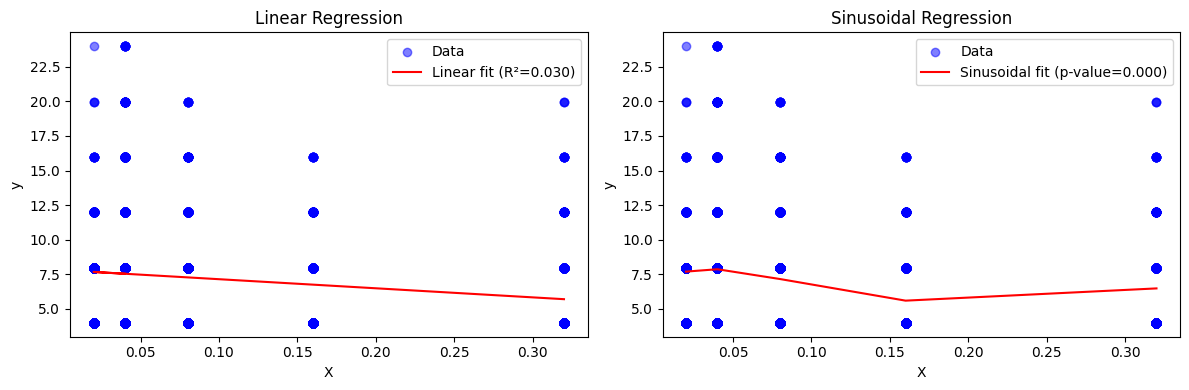

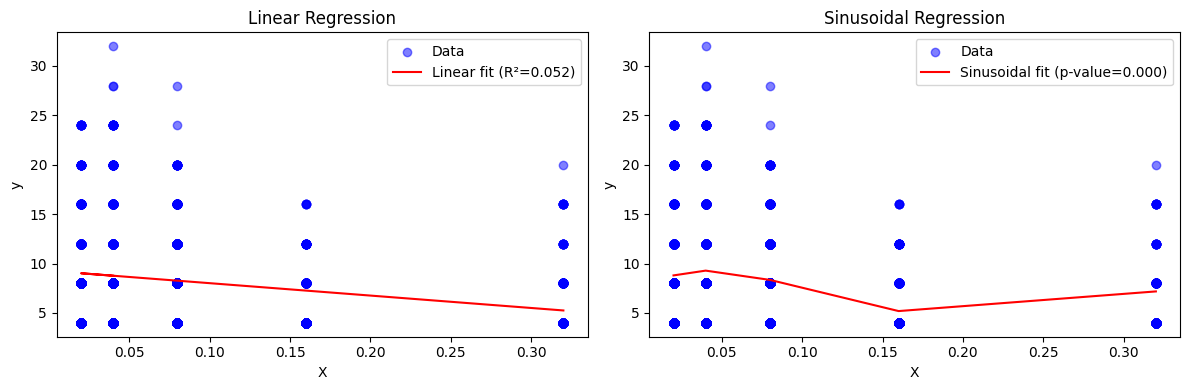

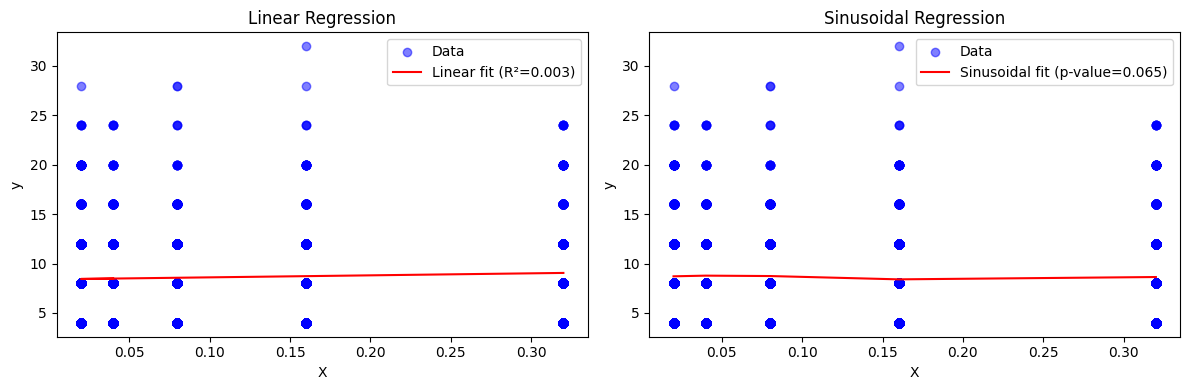

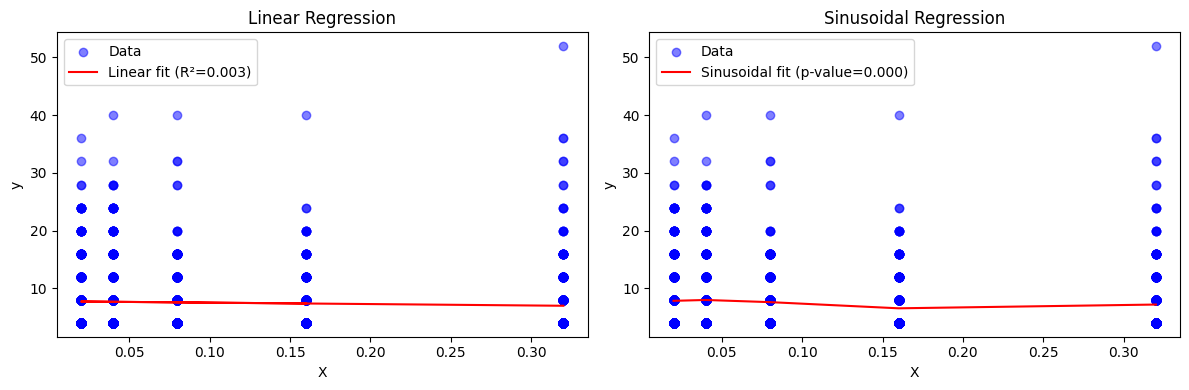

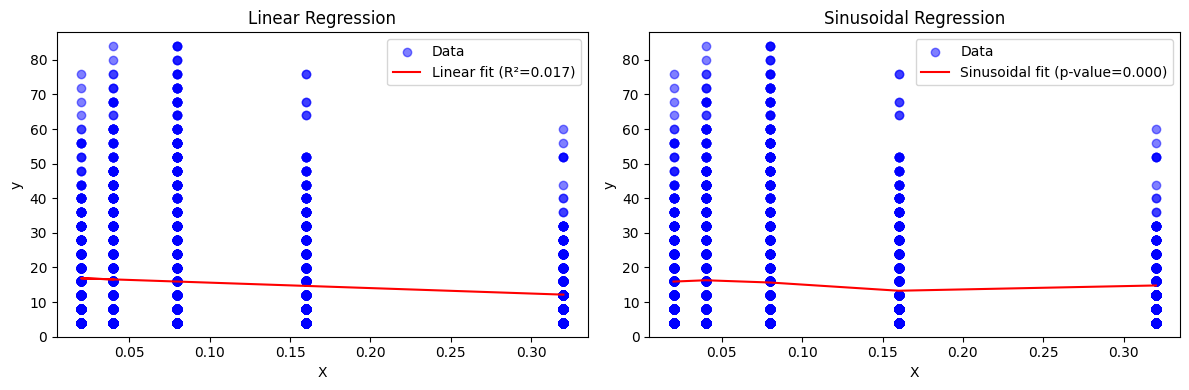

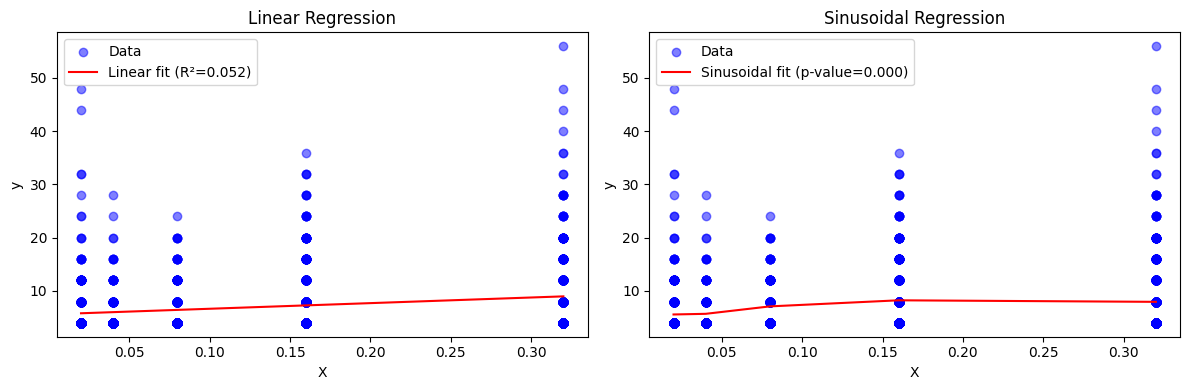

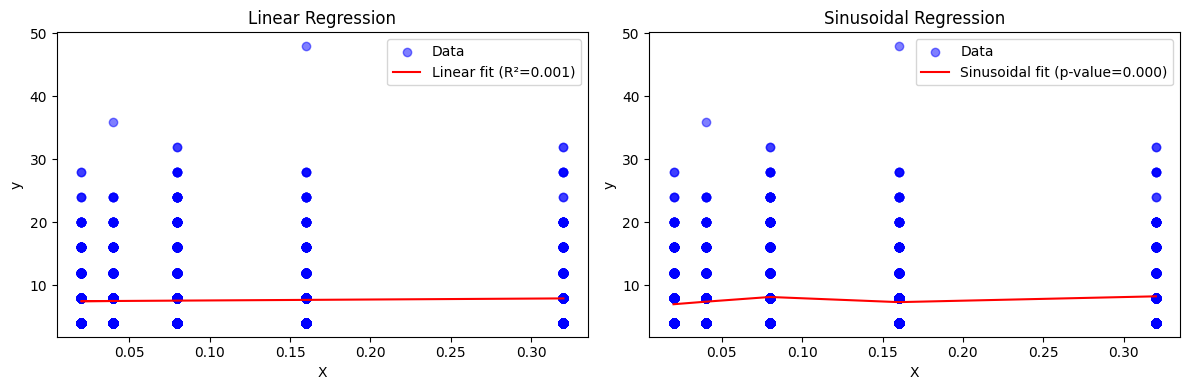

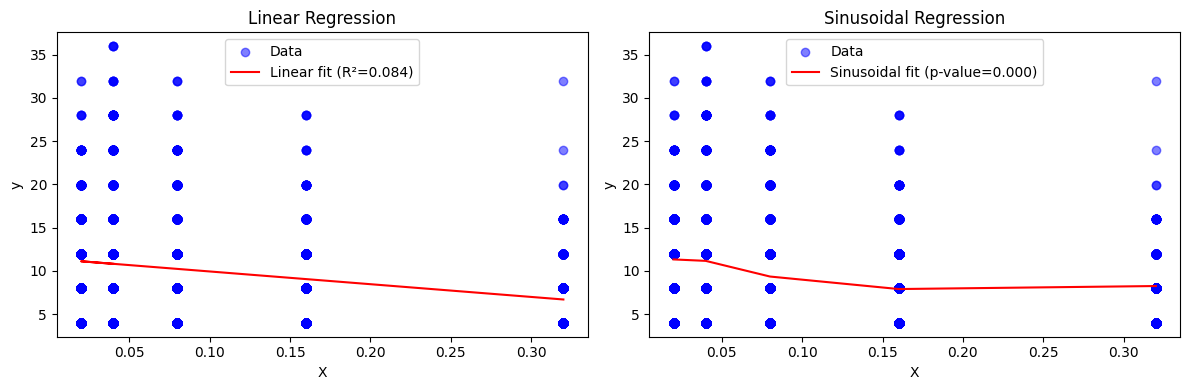

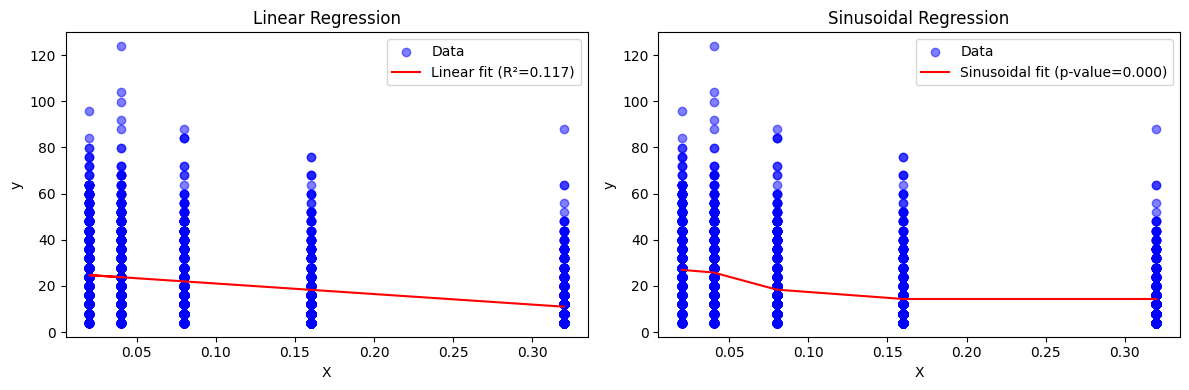

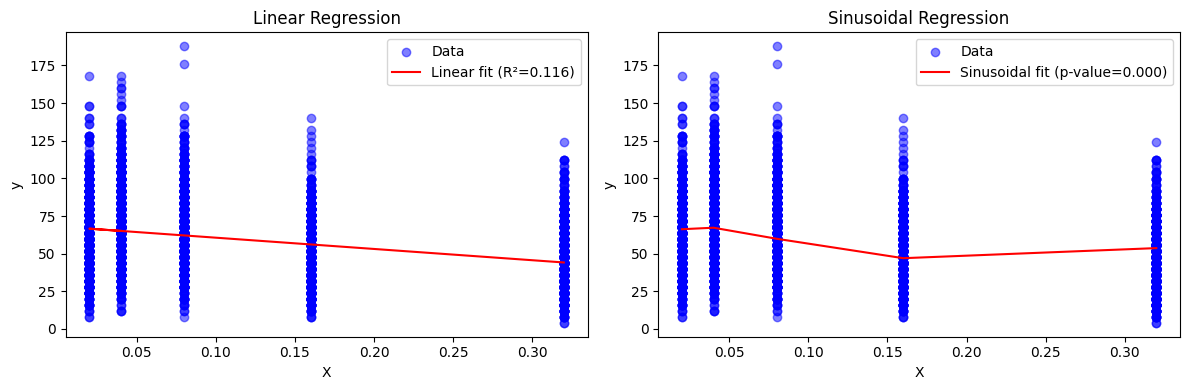

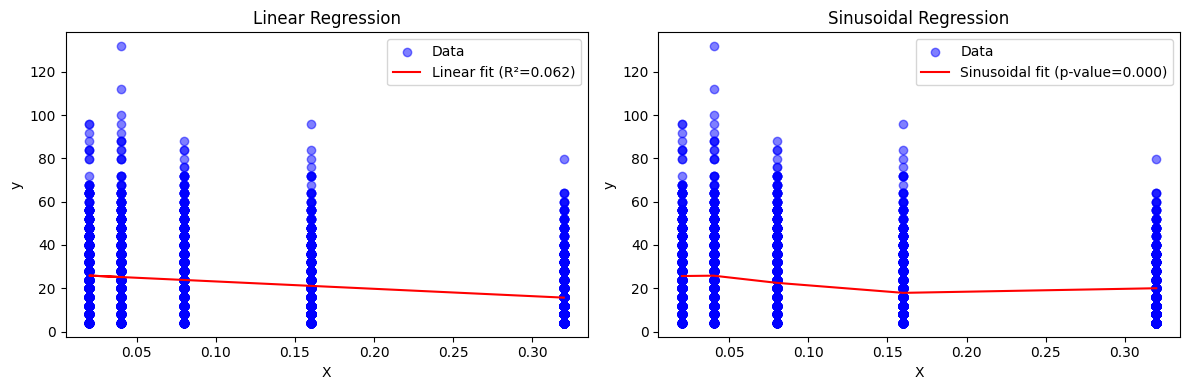

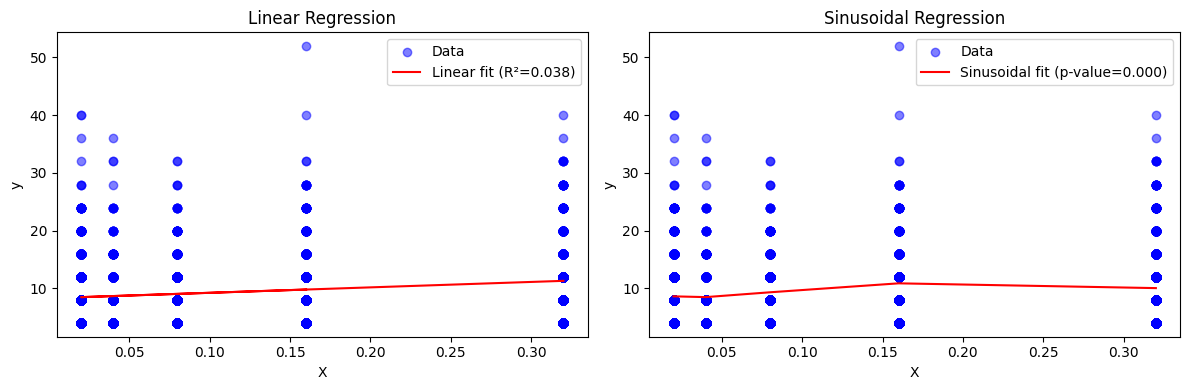

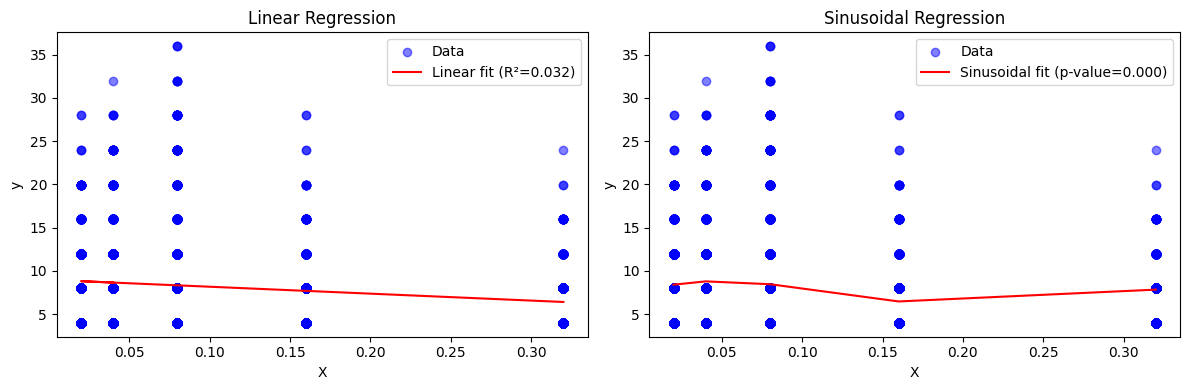

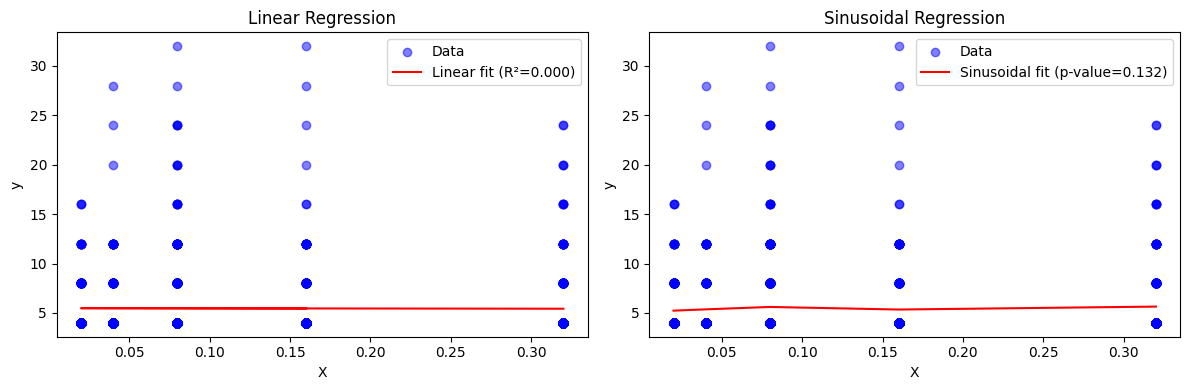

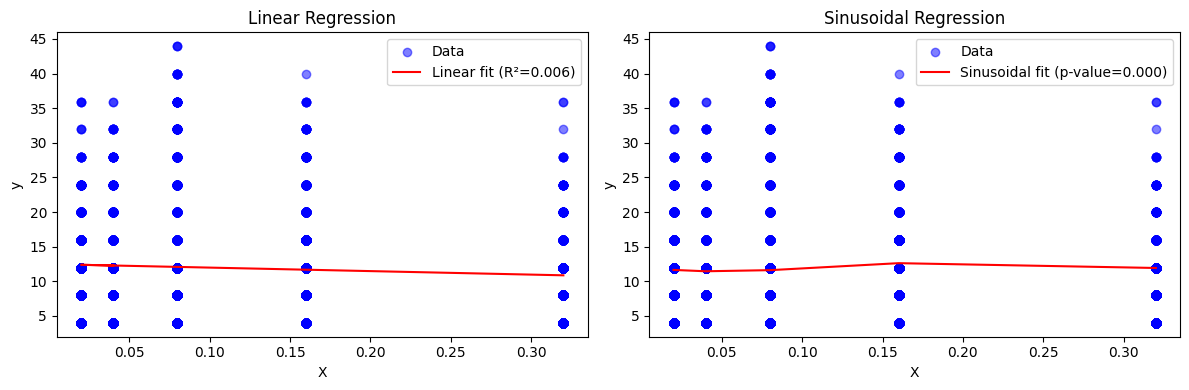

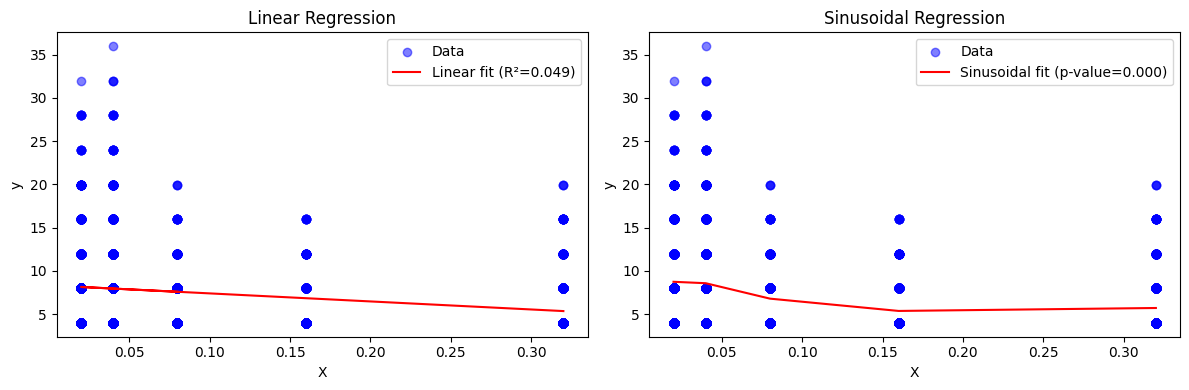

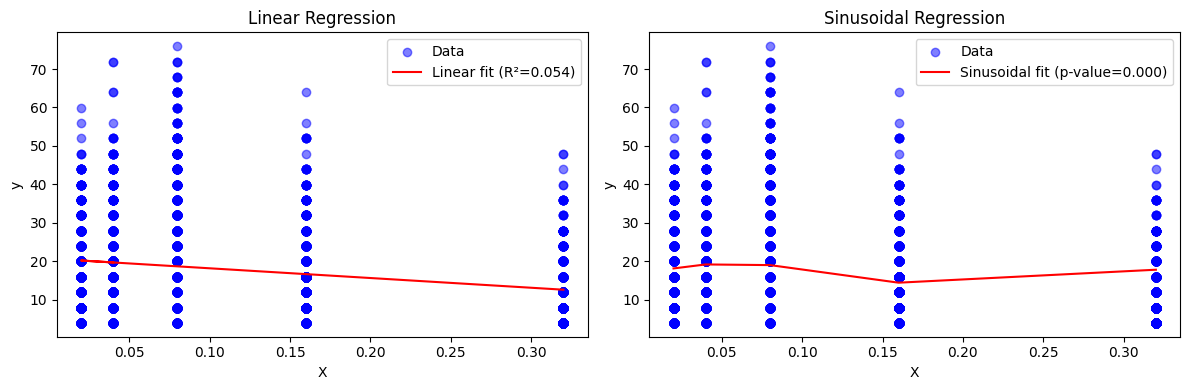

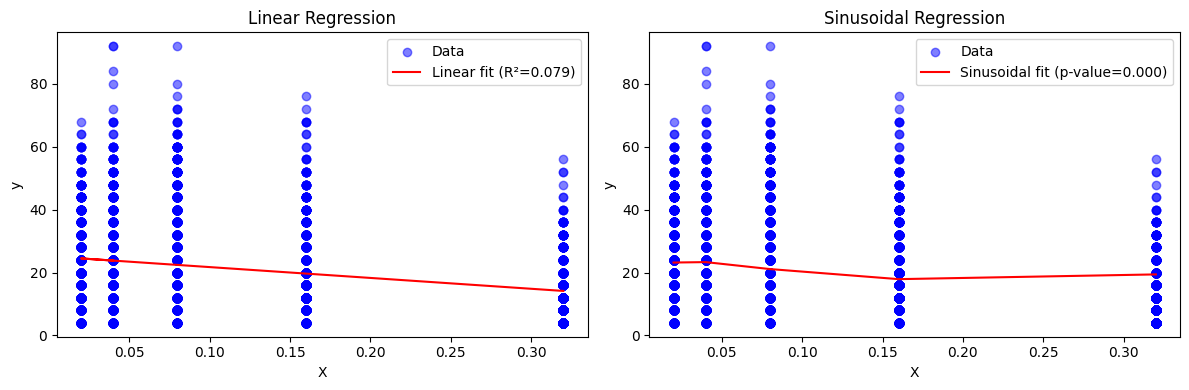

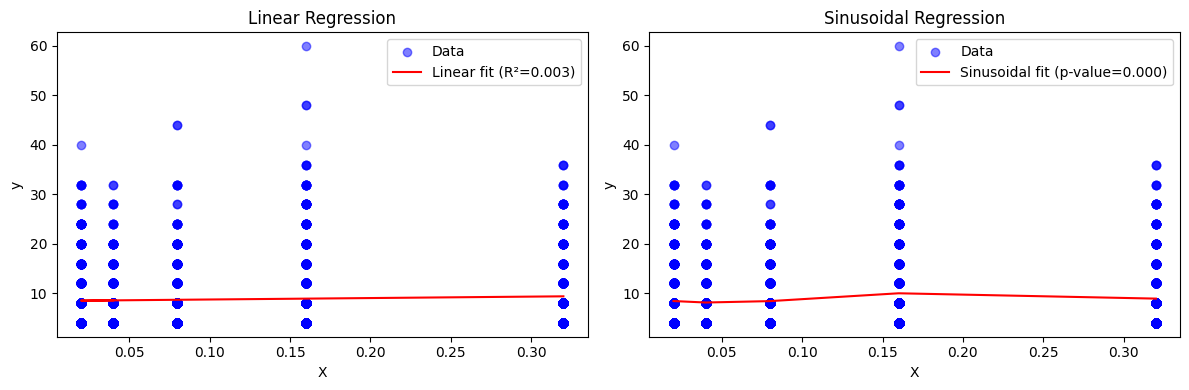

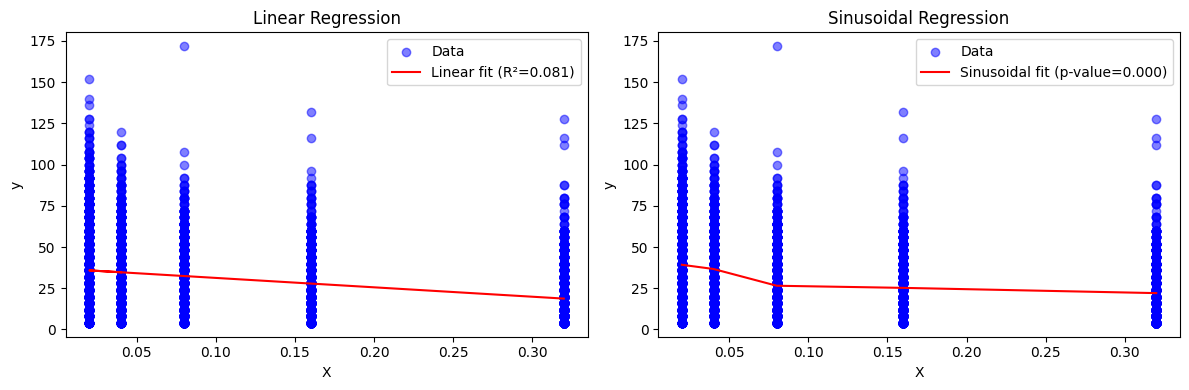

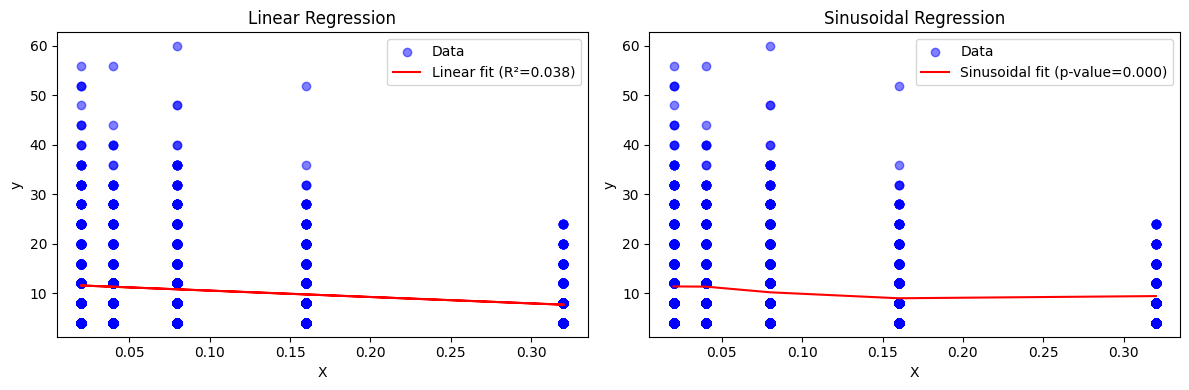

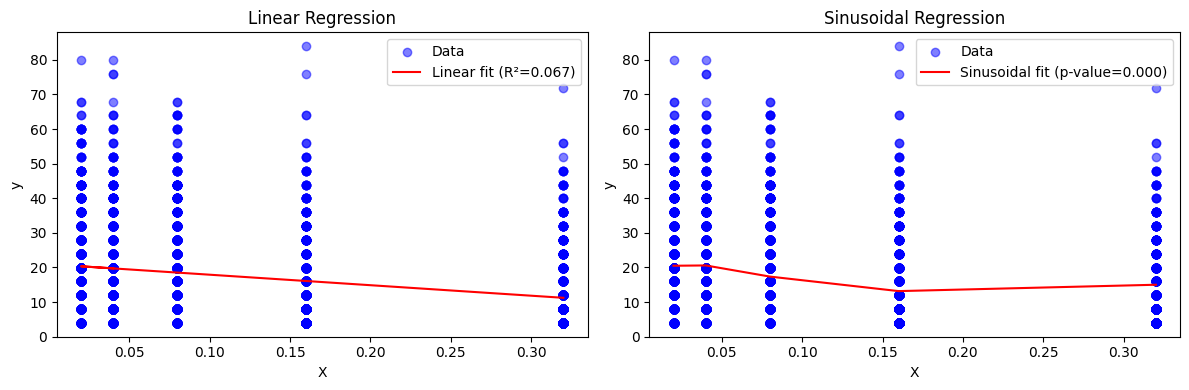

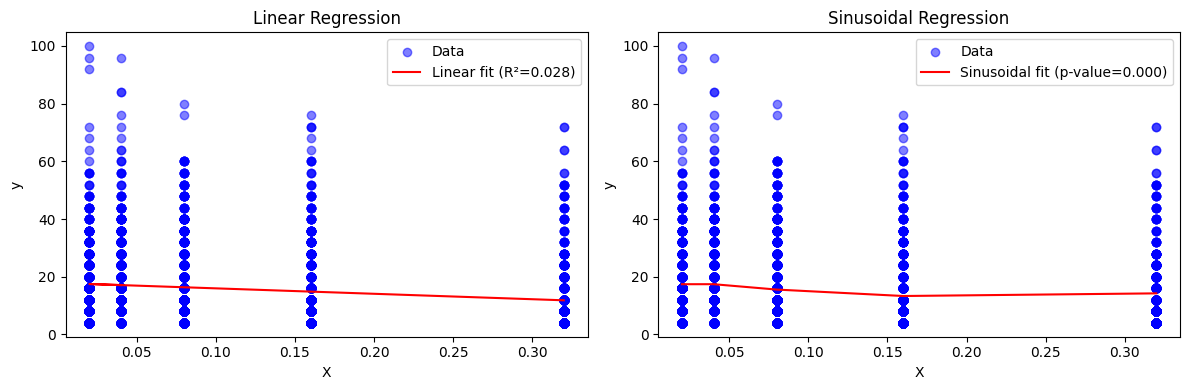

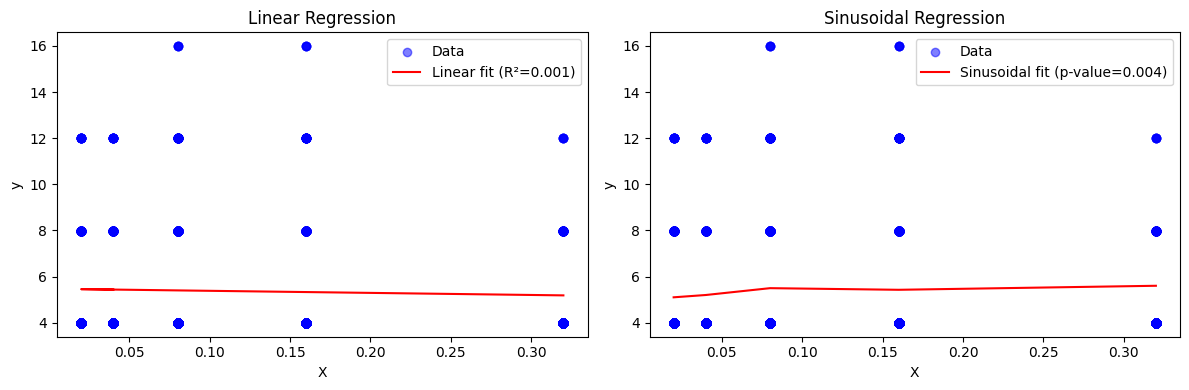

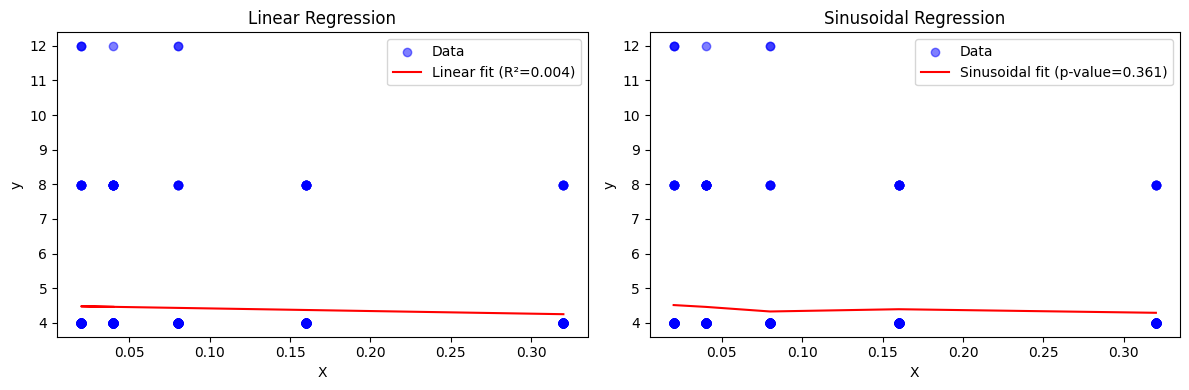

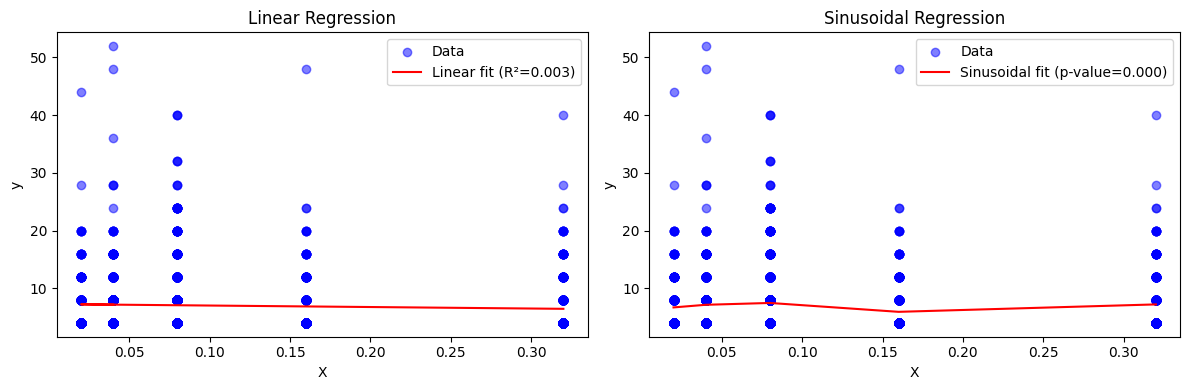

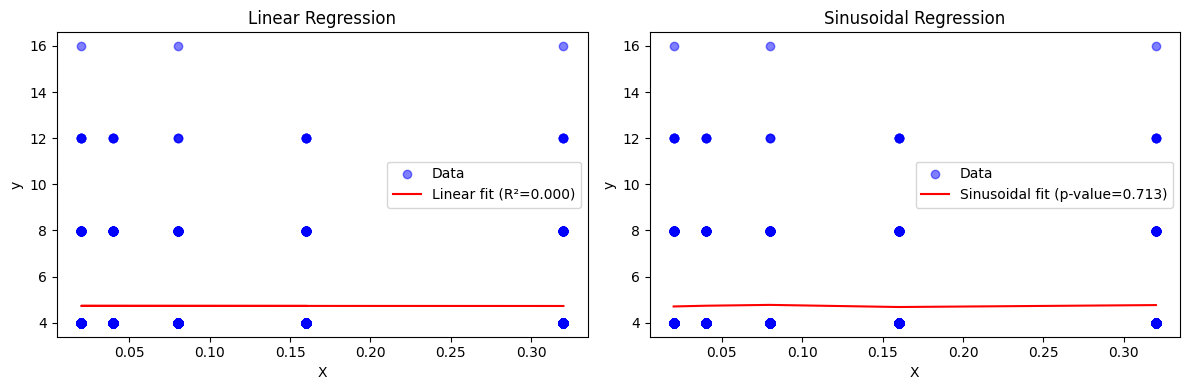

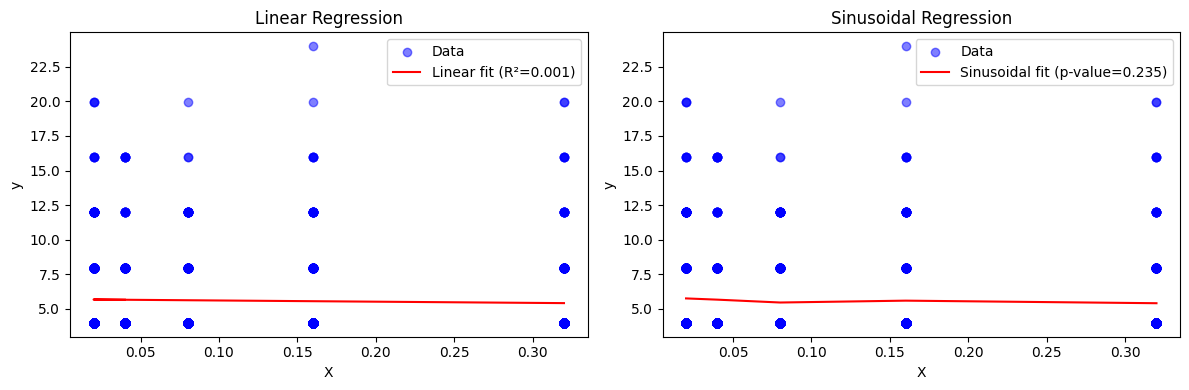

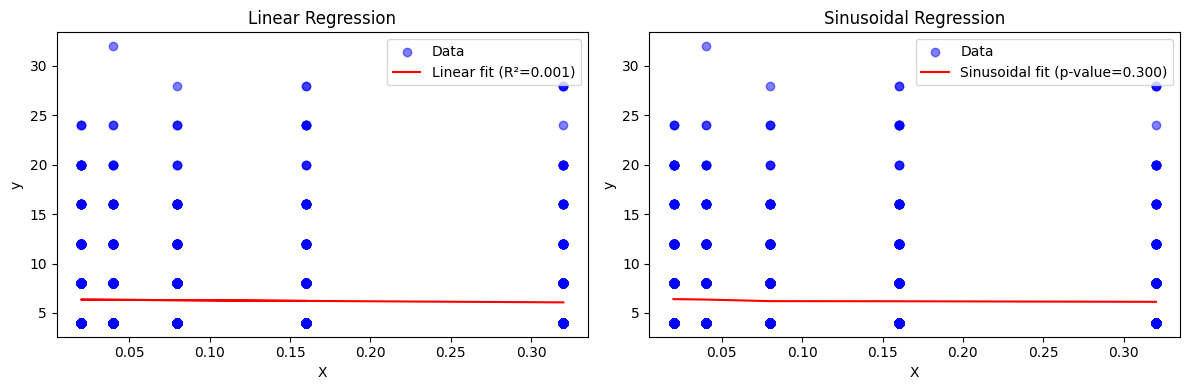

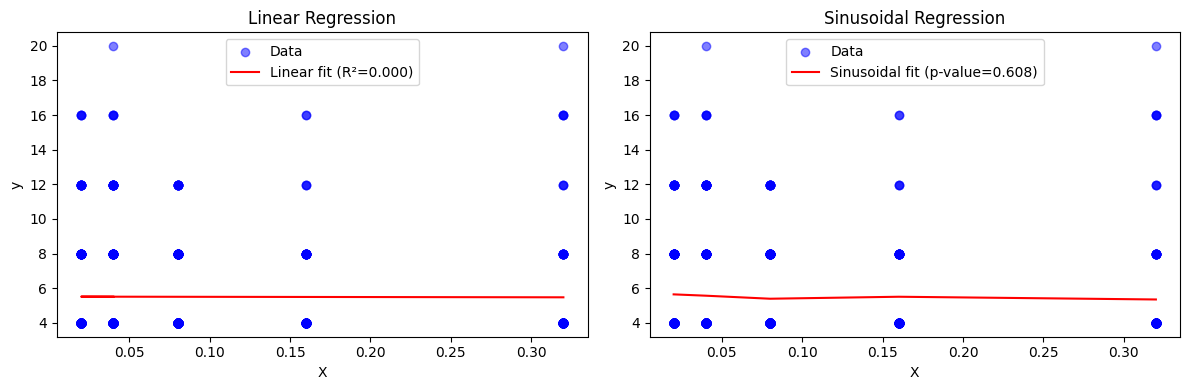

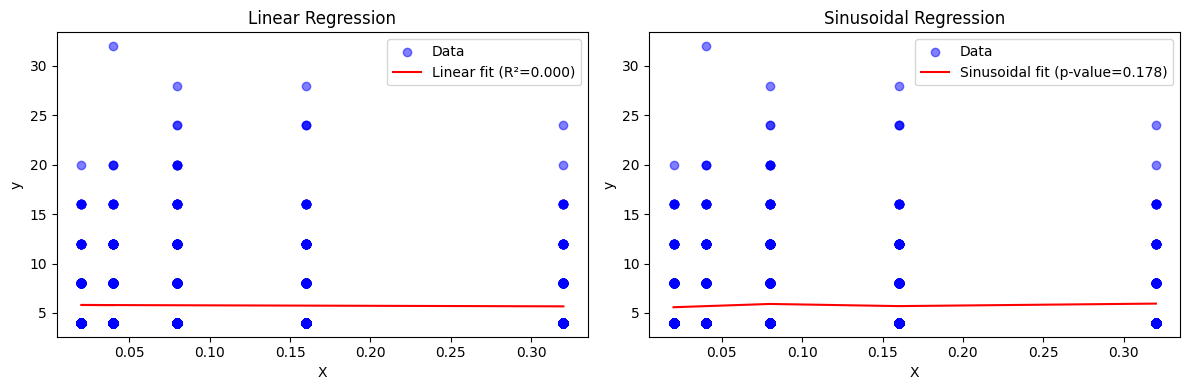

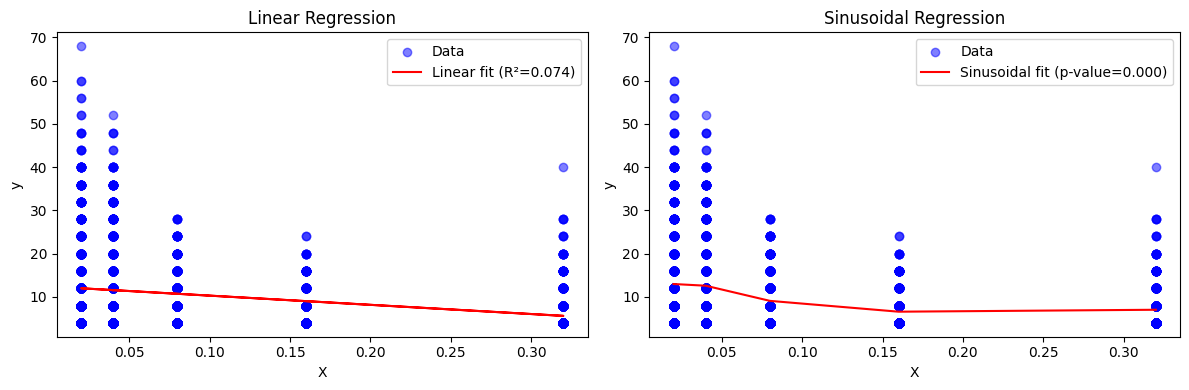

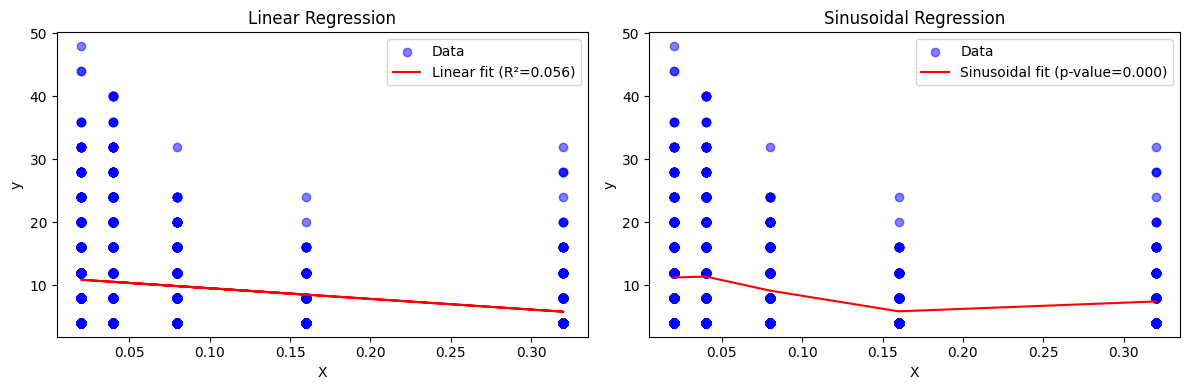

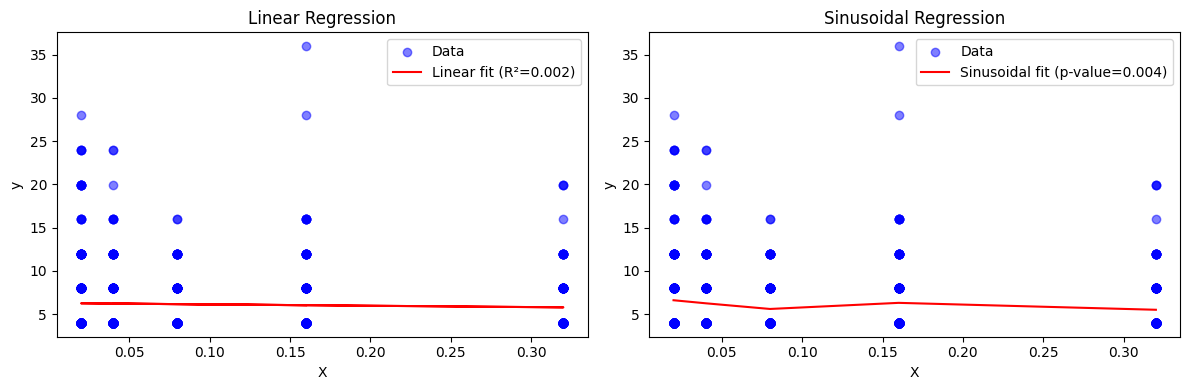

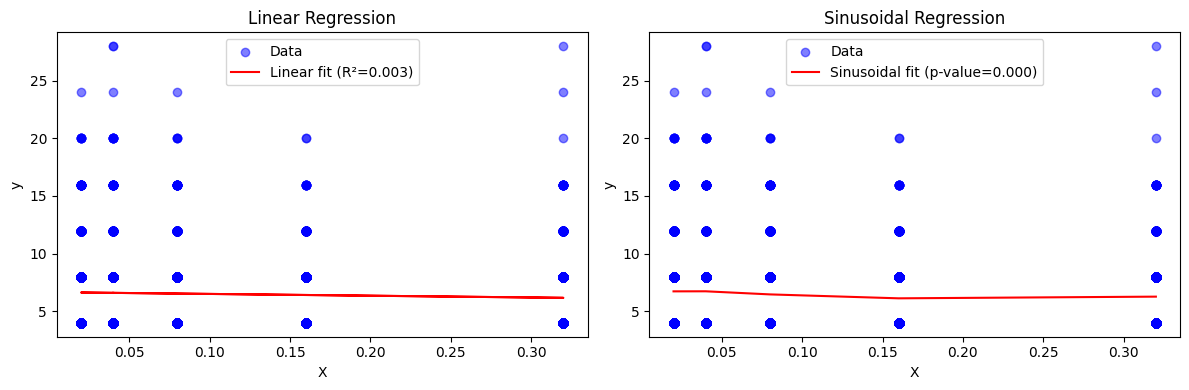

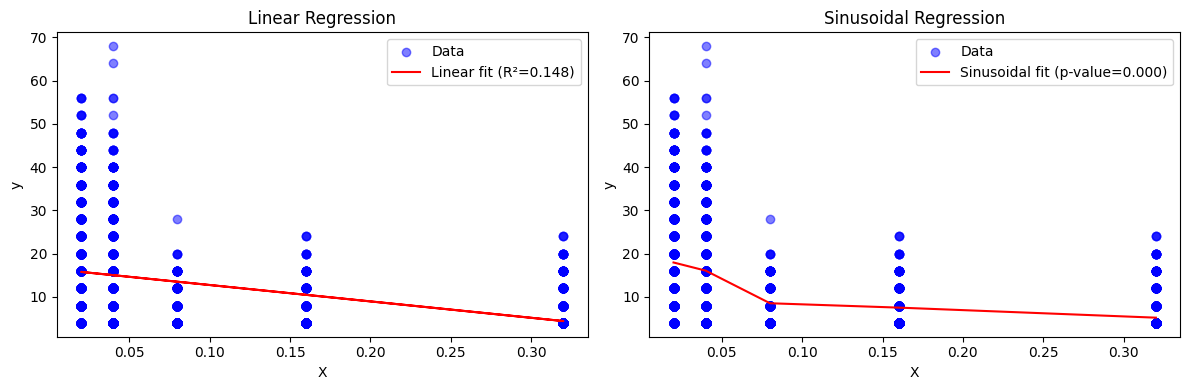

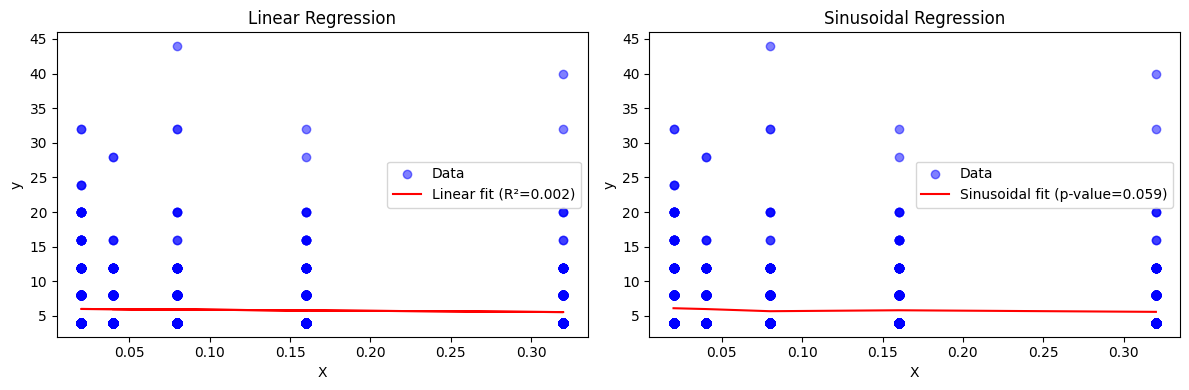

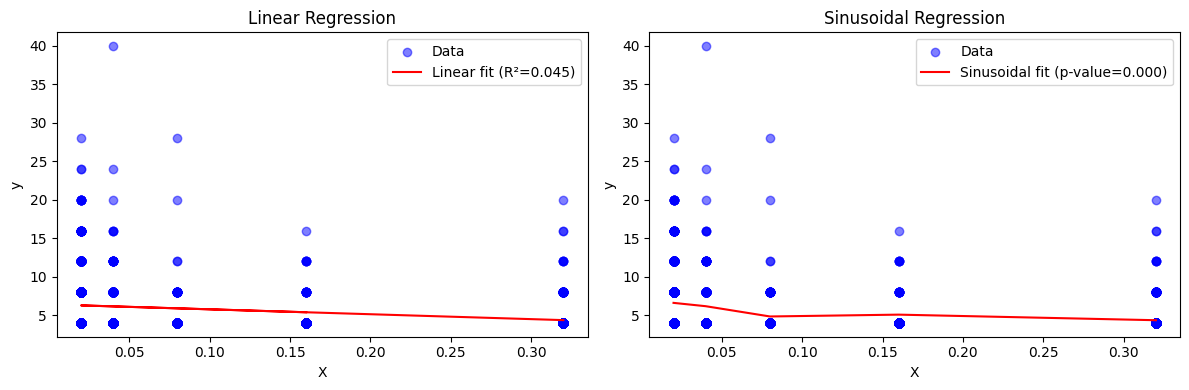

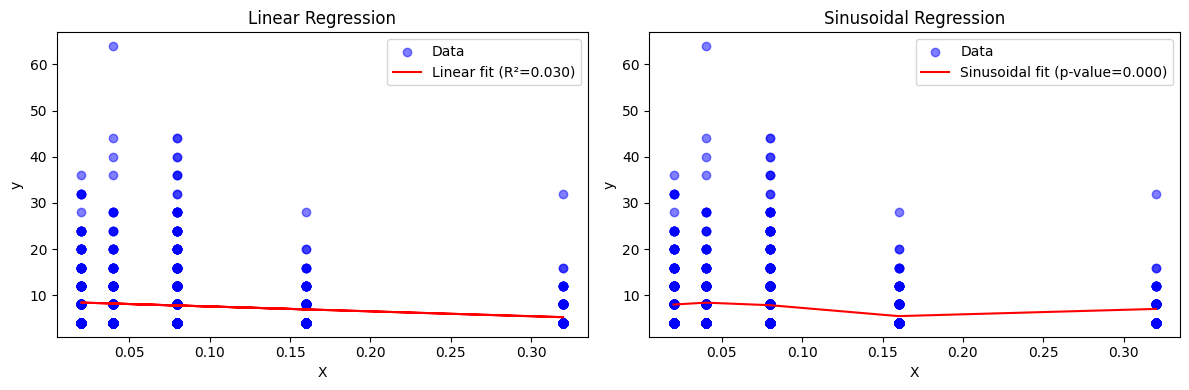

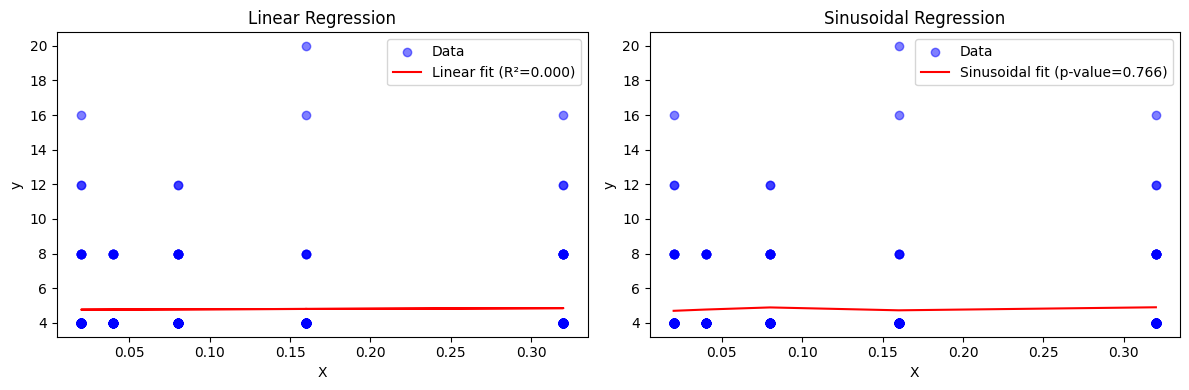

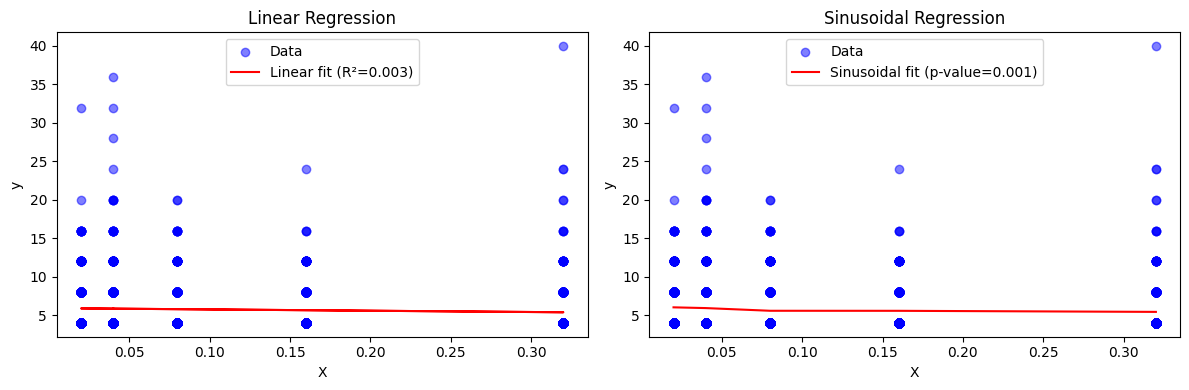

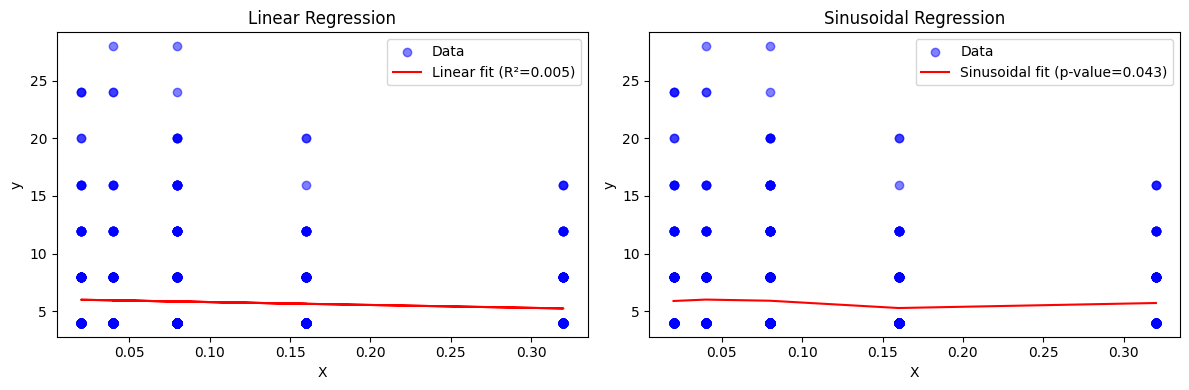

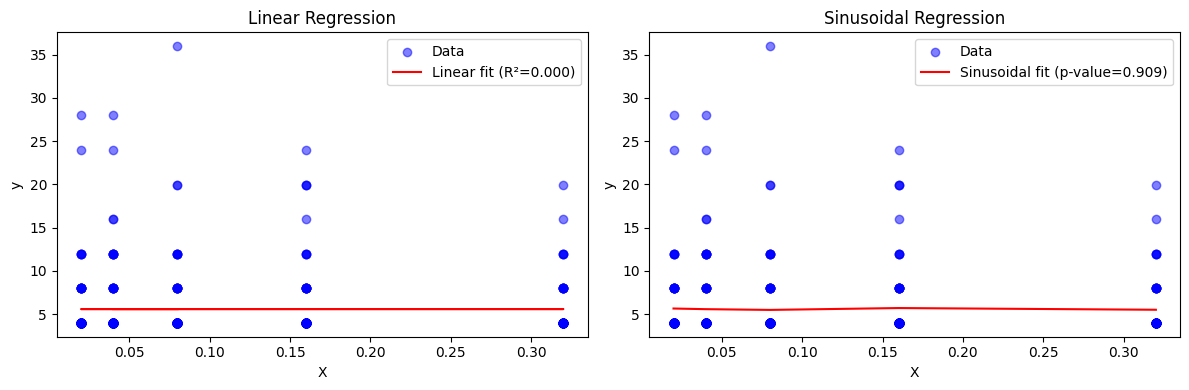

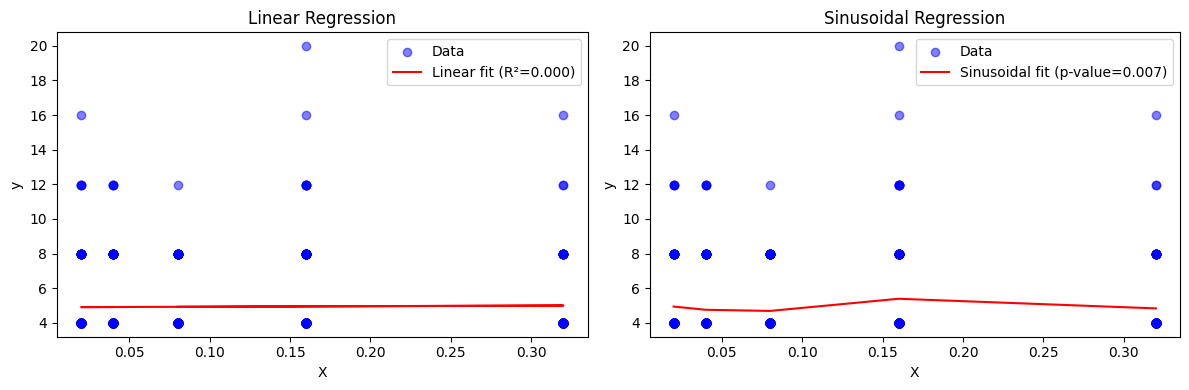

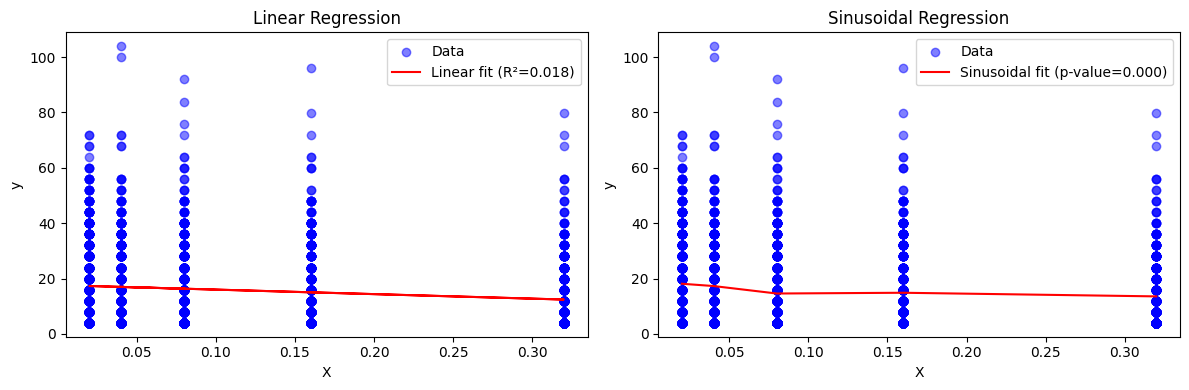

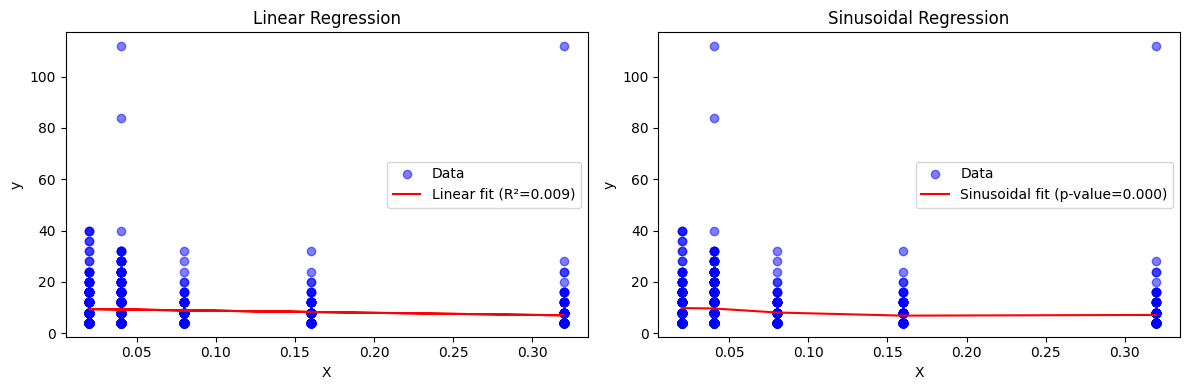

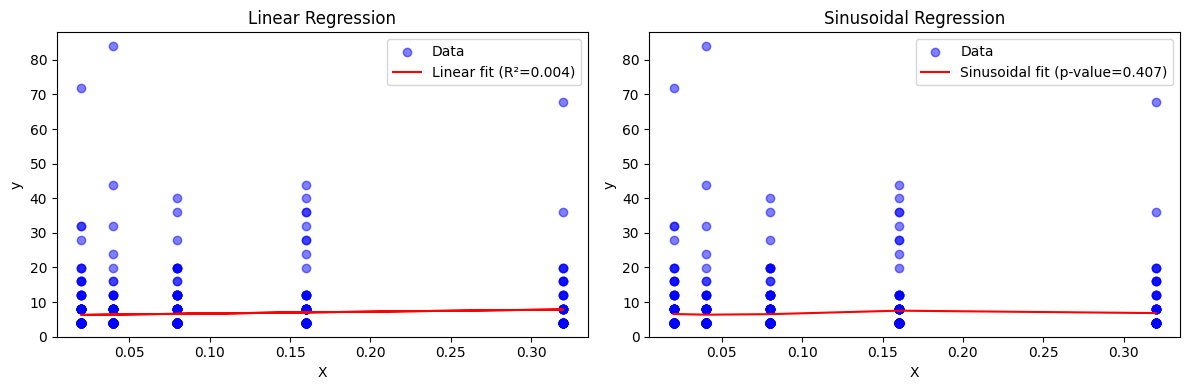

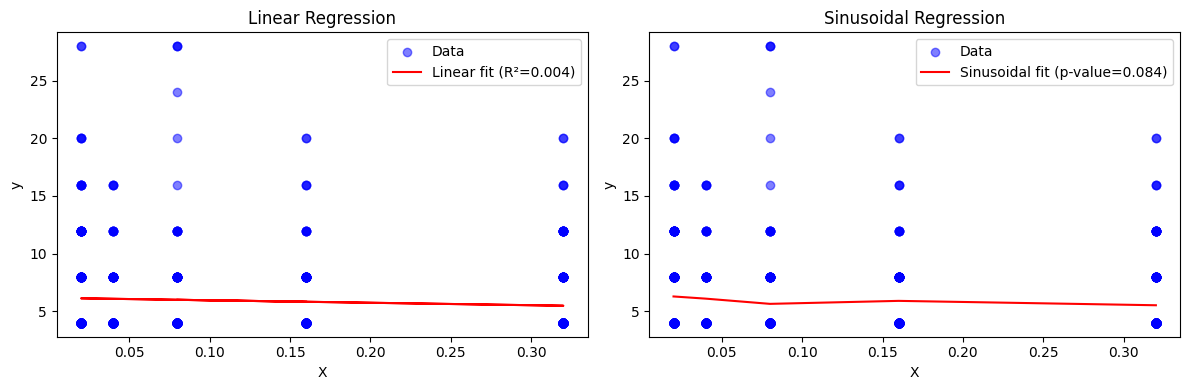

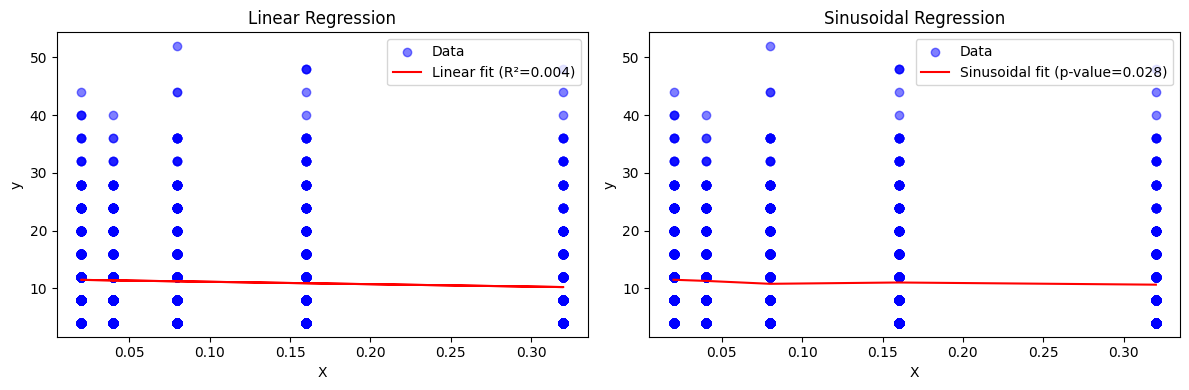

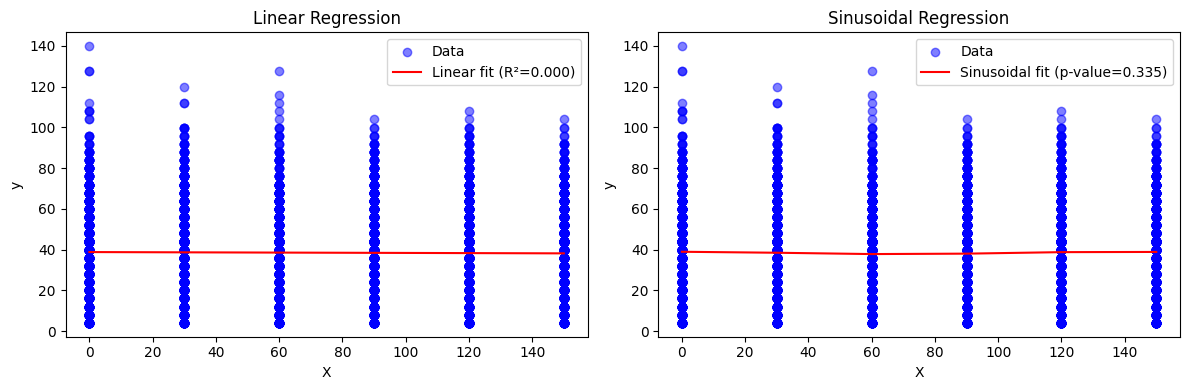

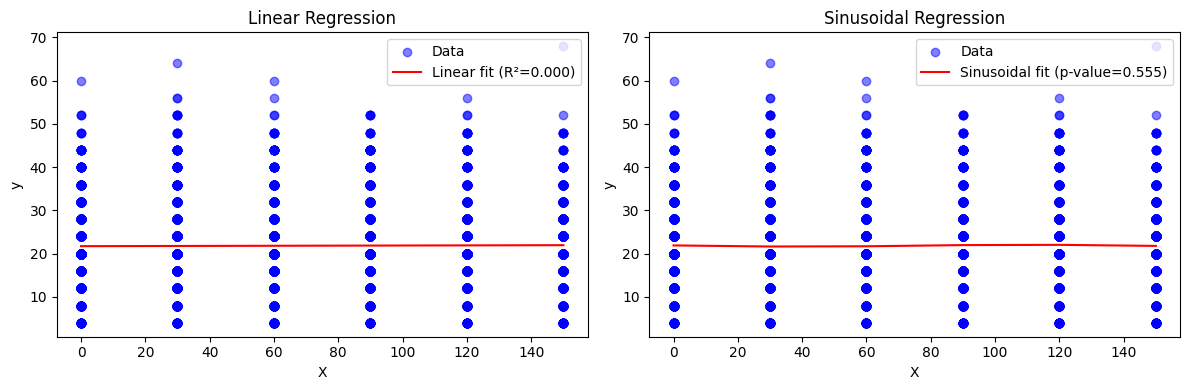

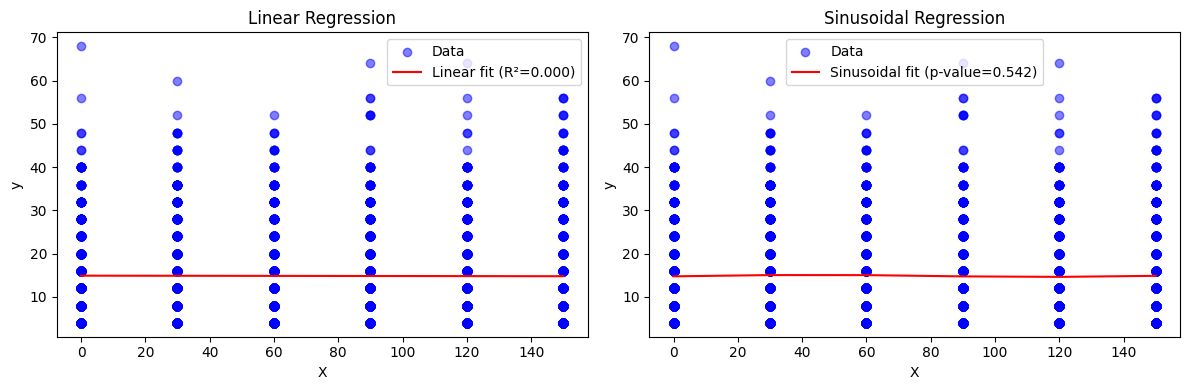

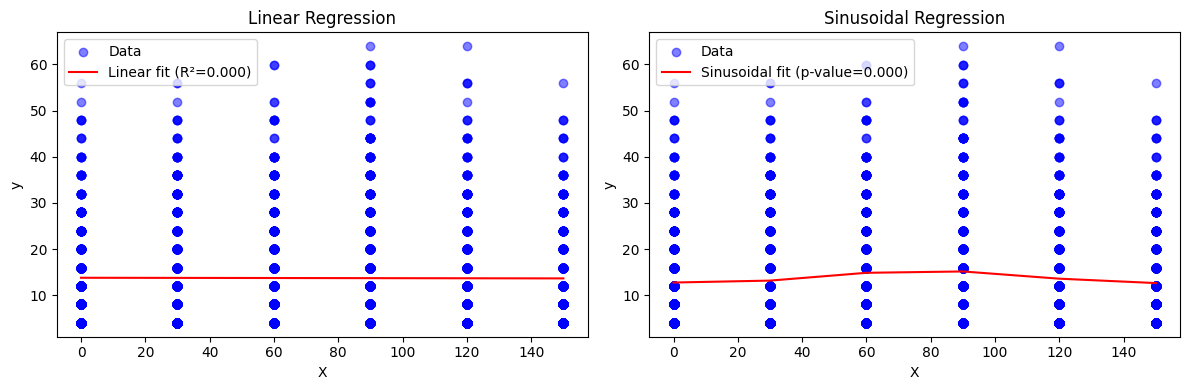

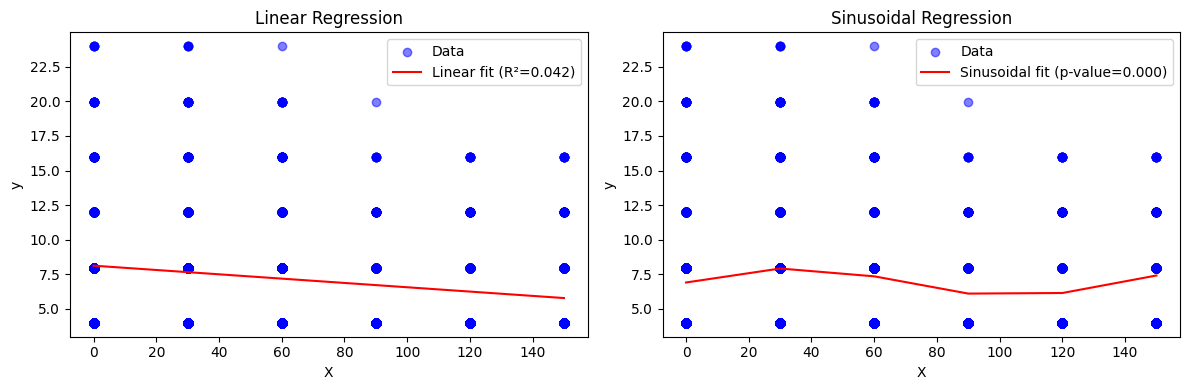

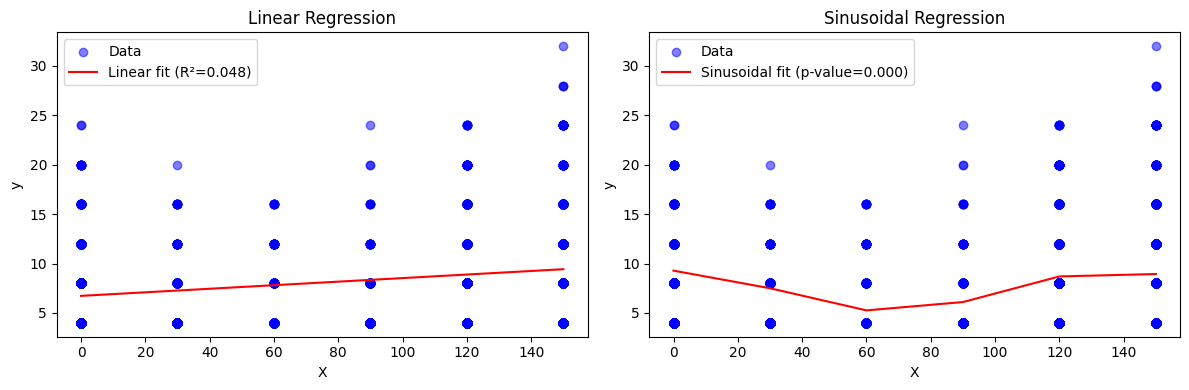

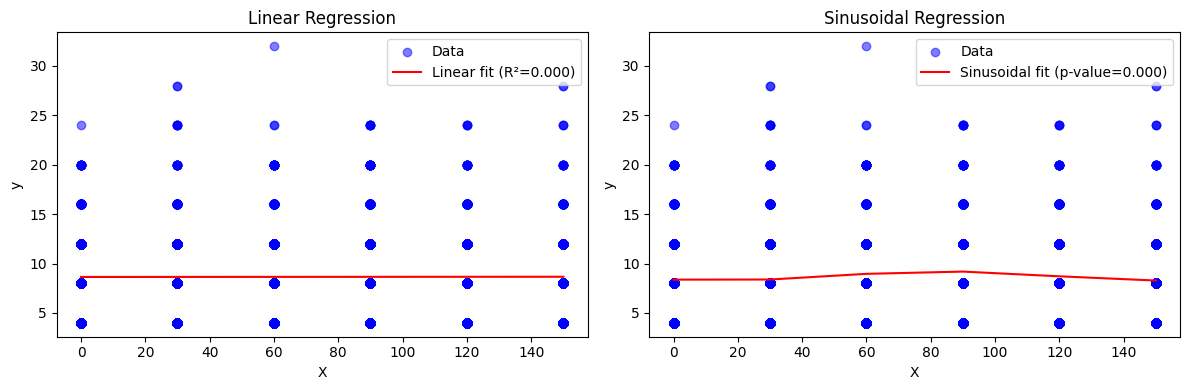

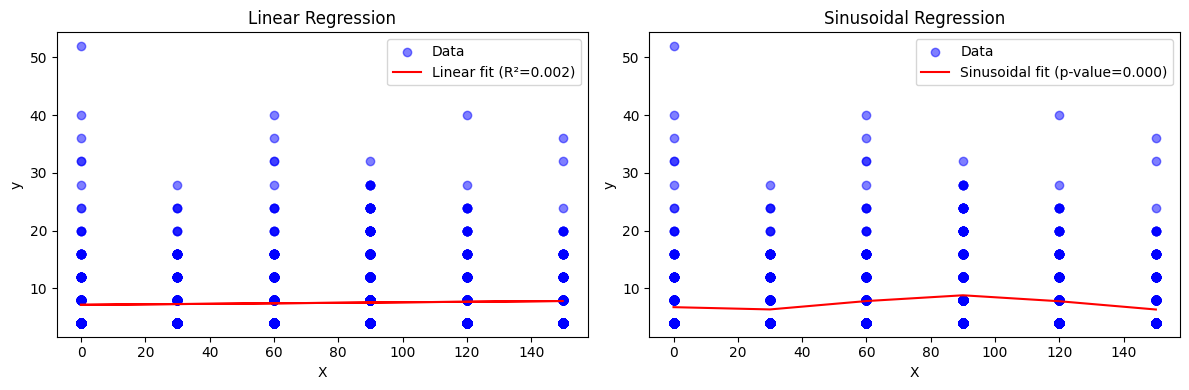

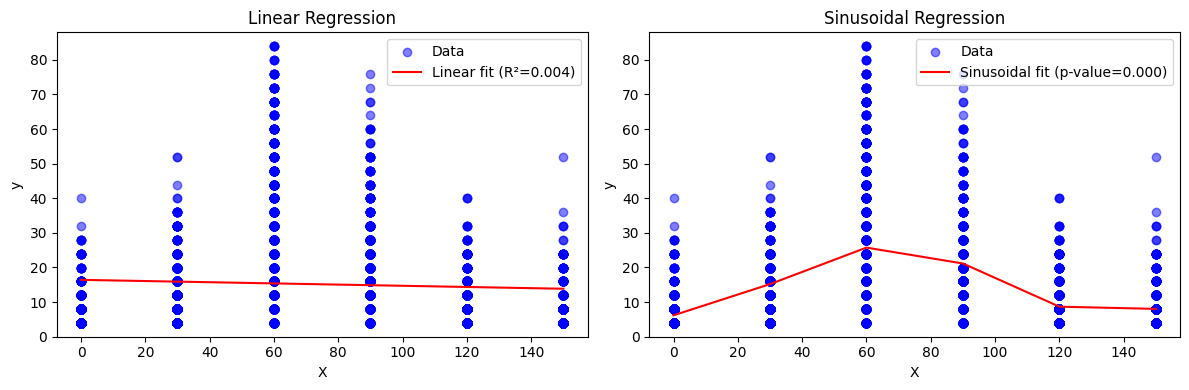

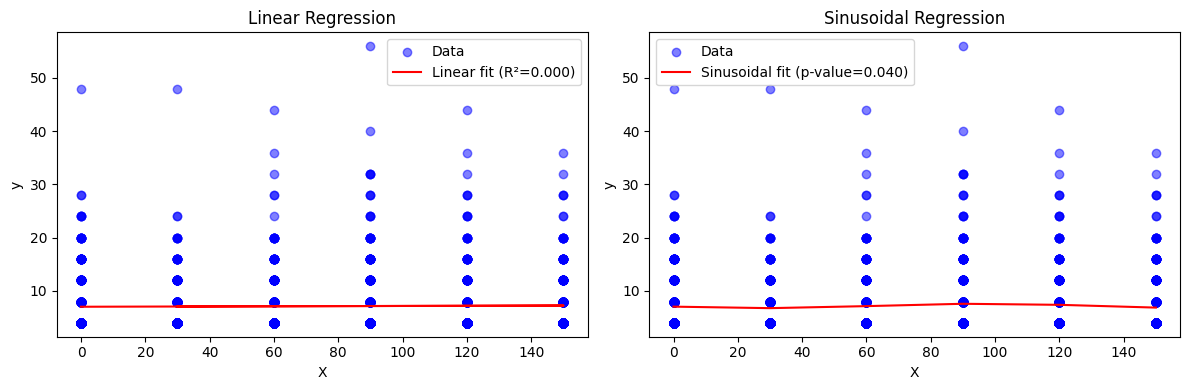

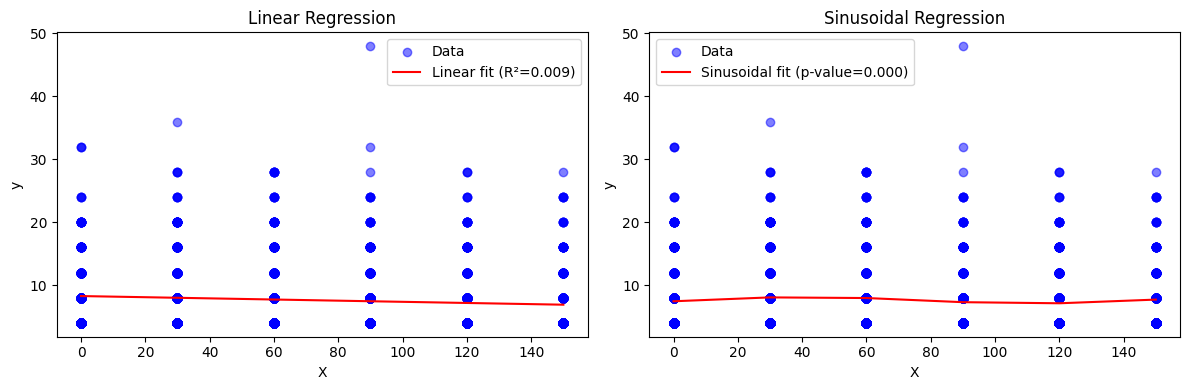

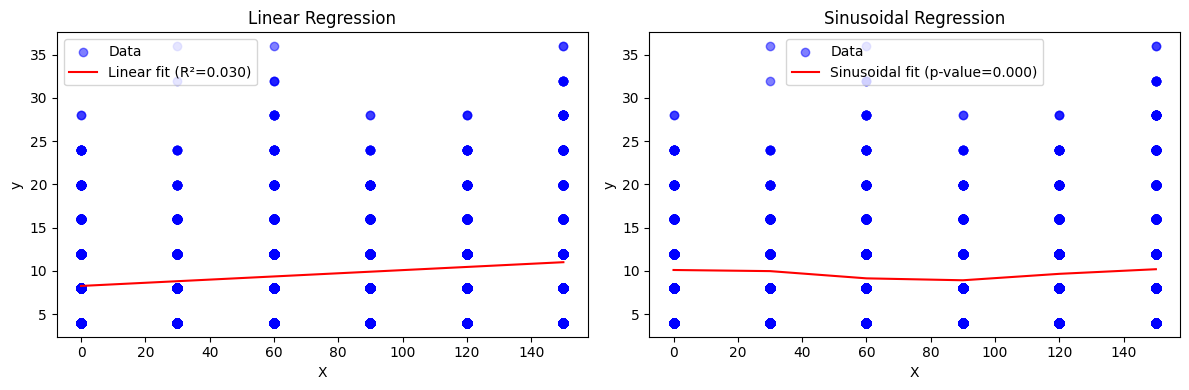

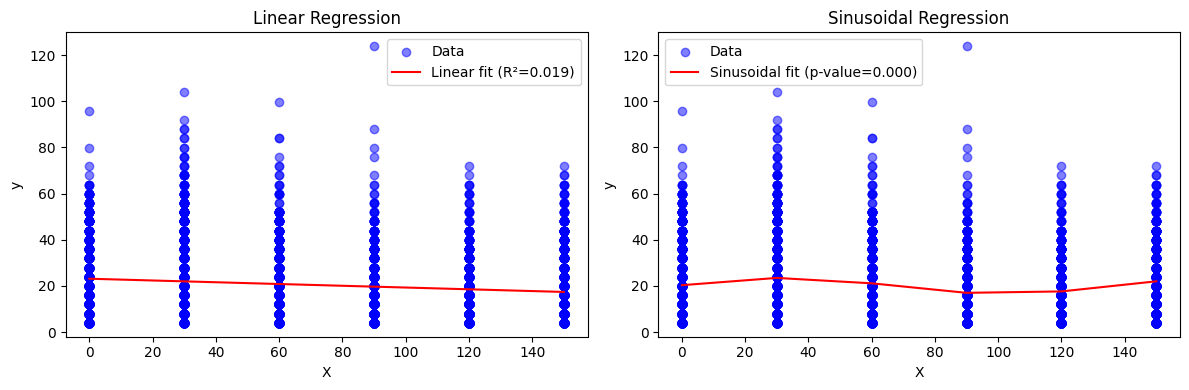

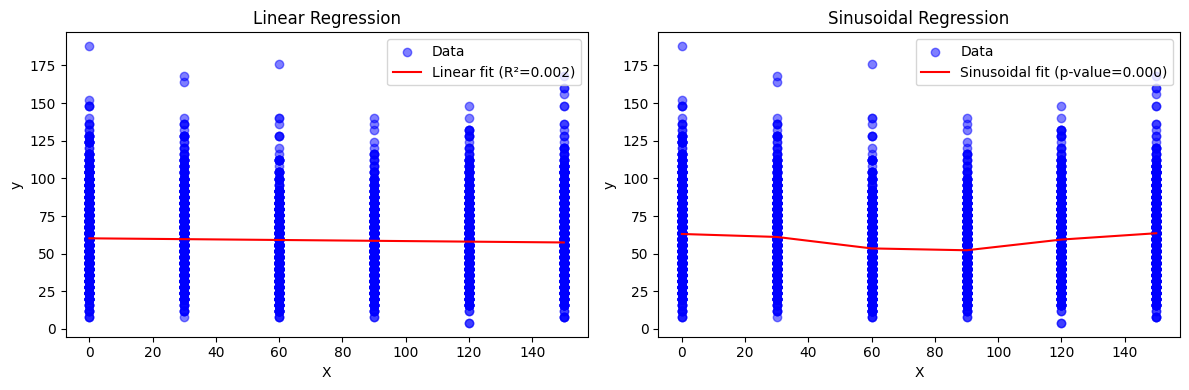

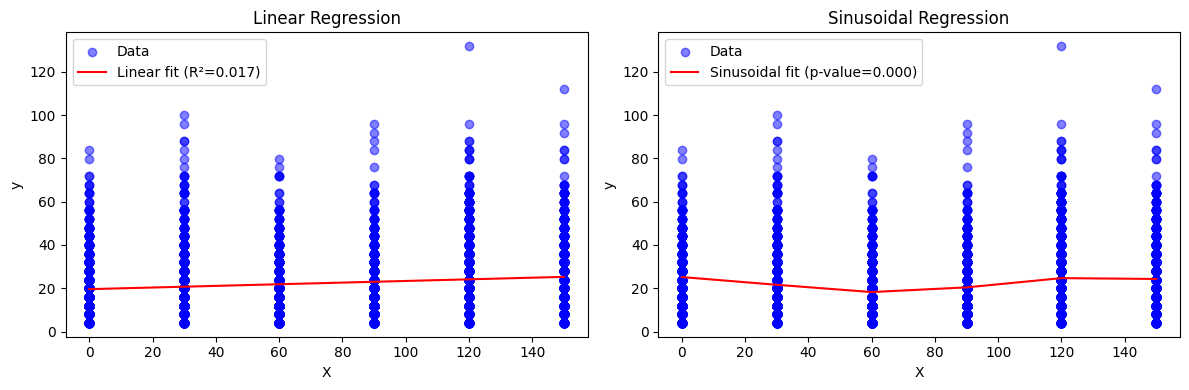

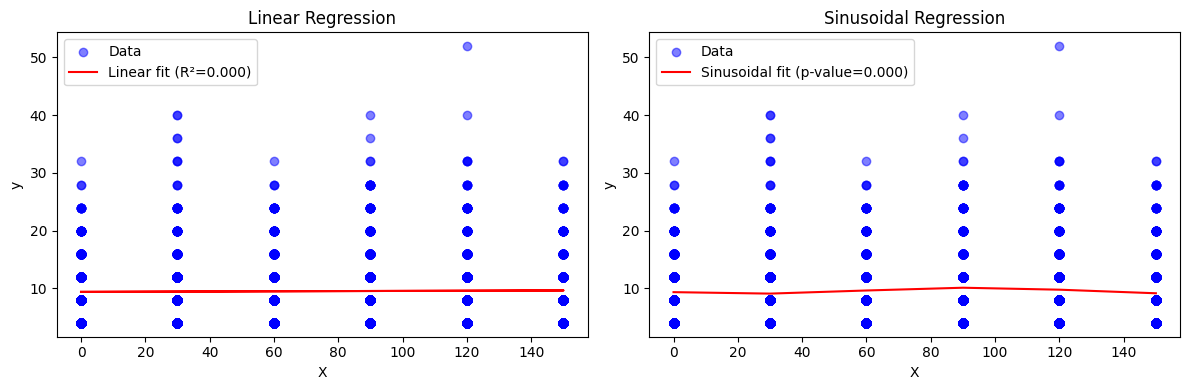

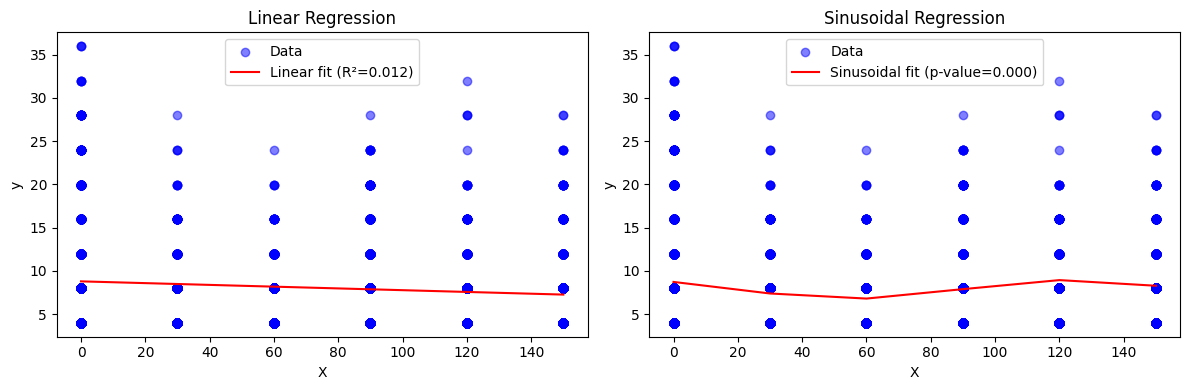

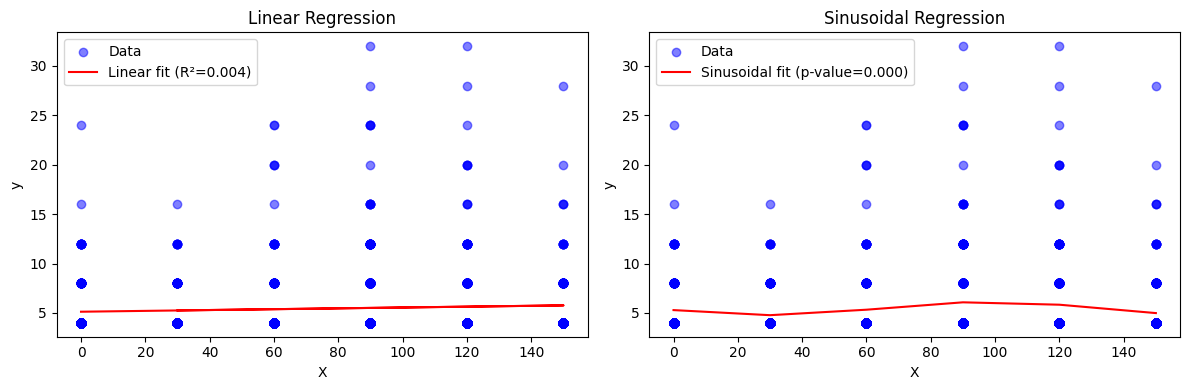

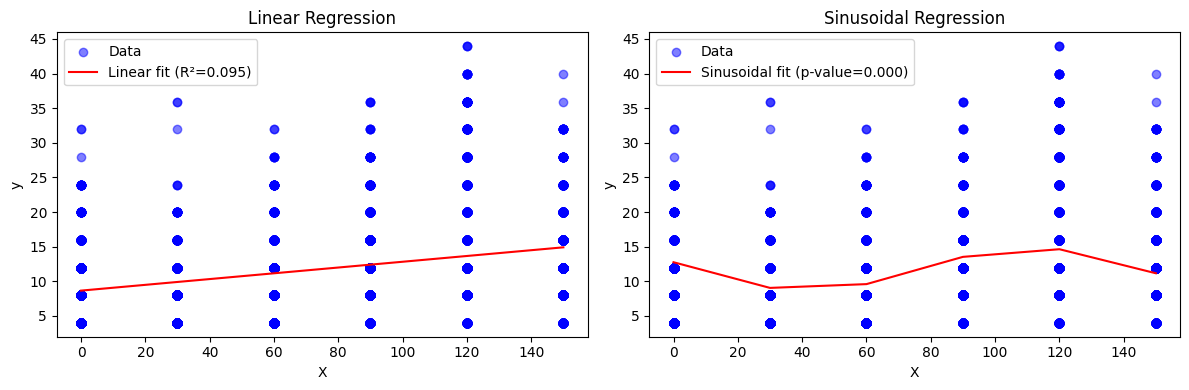

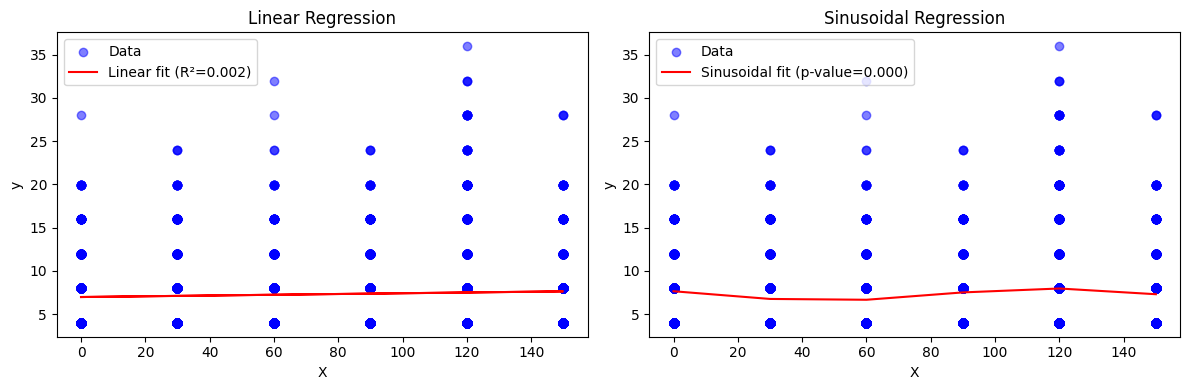

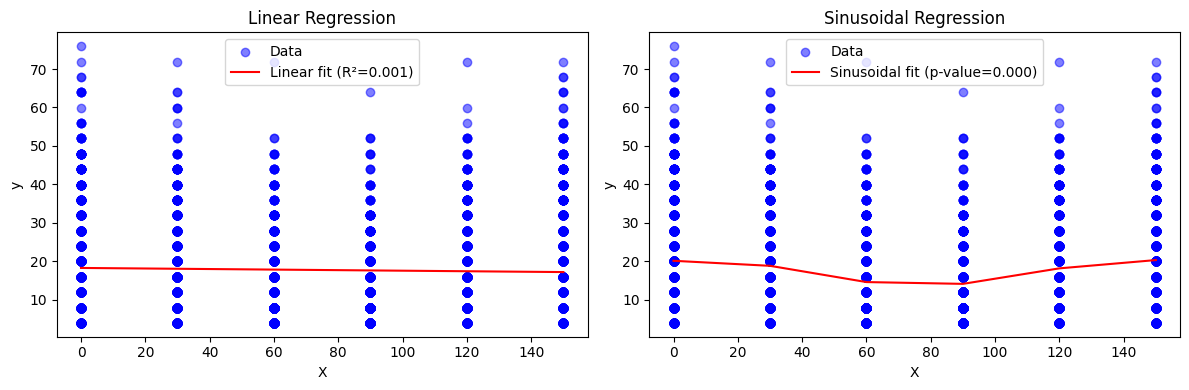

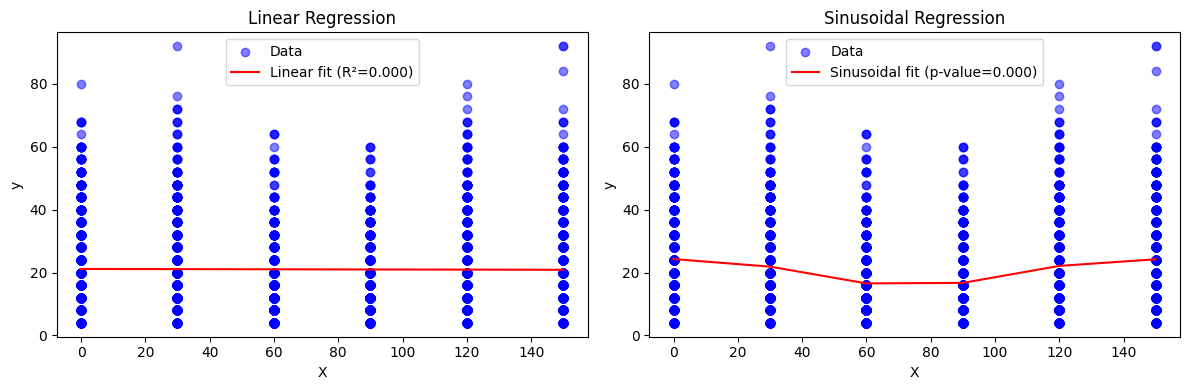

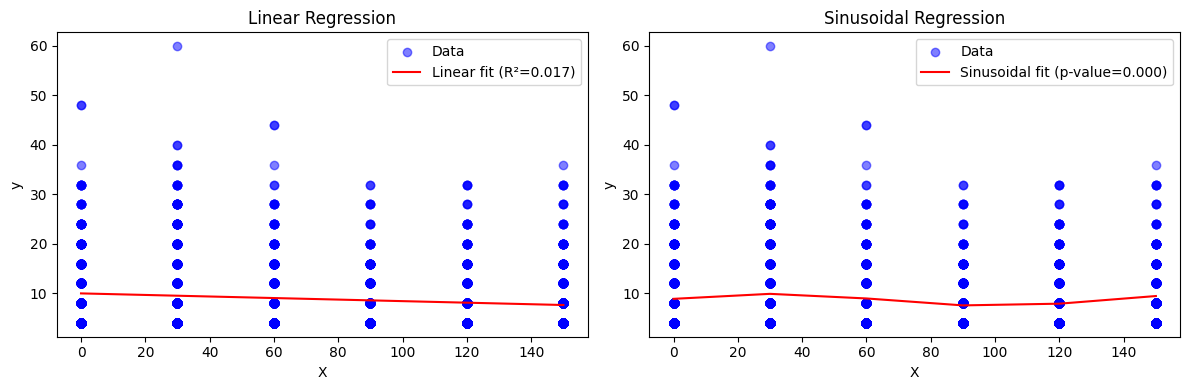

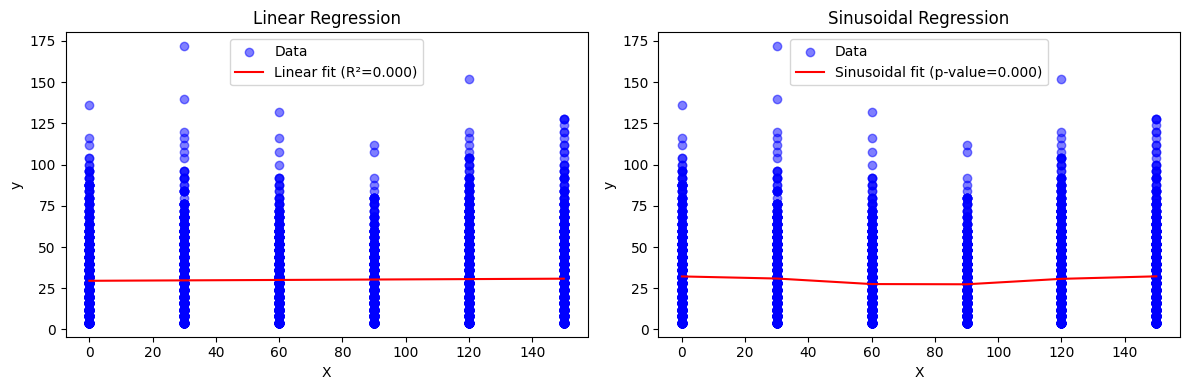

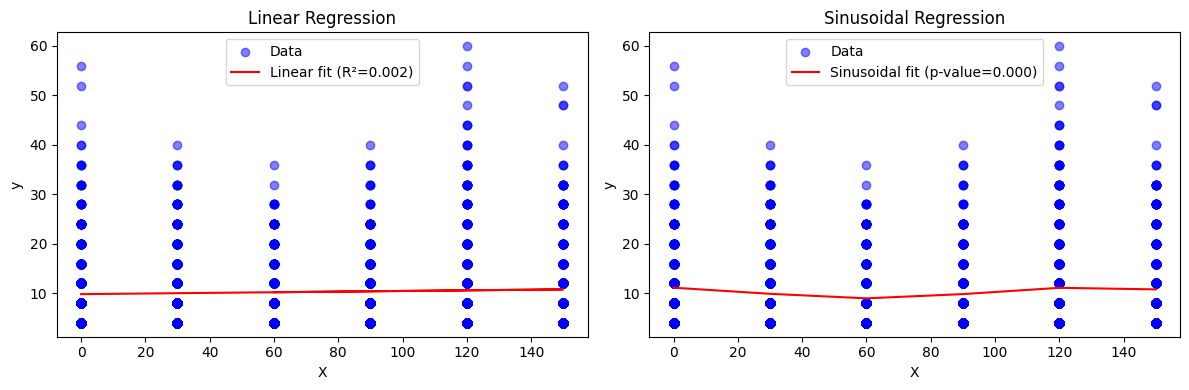

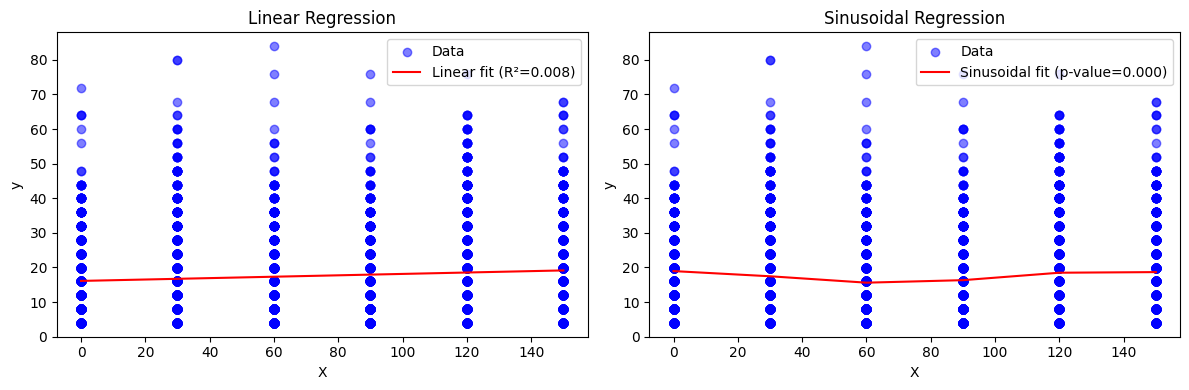

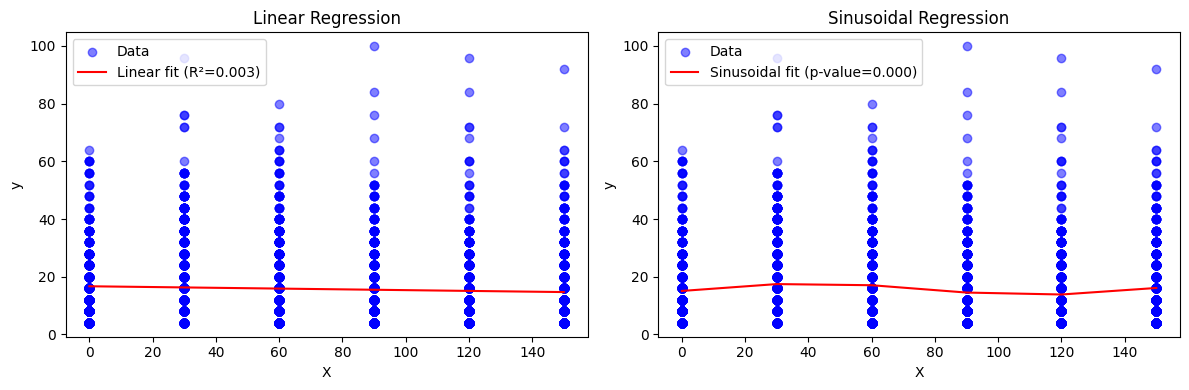

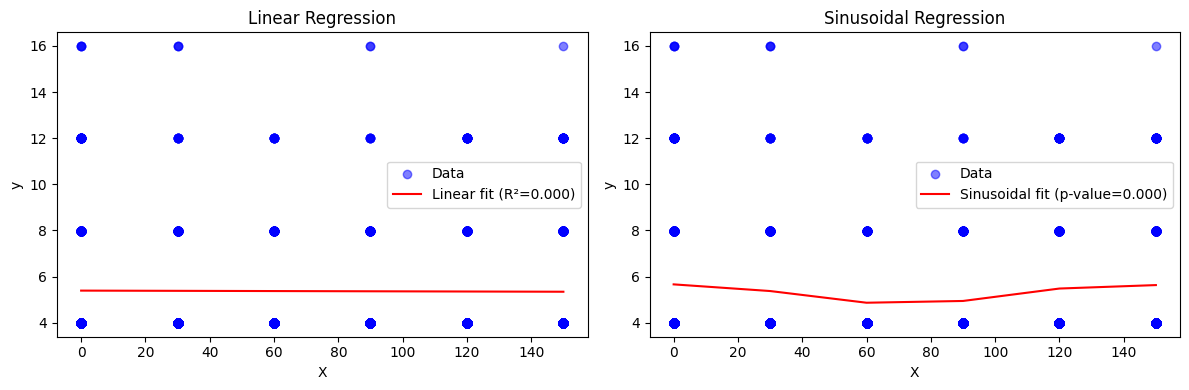

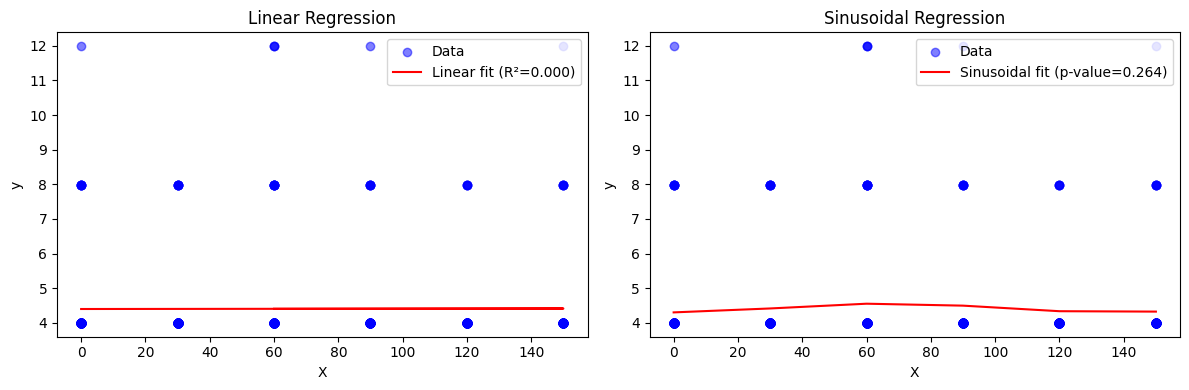

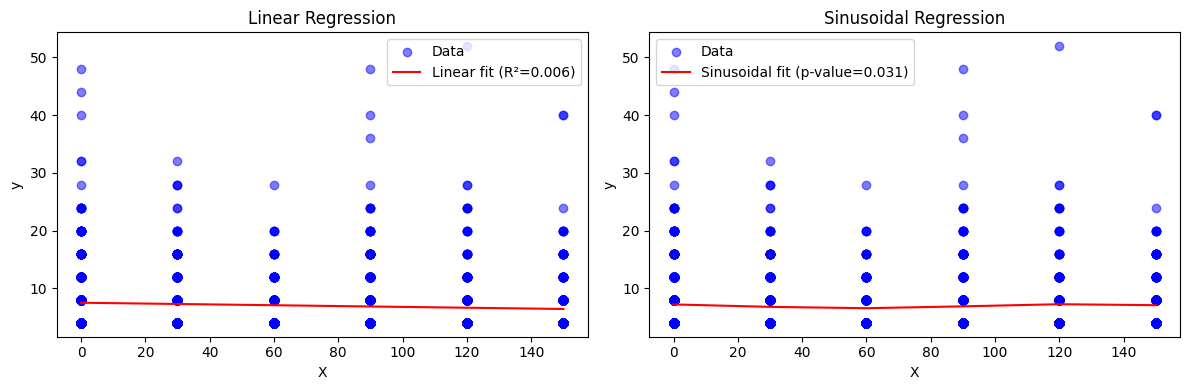

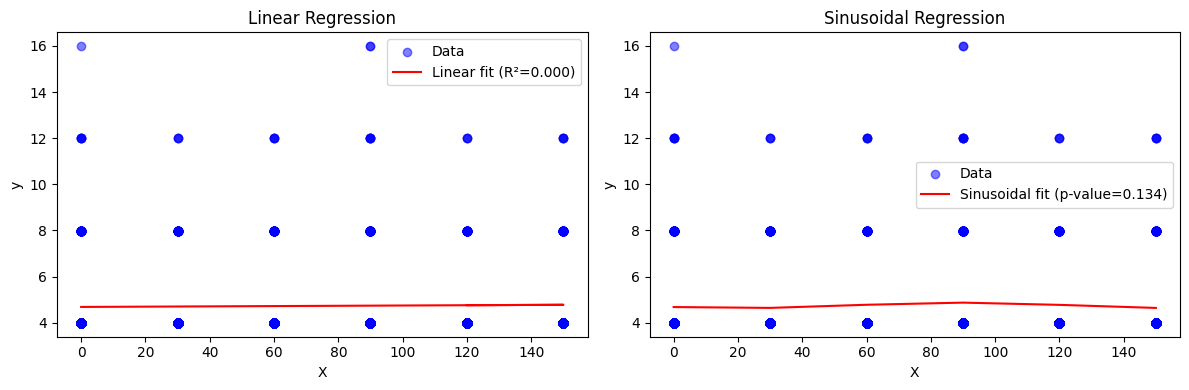

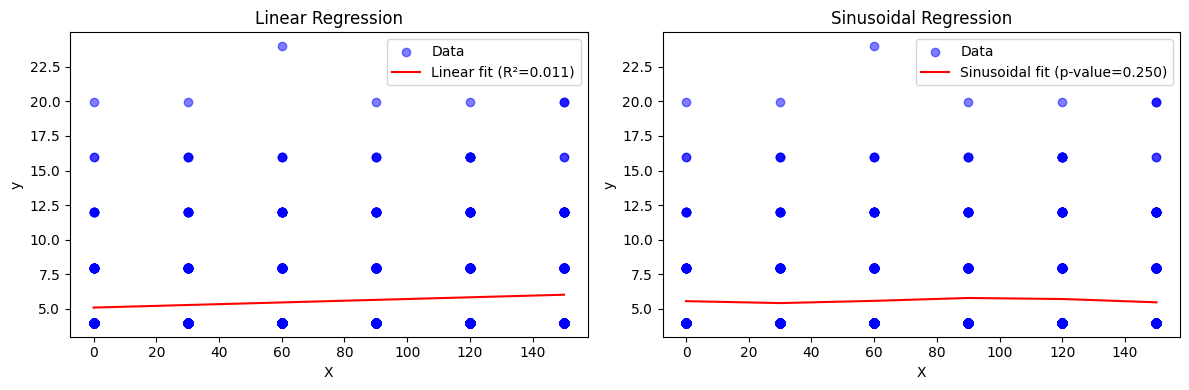

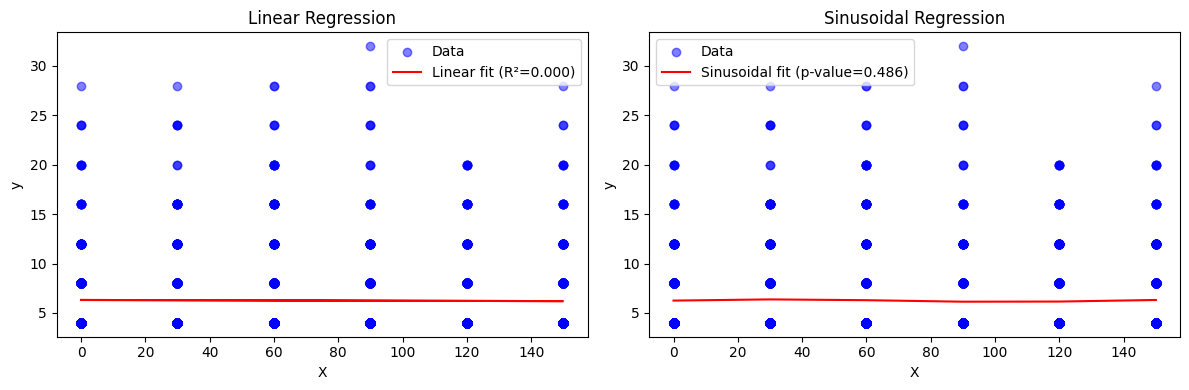

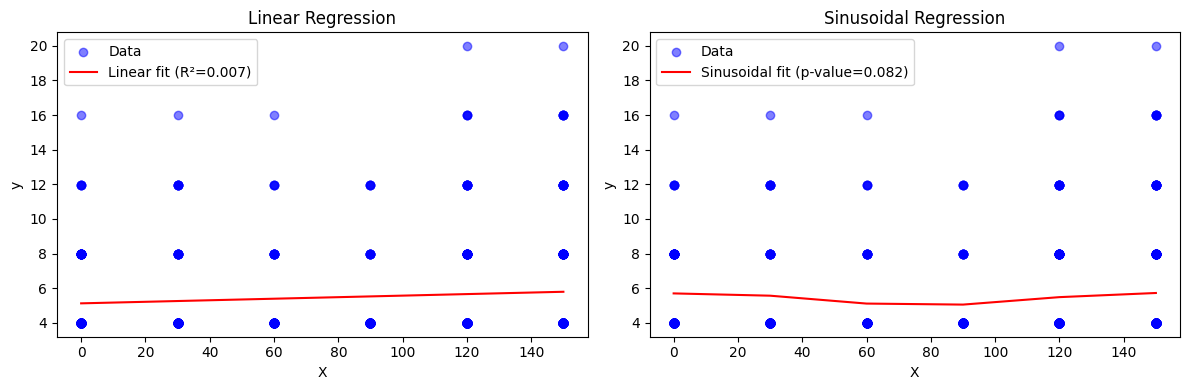

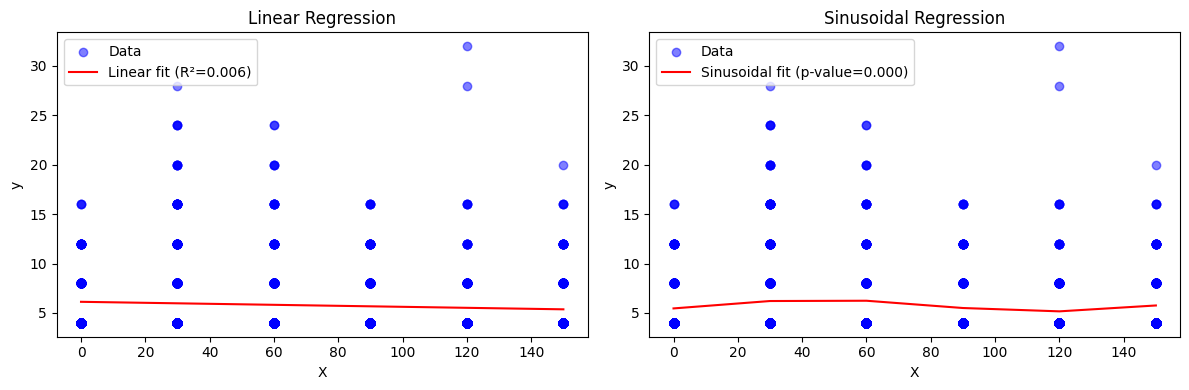

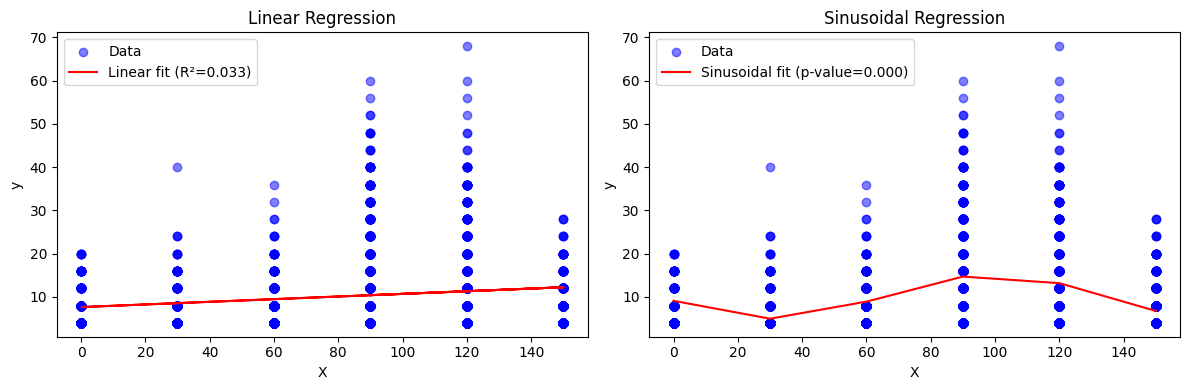

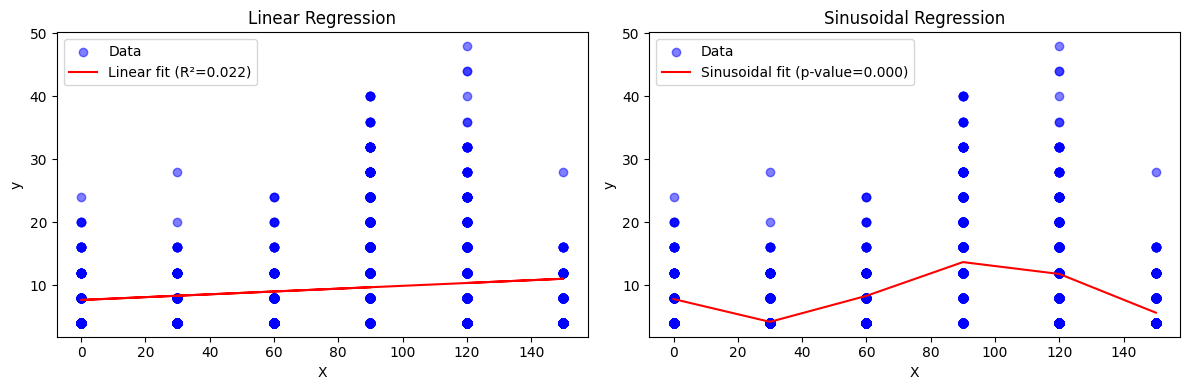

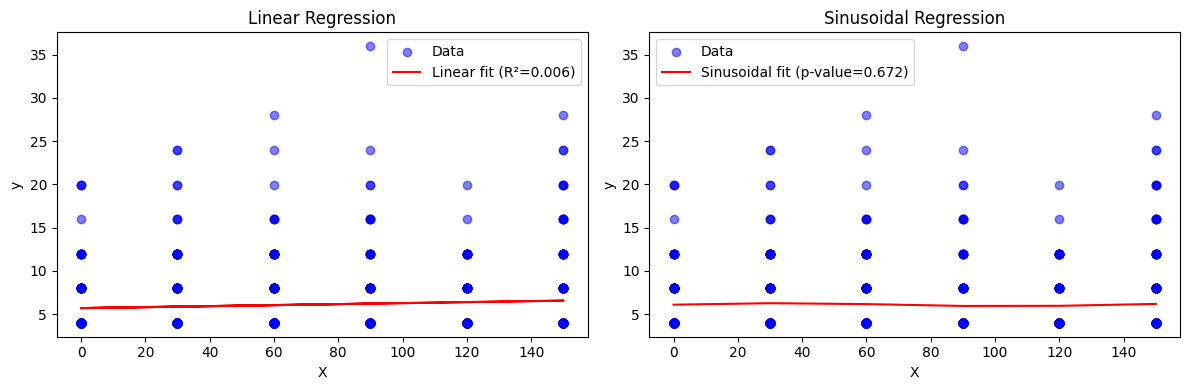

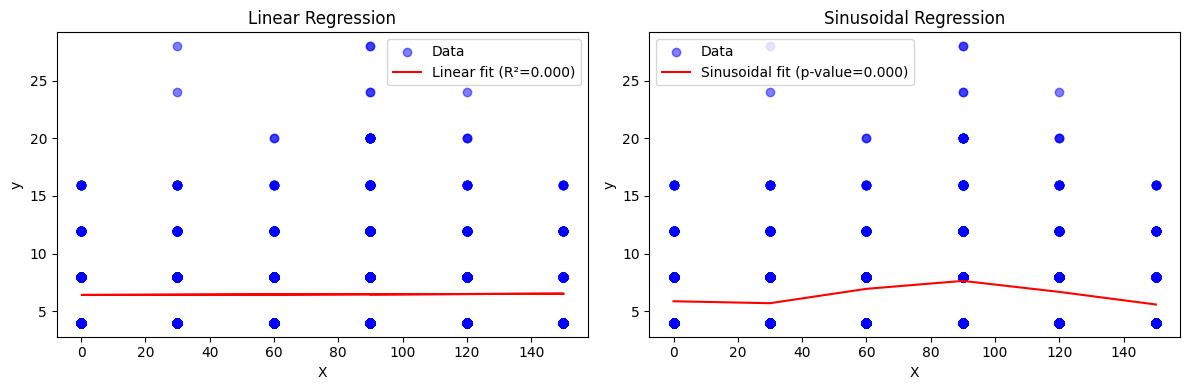

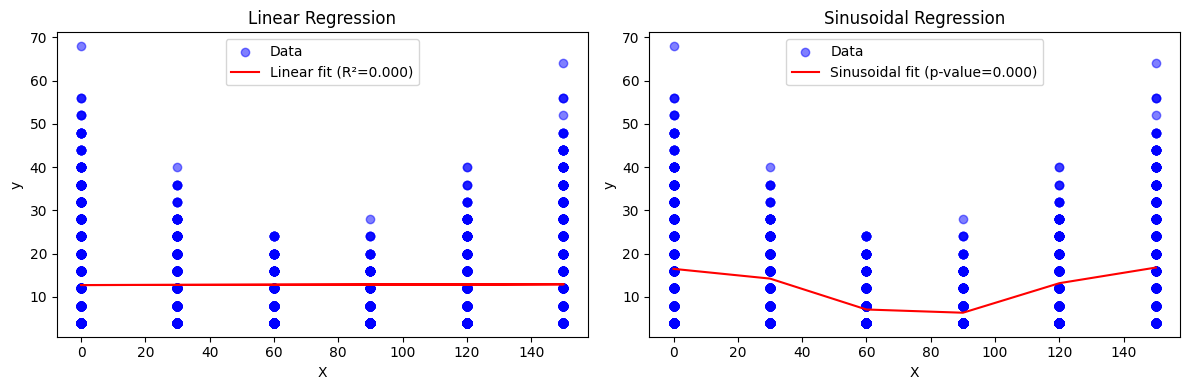

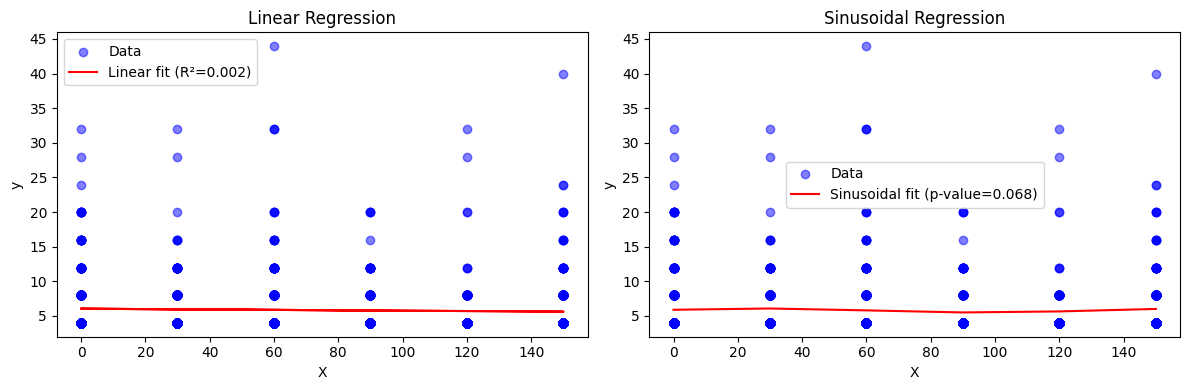

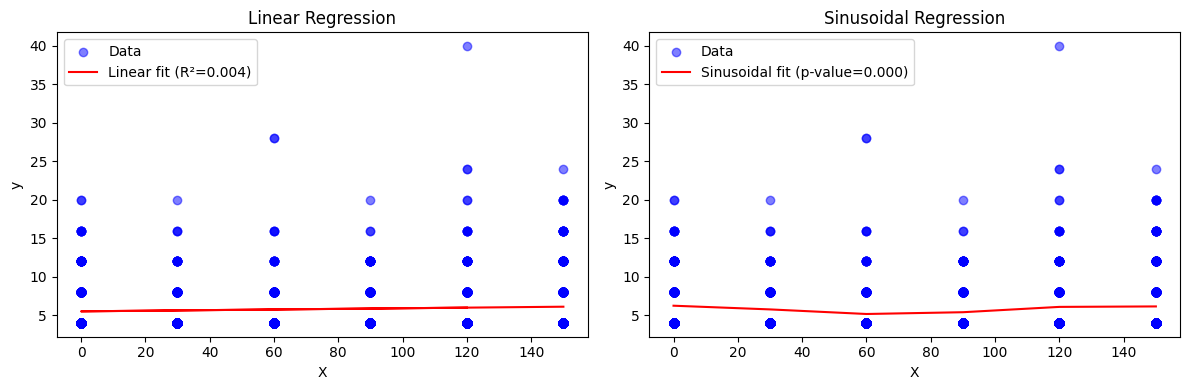

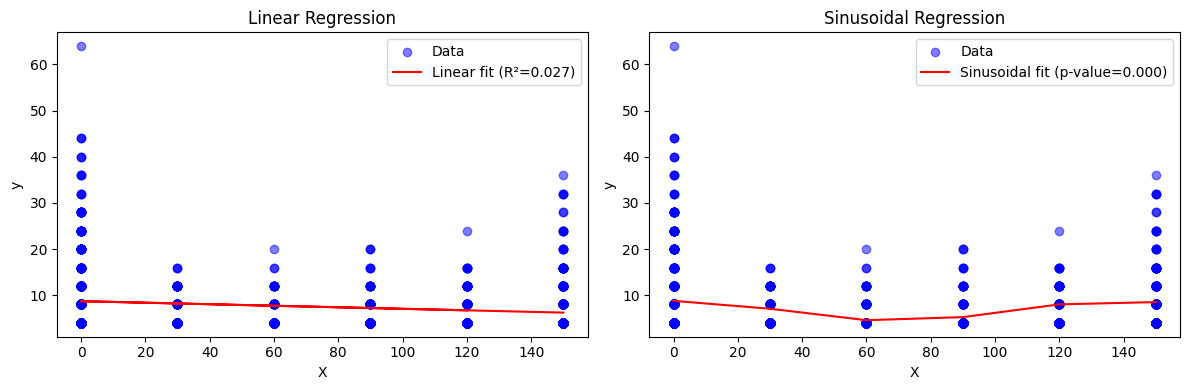

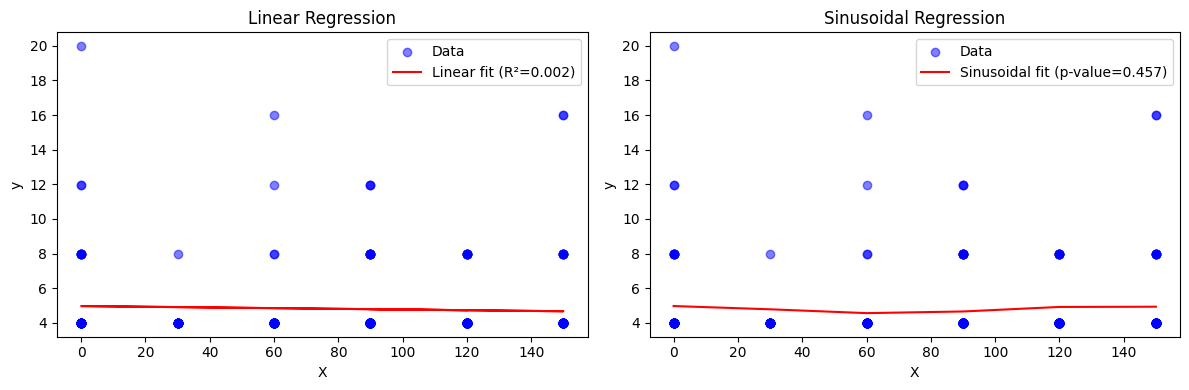

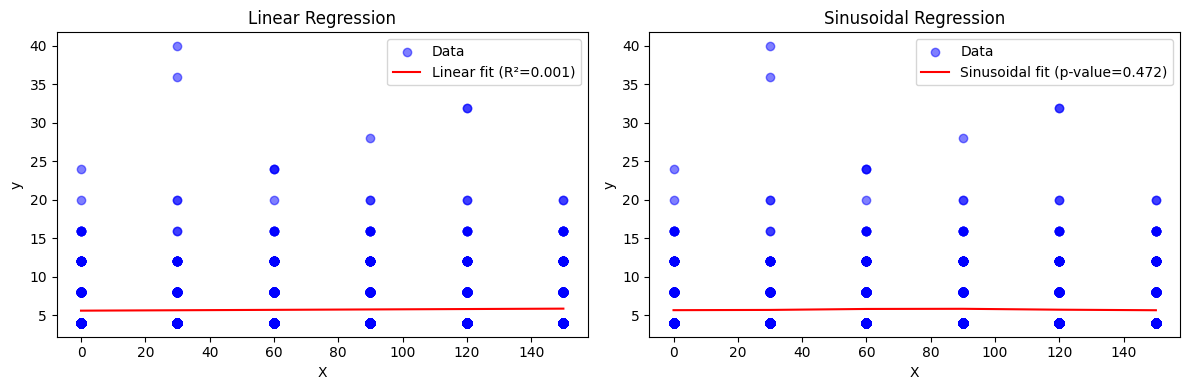

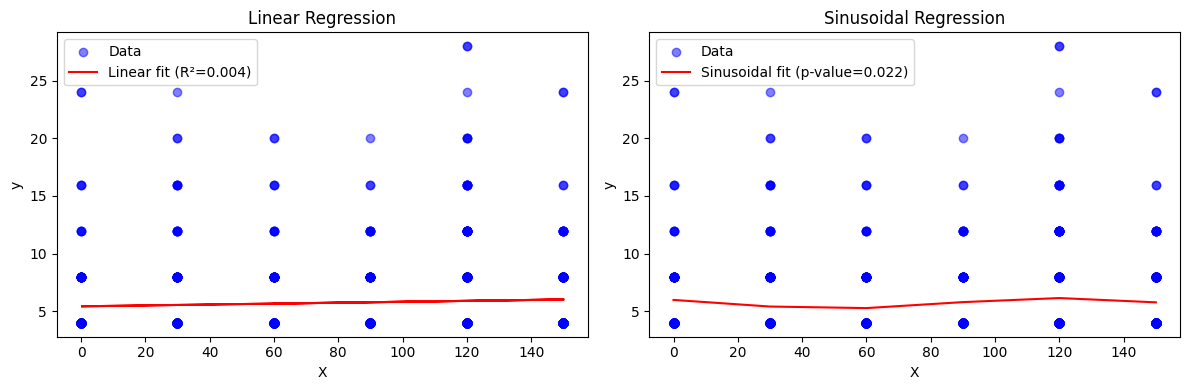

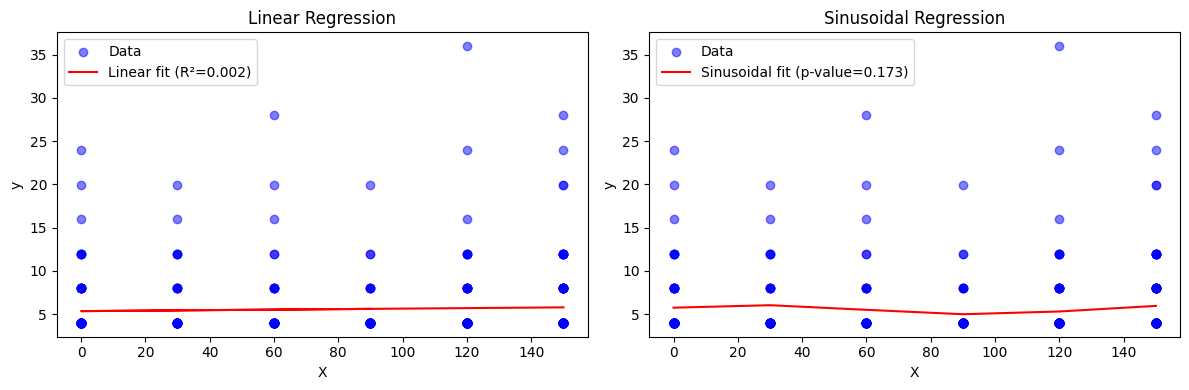

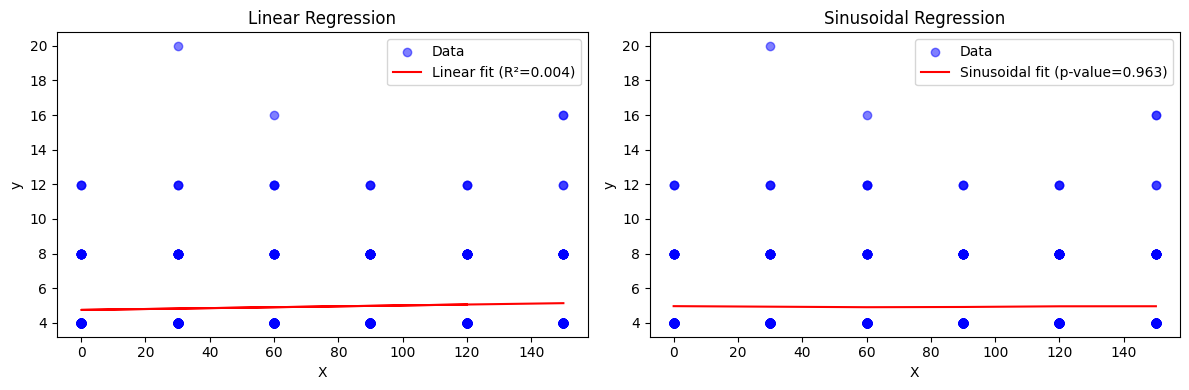

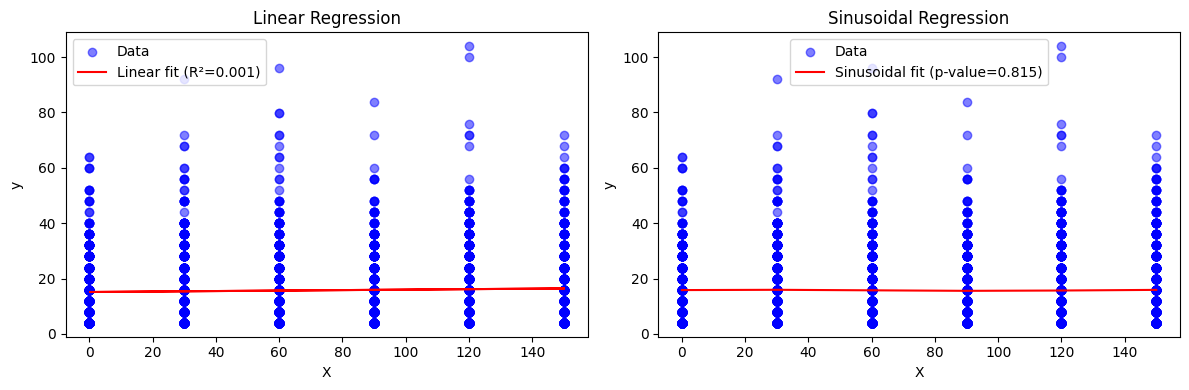

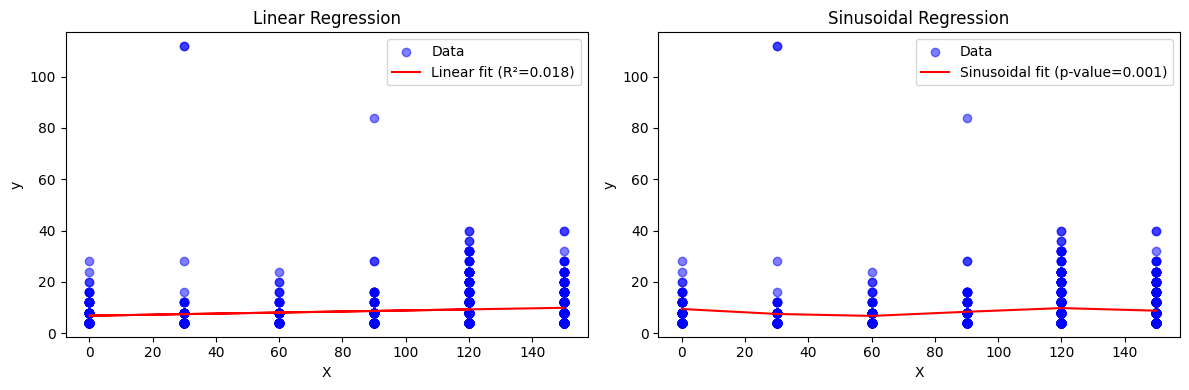

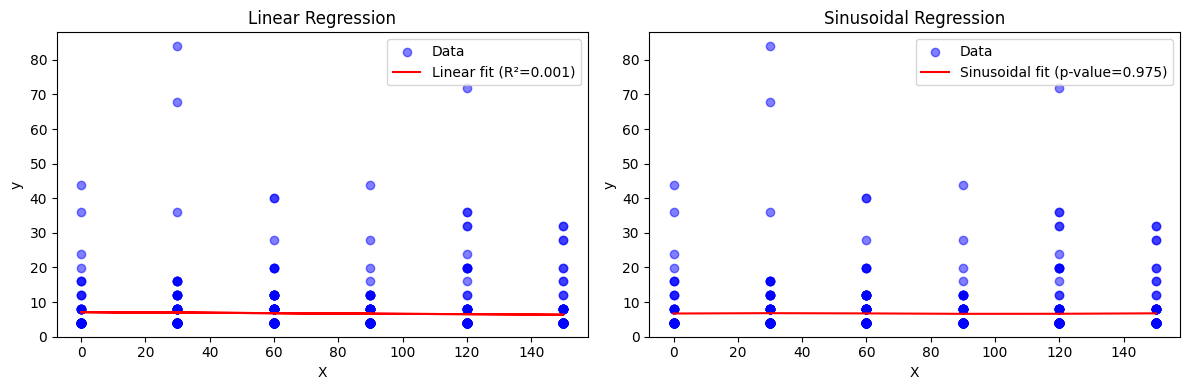

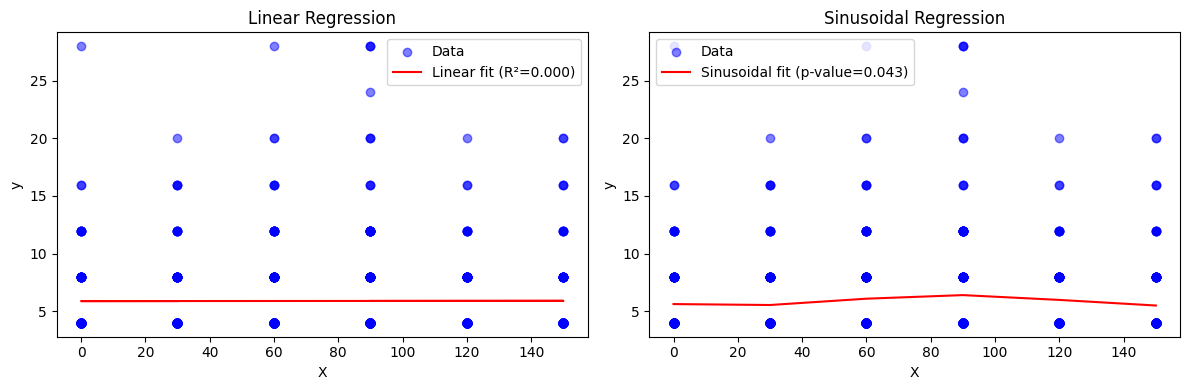

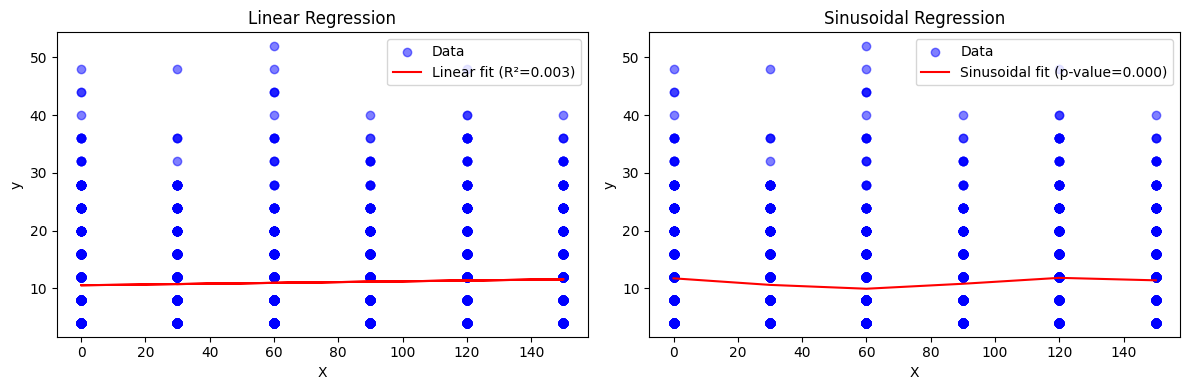

n_units  n_linear_significant  n_positive  n_negative  \
temporal_frequency         53                    43          18          25   
orientation_drifting       53                    21           8          13   
spatial_frequency          53                    35           5          30   
orientation_static         53                    30          18          12   

                      n_sin_significant  
temporal_frequency                   45  
orientation_drifting                 34  
spatial_frequency                    37  
orientation_static                   37

In [18]:
area_summary_df('VISal', plot=True)

In [19]:
area_summary_df('VISal')

n_units  n_linear_significant  n_positive  n_negative  \
temporal_frequency         53                    43          18          25   
orientation_drifting       53                    21           8          13   
spatial_frequency          53                    35           5          30   
orientation_static         53                    30          18          12   

                      n_sin_significant  
temporal_frequency                   45  
orientation_drifting                 34  
spatial_frequency                    37  
orientation_static                   37

In [20]:
area_summary_df('VISp')

n_units  n_linear_significant  n_positive  n_negative  \
temporal_frequency         85                    60          17          43   
orientation_drifting       85                    26           8          18   
spatial_frequency          85                    56          16          40   
orientation_static         85                    47          23          24   

                      n_sin_significant  
temporal_frequency                   64  
orientation_drifting                 59  
spatial_frequency                    63  
orientation_static                   62

In [21]:
area_summary_df('VISrl')

n_units  n_linear_significant  n_positive  n_negative  \
temporal_frequency         37                    19           9          10   
orientation_drifting       37                    17           9           8   
spatial_frequency          37                    20           8          12   
orientation_static         37                    18          10           8   

                      n_sin_significant  
temporal_frequency                   23  
orientation_drifting                 19  
spatial_frequency                    24  
orientation_static                   19

In [22]:
area_summary_df('VISam')

n_units  n_linear_significant  n_positive  n_negative  \
temporal_frequency         64                    40          18          22   
orientation_drifting       64                    22           8          14   
spatial_frequency          64                    41          12          29   
orientation_static         64                    31          22           9   

                      n_sin_significant  
temporal_frequency                   43  
orientation_drifting                 32  
spatial_frequency                    43  
orientation_static                   39

In [23]:
area_summary_df('VISl')

n_units  n_linear_significant  n_positive  n_negative  \
temporal_frequency         53                    34           9          25   
orientation_drifting       53                    21           1          20   
spatial_frequency          53                    35          14          21   
orientation_static         53                    31          11          20   

                      n_sin_significant  
temporal_frequency                   35  
orientation_drifting                 33  
spatial_frequency                    43  
orientation_static                   37